# Objective for Time series Air Pollution Forecasting

To build an accurate time series forecasting model that can forecast the pollutants in the environment such as <u>Carbon monoxide</u> (CO), <u>Hydrocarbon</u> (HC), <u>Nitrogen dioxide</u> (NO2) and <u>Ozone</u> (O3).

# Background Research

<b>What is air pollution and what are the impacts of it?</b>

"Air pollution is contamination of the indoor or outdoor environment by any chemical, physical or biological agent that modifies the natural characteristics of the atmosphere." - World Health Organization

The are two main factors that contribute to air pollution:
1. Natural phenomenon
2. Anthropogenic factors (man-made)

Some examples of air pollution caused by natural phenomenon are volcanic eruptions and wildfires, while some examples of air pollution 
caused by anthropogenic factors are agricultural processes, industrial processes and burning of fossil fuels in vehicles [1].

Chemicals or particles in the air can mix with water in the atmosphere and this causes the pollutants to take on many states such as
in gaseous, liquid or even the solid state. The problem of air pollutions is that it is detrimental to the health of living things.
For example, if air pollutants are inhaled by the human respiratory system, it can cause difficulty in breathing or in worst cases, 
death for that individual/animal [2].
___

<b>How is building a time series forecasting model for air pollutants beneficial or useful?</b>

Time series forecasting for air quality is beneficial in many ways as it can help us to obtain a pragmatic sighting to make better 
decisions [3]. Firstly, it can help weather forecasting stations make optimal decisions such as issuing a warning message to alert the public 
on the potential unhealthy air quality [4]. Secondly, it can help government officials to plan long-term based on the forecasting results 
of air pollutants to mitigate the problem.
___

# Importing modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict
from tqdm import tqdm
from joblib import Parallel, delayed

sns.set()
plt.rcParams['figure.figsize'] = (20, 8)

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose,STL

# Models
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents

# Check for stationarity and determine AR/MA terms
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Modelling and evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

<b>Reading the dataset</b>

In [2]:
df = pd.read_csv('train.csv')
df

Date          T         RH Gas        Value  Unnamed: 5  Unnamed: 6
0     15/3/2016  12.020833  54.883334  CO  1053.200000         NaN         NaN
1     16/3/2016   9.833333  64.069791  CO   995.250000         NaN         NaN
2     17/3/2016  11.292708  51.107292  CO  1025.250000         NaN         NaN
3     18/3/2016  12.866319  51.530903  CO  1064.444444         NaN         NaN
4     19/3/2016  16.016667  48.843750  CO  1088.741667         NaN         NaN
...         ...        ...        ...  ..          ...         ...         ...
1307   1/2/2017   5.267708  39.614930  O3   553.180556         NaN         NaN
1308   2/2/2017 -55.515972 -24.010417  O3   343.500000         NaN         NaN
1309   3/2/2017 -14.272917  28.563542  O3   334.458333         NaN         NaN
1310   4/2/2017   4.848611  37.832986  O3   379.513889         NaN         NaN
1311   5/2/2017   7.273958  31.809375  O3   947.333333         NaN         NaN

[1312 rows x 7 columns]

From a first glance at the dataset we can see that there are 2 columns that seem to be null and are unnamed, so we will just remove these two columns.

In [3]:
# Removing the two unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Exploratory Data Analysis

In [4]:
dfEDA = df.copy()

We can see that there are 5 columns in the original dataset with 2 categorical columns and 3 numerical columns, however, one of the categorical columns is actually in date form.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1312 entries, 0 to 1311
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1312 non-null   object 
 1   T       1312 non-null   float64
 2   RH      1312 non-null   float64
 3   Gas     1312 non-null   object 
 4   Value   1312 non-null   float64
dtypes: float64(3), object(2)
memory usage: 51.4+ KB


We will first change the `Date` column to date type and set it to become the index of the dataframe.

In [6]:
warnings.filterwarnings('ignore')
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', inplace=True)

We will then pivot the dataset into wide format and make each gas have its own column and we can see that the pivoted dataframe has 328 rows and 6 columns now and all of them are numerical.

In [7]:
pivotDf = df.pivot(columns='Gas', values='Value')
pivotDf.columns = [''.join(str(i).strip() for i in cols if i)
                   for cols in pivotDf.columns]
pivotDf.insert(0, "RH", df[["RH"]].groupby(df.index).mean())
pivotDf.insert(0, "T", df[["T"]].groupby(df.index).mean())

In [8]:
pivotUntouched = pivotDf.copy()

In [9]:
pivotDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       328 non-null    float64
 1   RH      328 non-null    float64
 2   CO      328 non-null    float64
 3   HC      328 non-null    float64
 4   NO2     328 non-null    float64
 5   O3      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


In [10]:
pivotDf.describe()

T          RH           CO           HC          NO2  \
count  328.000000  328.000000   328.000000   328.000000   328.000000   
mean    11.634917   39.873729   840.583477   729.588974   650.087974   
std     37.084233   43.267370   204.831525   190.472814   193.658229   
min   -200.000000 -200.000000  -160.000000  -160.000000  -160.000000   
25%     12.387760   36.348177   779.191667   662.795833   566.095833   
50%     18.832292   46.078993   864.141667   753.681944   659.325000   
75%     25.557118   57.932292   946.431250   847.712500   754.351389   
max     32.997917   81.104167  1210.566667  1084.083333  1342.950000   

                O3  
count   328.000000  
mean    780.614931  
std     261.846007  
min    -160.000000  
25%     639.850000  
50%     794.893056  
75%     944.608333  
max    1436.233333

<b>Identifying missing values</b>

After some background research, I realised that missing values of this dataset has been tagged with a value of `-200`. After inspecting the missing values, we see that there only missing values under temperature and relative humidity.

However, we can see that there is a weird pattern that shows that for every row that relative humidity and temperature is null in, the gases have a value of `-160` as well.

In [11]:
pivotDf[pivotDf.isin([-200]).any(axis=1)]

T     RH     CO     HC    NO2     O3
Date                                                
2016-06-25 -200.0 -200.0 -160.0 -160.0 -160.0 -160.0
2016-09-01 -200.0 -200.0 -160.0 -160.0 -160.0 -160.0
2016-12-20 -200.0 -200.0 -160.0 -160.0 -160.0 -160.0
2016-12-21 -200.0 -200.0 -160.0 -160.0 -160.0 -160.0
2017-01-08 -200.0 -200.0 -160.0 -160.0 -160.0 -160.0
2017-01-09 -200.0 -200.0 -160.0 -160.0 -160.0 -160.0

The days before and after the days with null values also seem to have negative values which are impossible and that will be explained later on.

In [12]:
# Analysing the days before and after the days with null values under 'T' and 'RH'
pivotDf.loc[['2016-06-24', '2016-06-26', '2016-08-31', '2016-09-02', '2016-12-19', '2016-12-22', '2017-01-07', '2016-06-10']]

T          RH          CO          HC         NO2  \
Date                                                                     
2016-06-24  -68.069792  -58.296875  385.402778  326.963889  362.972222   
2016-06-26  -12.148958   -5.416667  606.991667  630.991667  560.566667   
2016-08-31 -144.072917 -138.672917   48.866667   14.841667   82.016667   
2016-09-02   -0.613542    9.307292  642.800000  555.500000  566.891667   
2016-12-19  -51.363194  -11.956250  648.391667  588.127778  333.647222   
2016-12-22 -164.510417 -154.515625   29.025000   -0.166667  -43.350000   
2017-01-07  -19.247917   26.868750  745.391667  542.716667  545.166667   
2016-06-10   23.872917   45.058333  769.991667  712.883333  780.000000   

                    O3  
Date                    
2016-06-24  305.705556  
2016-06-26  519.941667  
2016-08-31   -0.975000  
2016-09-02  493.341667  
2016-12-19  794.986111  
2016-12-22   18.833333  
2017-01-07  828.241667  
2016-06-10  681.866667

We can also see from the line graphs that there are sudden downward spikes which can be explained by the null values and impossible values.

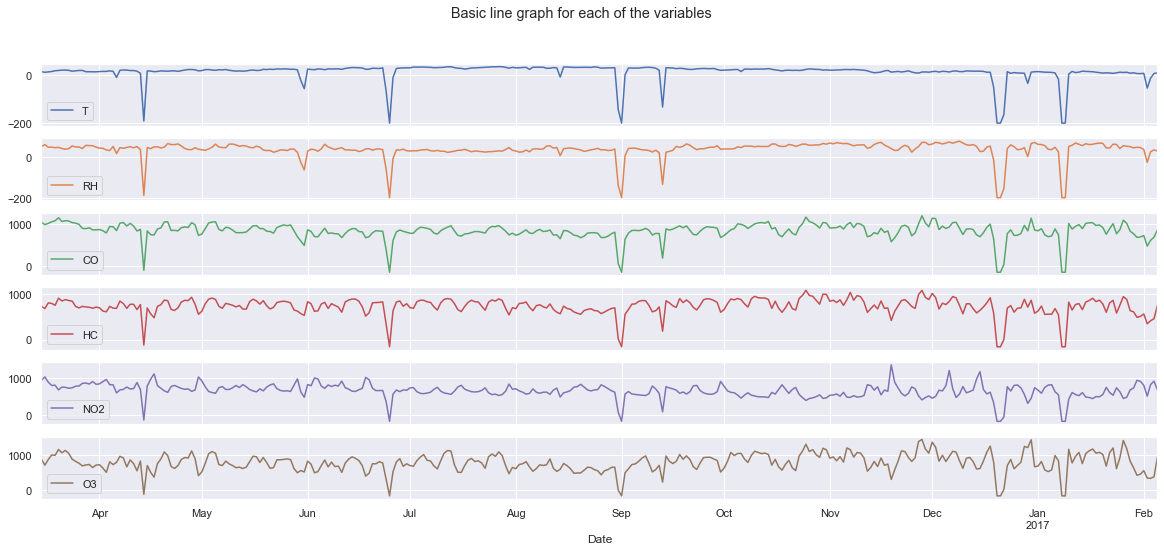

In [13]:
pivotDf.plot(subplots=True)
plt.suptitle('Basic line graph for each of the variables')
plt.legend(loc='lower left')
plt.show()

<b>Identifying outlier values using Tukey's fences</b>

However, we must keep in in mind that for time series, it would be illogical to use future data to assess past data. For that, we must perform tukey's fences on a rolling basis and we can do that by using `.rolling` provided by pandas.

In [14]:
def outlierDetection(df, column):
    data = df[column].rolling(window=7, min_periods=1)
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lowerFence = q1 - 1.5*iqr
    upperFence = q3 + 1.5*iqr
    outliers = ~(df[column].between(lowerFence, upperFence))
    return outliers

pivotDf2 = pivotDf.copy()

In [15]:
for col in pivotDf2.columns:
    pivotDf2[f'{col} Outliers'] = outlierDetection(pivotDf2, col)
    print(pivotDf2[f'{col} Outliers'].value_counts())

False    285
True      43
Name: T Outliers, dtype: int64
False    297
True      31
Name: RH Outliers, dtype: int64
False    299
True      29
Name: CO Outliers, dtype: int64
False    304
True      24
Name: HC Outliers, dtype: int64
False    301
True      27
Name: NO2 Outliers, dtype: int64
False    307
True      21
Name: O3 Outliers, dtype: int64


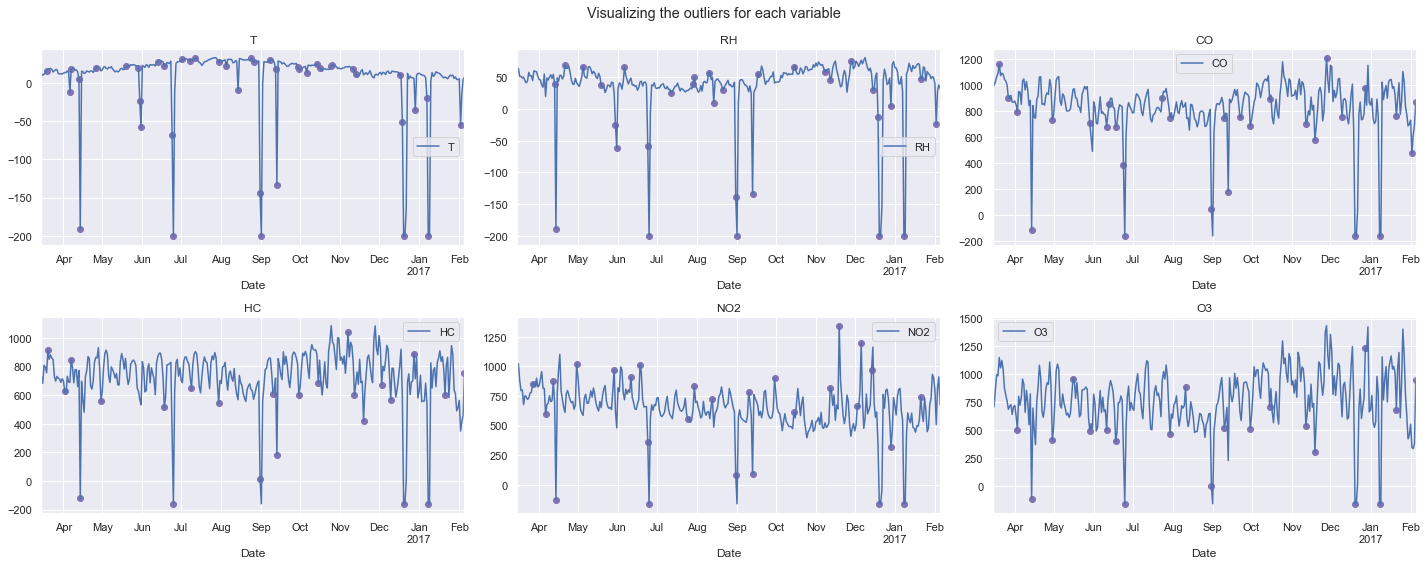

In [16]:
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(2, 3, tight_layout=True)

for ax, col in zip(axes.ravel(), pivotDf2.columns):
    outliers = pivotDf2[pivotDf2[f'{col} Outliers'] == True]
    pivotDf2.plot(y=col, title=col, ax=ax)
    ax.scatter(x=outliers.index, y=outliers[col], color='m')

fig.suptitle('Visualizing the outliers for each variable')
fig.show()

Although we see that there are many outliers in the dataset, we want to keep some of them so that our model will be robust to predicting outlier values as well.
___

<b>Identifying impossible values</b>

We can expect that there are 'impossible' values in our data as well. These are values that defy natural phenomena (e.g Negative percentage of relative humidity and negative gas values). So, lets plot some visualisations to help us identify how many there are and where they are.

In [17]:
# Showing rows that have at least one impossible/outlier values 
impossible = pivotDf2.loc[(pivotDf2['T'] < 0)|(pivotDf2['RH'] < 0) |
                          (pivotDf2['NO2'] < 0) | (pivotDf2['HC'] < 0) | 
                          (pivotDf2['O3'] < 0) | (pivotDf2['CO'] < 0), :]

impossible

T          RH          CO          HC         NO2  \
Date                                                                     
2016-04-06  -11.426042   19.742014  850.991667  687.247222  596.386111   
2016-04-14 -191.164583 -188.839583 -114.133333 -122.766667 -124.466667   
2016-05-30  -23.920833  -24.786458  598.225000  569.850000  623.550000   
2016-05-31  -57.951736  -61.500694  489.027778  530.961111  480.750000   
2016-06-24  -68.069792  -58.296875  385.402778  326.963889  362.972222   
2016-06-25 -200.000000 -200.000000 -160.000000 -160.000000 -160.000000   
2016-06-26  -12.148958   -5.416667  606.991667  630.991667  560.566667   
2016-08-14   -9.852431    9.186111  652.894444  566.805556  486.658333   
2016-08-31 -144.072917 -138.672917   48.866667   14.841667   82.016667   
2016-09-01 -200.000000 -200.000000 -160.000000 -160.000000 -160.000000   
2016-09-02   -0.613542    9.307292  642.800000  555.500000  566.891667   
2016-09-13 -133.732292 -133.684375  180.166667  182.550000   92.991667   
2016-12-19  -51.363194  -11.956250  648.391667  588.127778  333.647222   
2016-12-20 -200.000000 -200.000000 -160.000000 -160.000000 -160.000000   
2016-12-21 -200.000000 -200.000000 -160.000000 -160.000000 -160.000000   
2016-12-22 -164.510417 -154.515625   29.025000   -0.166667  -43.350000   
2016-12-29  -36.022917    4.436111  844.372222  712.916667  317.875000   
2017-01-07  -19.247917   26.868750  745.391667  542.716667  545.166667   
2017-01-08 -200.000000 -200.000000 -160.000000 -160.000000 -160.000000   
2017-01-09 -200.000000 -200.000000 -160.000000 -160.000000 -160.000000   
2017-02-02  -55.515972  -24.010417  474.291667  347.480556  508.180556   
2017-02-03  -14.272917   28.563542  615.700000  414.475000  819.733333   

                     O3  T Outliers  RH Outliers  CO Outliers  HC Outliers  \
Date                                                                         
2016-04-06   789.052778        True        False        False        False   
2016-04-14  -114.958333        True         True         True         True   
2016-05-30   557.075000        True         True        False        False   
2016-05-31   514.877778        True         True        False        False   
2016-06-24   305.705556        True         True         True        False   
2016-06-25  -160.000000        True         True         True         True   
2016-06-26   519.941667       False        False        False        False   
2016-08-14   590.861111        True         True        False        False   
2016-08-31    -0.975000        True         True         True         True   
2016-09-01  -160.000000        True         True        False        False   
2016-09-02   493.341667       False        False        False        False   
2016-09-13   228.008333        True         True         True         True   
2016-12-19   794.986111        True         True        False        False   
2016-12-20  -160.000000        True         True         True         True   
2016-12-21  -160.000000       False        False        False        False   
2016-12-22    18.833333       False        False        False        False   
2016-12-29  1205.241667        True         True        False        False   
2017-01-07   828.241667        True        False        False        False   
2017-01-08  -160.000000        True         True         True         True   
2017-01-09  -160.000000       False        False        False        False   
2017-02-02   343.500000        True         True         True        False   
2017-02-03   334.458333       False        False        False        False   

            NO2 Outliers  O3 Outliers  
Date                                   
2016-04-06          True        False  
2016-04-14          True         True  
2016-05-30         False        False  
2016-05-31         False        False  
2016-06-24          True        False  
2016-06-25          True         True  
2016-06-26         False        False  
2016-08-14 

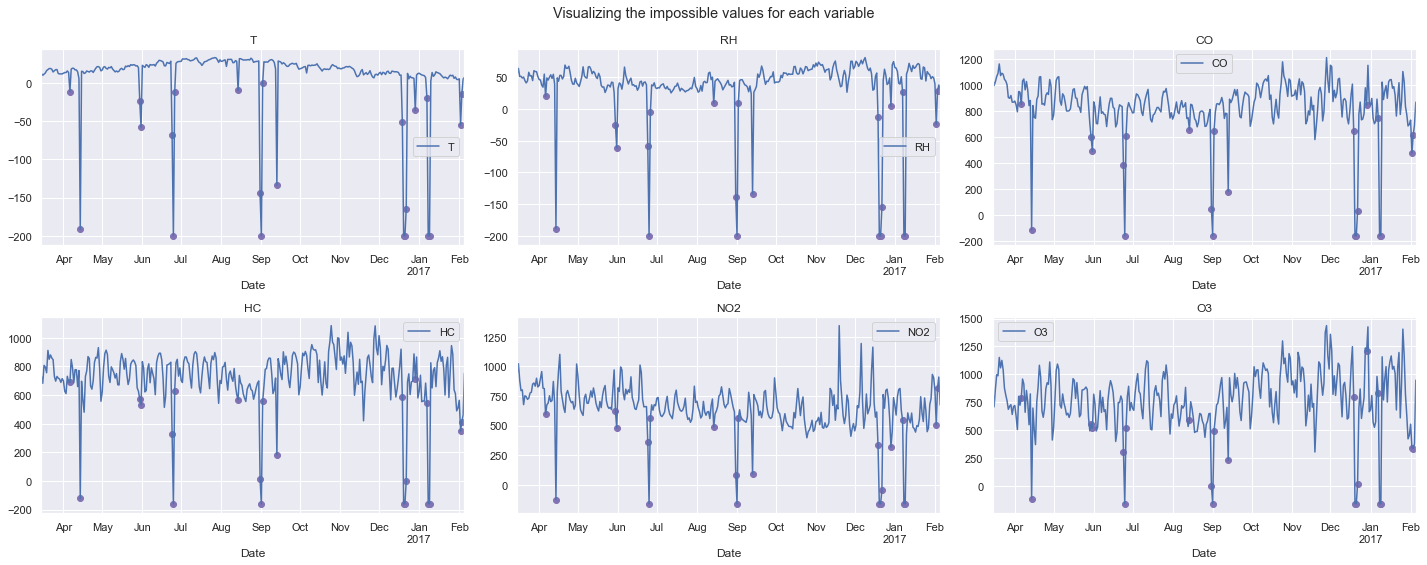

In [18]:
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(2, 3, tight_layout=True)

for ax, col in zip(axes.ravel(), pivotDf2.columns):
    outliers = impossible
    pivotDf2.plot(y=col, title=col, ax=ax)
    ax.scatter(x=outliers.index, y=outliers[col], color='m')

fig.suptitle('Visualizing the impossible values for each variable')
fig.show()

<b>Handling impossible/outlier values</b>

We will not be dropping the impossible/outlier values as this will create 'gaps' in our data, causing the periods to be irregular.

Instead, we will be handling these values by interpolation and limiting the direction to forward only as we cannot interpolate past values using future values in time series data.

In [19]:
# Handling impossible values
pivotDf.loc[impossible.index] = np.NaN

print('Before interpolation (No. of null values):')
print(pivotDf.isna().sum())
print('\nAfter interpolation (No. of null values):')
# Interpolating to fill in the NaN values
pivotDf.interpolate(method='time', limit_direction='forward', inplace=True)
print(pivotDf.isna().sum())

Before interpolation (No. of null values):
T      22
RH     22
CO     22
HC     22
NO2    22
O3     22
dtype: int64

After interpolation (No. of null values):
T      0
RH     0
CO     0
HC     0
NO2    0
O3     0
dtype: int64


<b>Visualizing the variables' values over time after preprocessing</b>

We can see that after handling impossible values, the time series look more consistent instead of showing extremely significant drops due to the impossible values in the dataset.

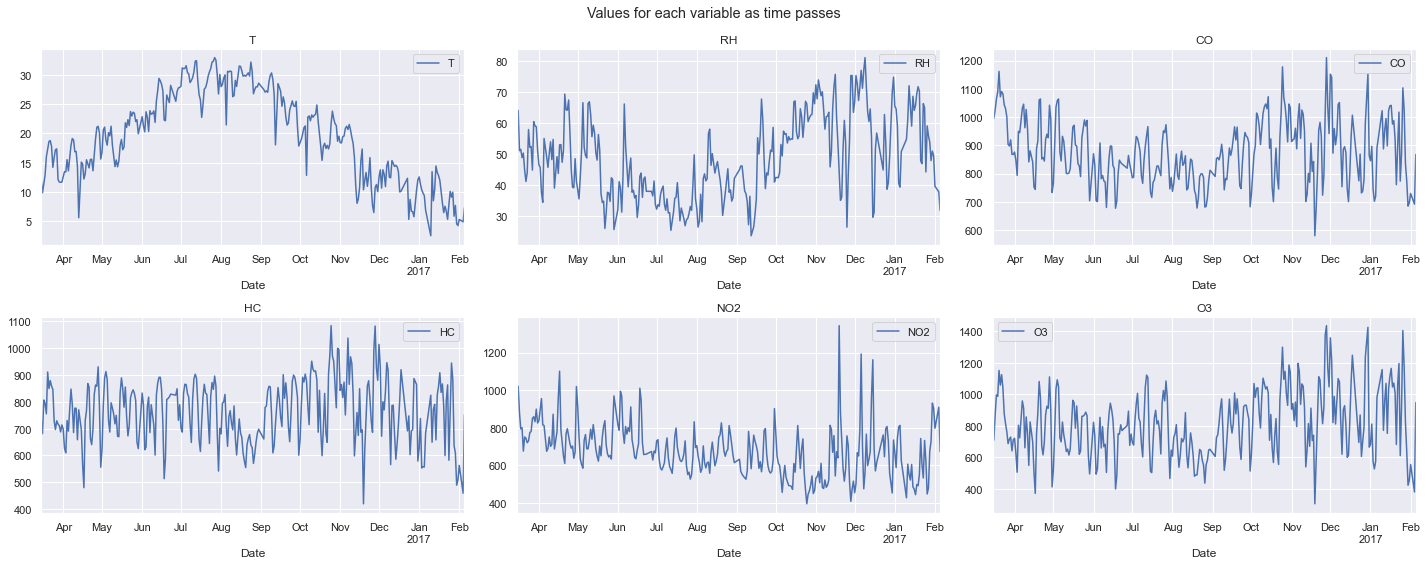

In [20]:
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(2, 3, tight_layout=True)

for ax, col in zip(axes.ravel(), pivotDf.columns):
    pivotDf.plot(y=col, title=col, ax=ax)

fig.suptitle('Values for each variable as time passes')
fig.show()

<b>Visualising the significance of relationships between variables</b>

We will plot the correlation after applying percentage change - `pct_change()`. This is to avoid a spurious relationship which means that the statistical summaries show that the variables are related to each other but in fact, theoretically, there is no relationships between the two variables. Basically, avoiding incorrect results.

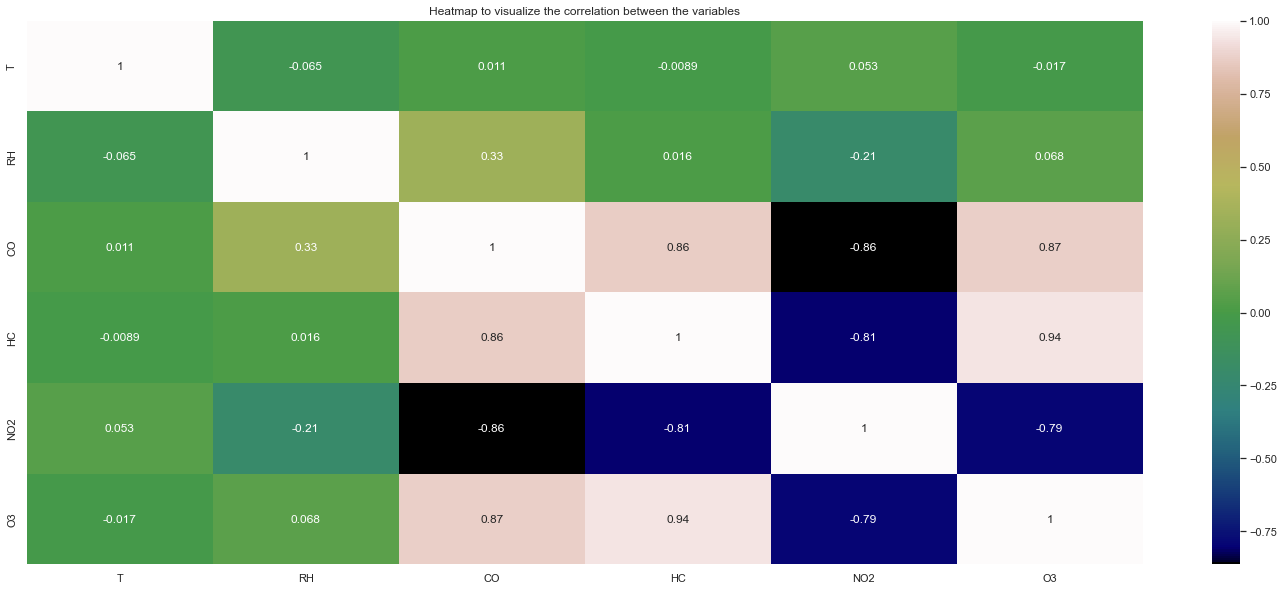

In [21]:
plt.figure(figsize=(25,10))
sns.heatmap(pivotDf.pct_change().corr(), annot=True, cmap='gist_earth')
plt.title('Heatmap to visualize the correlation between the variables')
plt.show()

From the heatmap, we are able to tell that:
- There is a moderately high correlation between NO2 and O3 with a correlation coefficient of -0.79
- There is a high correlation between HC and NO2 with a correlation coefficient of -0.81
- There is also high correlation between CO and HC with a correlation coefficient of 0.86
- There is also high correlation between CO and O3 with a correlation coefficient of 0.87
- There is a higher correlation between HC and O3 with a correlation coefficient of 0.94
- HC gas is highly correlated with all the other gases 
- Exogenous variables T and RH have low correlation with each other as well as with the other gases
___

# Analysing the time series

- We will be conducting a few statistical tests as the results of these tests can help us understand if our dataset is conformable to be used in certain models.

- For example, for multivariate models like VARMAX, we have to perform tests like Granger's Causality Test. We also have to find out the significance of the relationship between variables.

- As for stationarity, it is important that the data is stationary as many models (e.g. Auto-regressive models) depend on stationary data. If not, it would be an issue later during modelling.
___

<b>Test for stationarity</b>

Stationarity means that the statistical properties (i.e the mean and the variance) of the data do not change over time.

We can test for stationarity using the Augmented Dickey-Fuller unit root test at a significance level of 5% and if we find that the data is not stationary, we can transform the data or apply differencing to it.

$$H_0 : \text{Time series is not stationary} \\ H_1 : \text{Time series is stationary} $$

In [22]:
cols = pivotDf.columns
results = []
def dickey(colNames):
    for col in colNames:
        results2 = []
        dftest = adfuller(pivotDf[col], autolag="AIC")
        for val in range(len(dftest)-1):
            if val == 4: 
                for z, y in dftest[4].items():
                    results2.append(y)
            else: 
                results2.append(dftest[val])
        results.append(results2)
    
dickey(cols)

dickeyDF = pd.DataFrame(results, index=cols, columns=['Test statistic', 'P-value', 'No. of Lags Used', 'No. of observations Used', 
                                 'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)'])

dickeyDF['Stationary'] = dickeyDF['P-value'] <= 0.05

for idx in dickeyDF.index:
    if dickeyDF.loc[idx, 'Stationary'] == True:
        print(f'Since P-value ({dickeyDF.loc[idx, "P-value"]}) for {idx} is less than 0.05, there is sufficient evidence to reject H0. Therefore, {idx} is stationary.')
    else:
        print(f'Since P-value ({dickeyDF.loc[idx, "P-value"]}) for {idx} is more than 0.05, there is insufficient evidence to reject H0. Therefore, {idx} is non-stationary.')

dickeyDF

Since P-value (0.9265317691726698) for T is more than 0.05, there is insufficient evidence to reject H0. Therefore, T is non-stationary.
Since P-value (0.0005187843221811049) for RH is less than 0.05, there is sufficient evidence to reject H0. Therefore, RH is stationary.
Since P-value (0.004101039745215198) for CO is less than 0.05, there is sufficient evidence to reject H0. Therefore, CO is stationary.
Since P-value (0.007591619109563836) for HC is less than 0.05, there is sufficient evidence to reject H0. Therefore, HC is stationary.
Since P-value (0.001776608055060652) for NO2 is less than 0.05, there is sufficient evidence to reject H0. Therefore, NO2 is stationary.
Since P-value (0.008846621300866652) for O3 is less than 0.05, there is sufficient evidence to reject H0. Therefore, O3 is stationary.


Test statistic   P-value  No. of Lags Used  No. of observations Used  \
T         -0.292701  0.926532                10                       317   
RH        -4.260910  0.000519                 2                       325   
CO        -3.700862  0.004101                12                       315   
HC        -3.515753  0.007592                14                       313   
NO2       -3.937339  0.001777                 6                       321   
O3        -3.468048  0.008847                14                       313   

     Critical Value (1%)  Critical Value (5%)  Critical Value (10%)  \
T              -3.451148            -2.870701             -2.571651   
RH             -3.450632            -2.870474             -2.571530   
CO             -3.451281            -2.870760             -2.571682   
HC             -3.451416            -2.870819             -2.571714   
NO2            -3.450887            -2.870586             -2.571590   
O3             -3.451416            -2.870819             -2.571714   

     Stationary  
T         False  
RH         True  
CO         True  
HC         True  
NO2        True  
O3         True

Since we know that the data for the gases are stationary, we would not have to perform any transformation or differencing to it. So, if we are using ARIMA models the sequence will follow ARIMA(p,0,q) where p and q will be decided later using the correlograms of autocorrelation and partial autocorrelation.
___

<b>Granger's Causality Test</b>

We perform Granger's Causality Test at a significance level of 5% to see if the variables in the time series are interchangeably causing each other. 

We want there to be some causation between the variables so as to justify multivariate modelling [5].

$$H_0 : \text{Time series x does not Granger-cause time series y} \\ H_1 : \text{Time series x Granger-causes time series y} $$

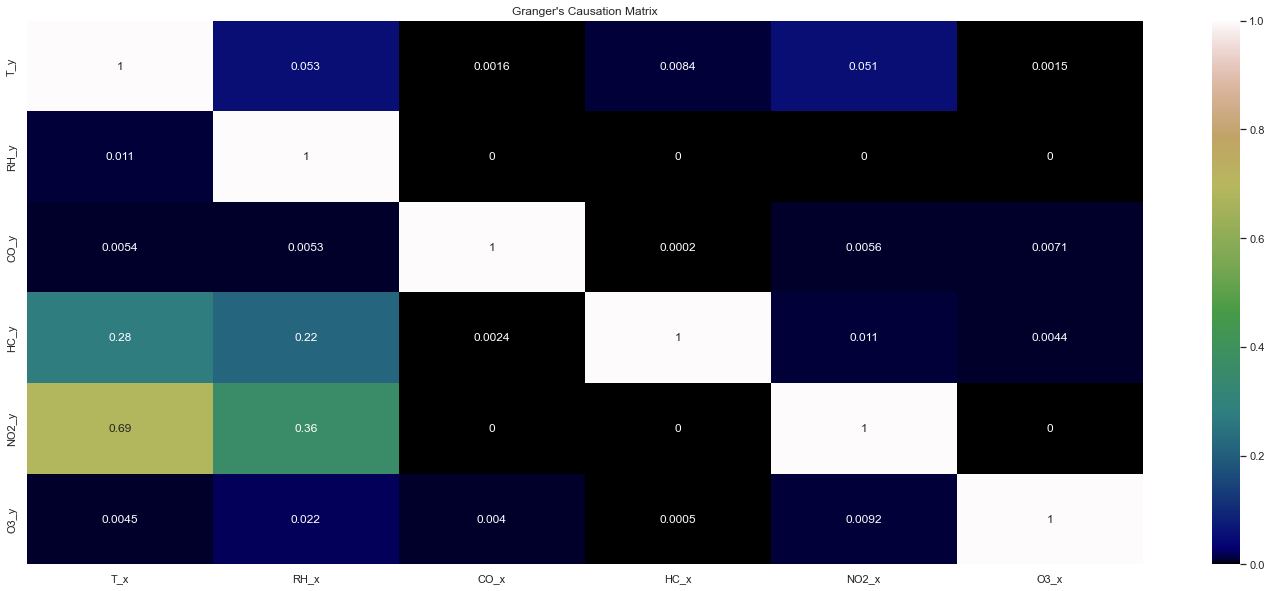

In [23]:
def checkcausality(data, variables, test='ssr_chi2test', maxlag=12):
    empty = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in empty.columns:
        for idx in empty.index:
            test_result = grangercausalitytests(data[[idx,col]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            empty.loc[idx,col] = min_p_value
    empty.columns = [var + '_x' for var in variables]
    empty.index = [var + '_y' for var in variables]
    return empty

plt.figure(figsize=(25,10))
sns.heatmap(checkcausality(pivotDf, variables=pivotDf.columns), annot=True, cmap='gist_earth')
plt.title('Granger\'s Causation Matrix')
plt.show()

We can see that most of the p-values between variables from the Granger's Causality Test are less than 0.05 which means that they are interchangeably causing one another.

This gives us the 'GO' sign to implement multivariate modelling.

- Some significant variables do not have a p-value of less than 0.05. For example, T and NO2, RH and NO2, T and HC as well as RH and HC.
- However, we do not require all variables to be interchangeably causing one another to implement multivaiate modelling
___

<b>Trend and seasonality of data</b>

From the prevous graph, we can see that the frequency and amplitude does not vary over time for the gases. This indicates that it is an additive time series. We want to decompose the time series to help us with the model selection later on.

To decompose the time series, there are two main methods to do so in Python, namely:

<ol>
    <li>Classical method (seasonal_decomposition)</li>
    <li>STL "Seasonal and Trend decompostion using LOESS (LOcal regrESSion)"</li>
</ol>

We will choose to use the STL decomposition method for the following reasons:

<ul>
    <li>The classical decomposition method tends to 'over-smooth' the sharp drops and rises in the data causing it to have a poor trend-cycle</li>
    <li>Furthermore, it also assumes that the seasonal components is repeated yearly. While this may be a somewhat acceptible assumption, if there is a particularly unusual period, the classical decomposition will not be able to capture these seasonal changes which makes it not robust to these unusual values</li>
    <li>STL is unlike any of the previous decomposition techniques in terms of handling seasonality as it can handle any types of seasonality and is also robust to unusual observations [6].</li>
    <li>However, STL does have its own disadvantages like only supporting facilities for additive time series but it does not matter to us as it has been established that the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series [6].</li>
</ul>

Carbon monoxide (CO)

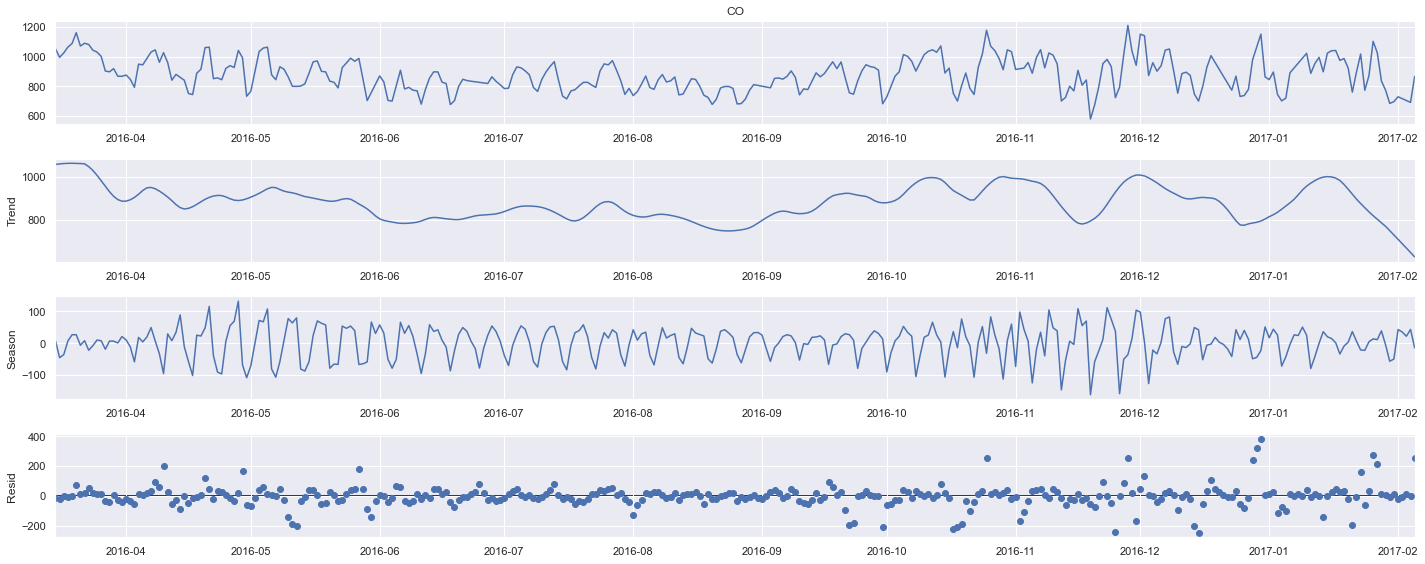

In [24]:
STL(pivotDf['CO'], robust=True).fit().plot()
plt.show()

- The trend for Carbon Monoxide shows that there is a downward trend from April 2016 to September 2016 and the trend changed upwards from September 2016 to February 2017
- The seasonal component shows that there is weekly seasonality for Carbon monoxide emissions
- We can see that the residual values become larger and larger over time, indicating more noise as time passes
___

Hydrocarbon (HC)

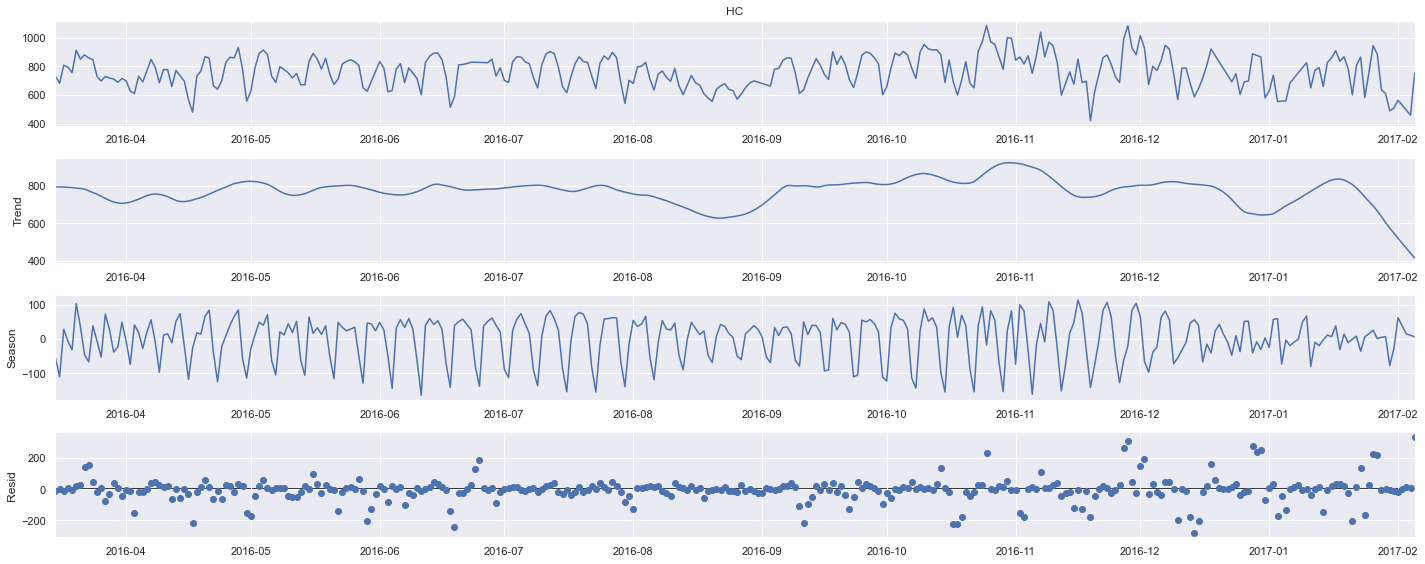

In [25]:
STL(pivotDf['HC'], robust=True).fit().plot()
plt.show()

- There seems to be a downward trend overall for Hydrocarbon except for a short one month upward trend from mid August 2016 to November 2016
- There also seem to a weekly seasonality as seen from the seasonal components having four recurring patterns per month
- Similarly for the residuals, there seem to be more noise over time as the residuals get larger over time especially between December 2016 and February 2017
___

Nitrogen dioxide (NO2)

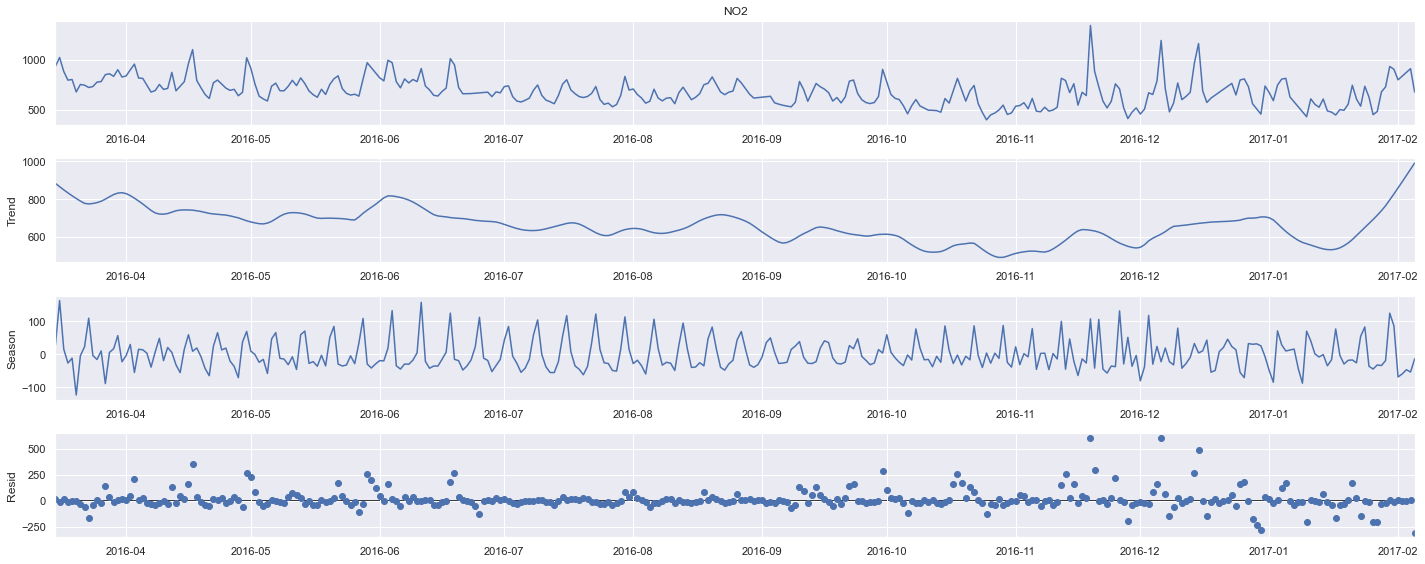

In [26]:
STL(pivotDf['NO2'], robust=True).fit().plot()
plt.show()

- There is an obvious downward trend from the start of 2016 to the end of 2016 but there is a sudden upward trend at the start of 2017
- Seasonal component shows there is weekly seasonality as well for Nitrogen dioxide emissions
- Residuals seem to be more stable as compared to Carbon monoxide and Hydrocarbon, indicating less noise
___

Ozone (O3)

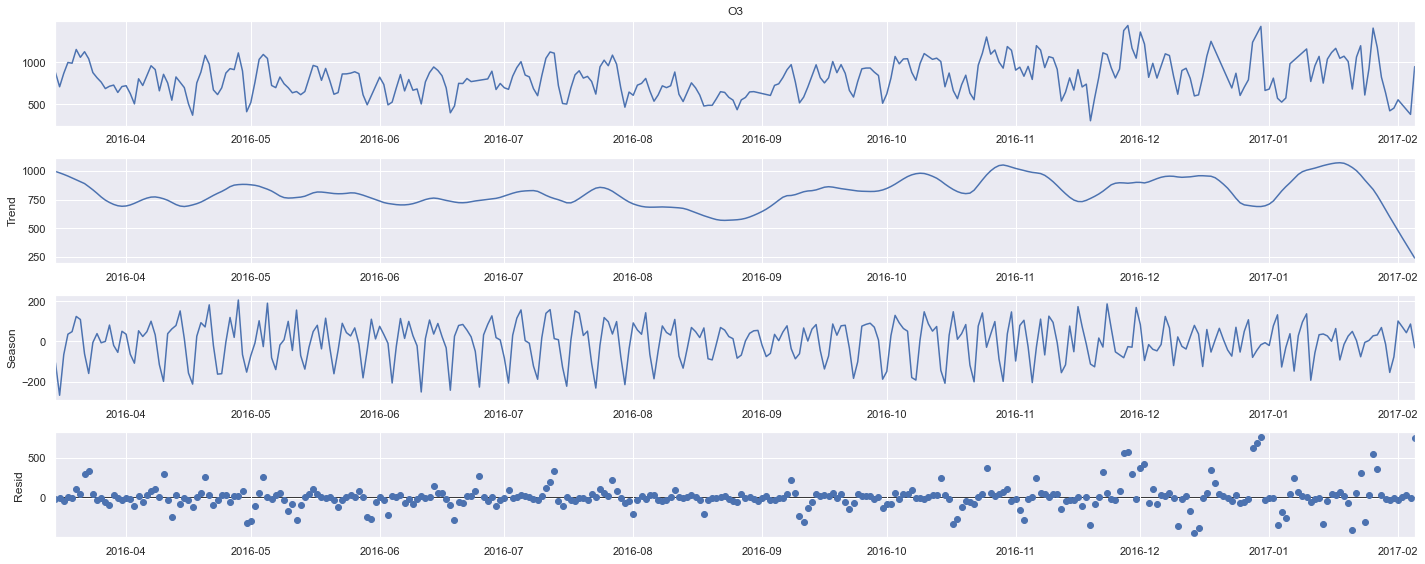

In [27]:
STL(pivotDf['O3'], robust=True).fit().plot()
plt.show()

- There seems to be a constant trend for Ozone from April 2016 to August 2016 and from then on there was a upward trend all the way till January 2017
- Ozone has weekly seasonality as well as we can see from the repeating patterns of 4 every month
- There is quite a lot of noise in late 2016 to early 2017 as wee can see that the residual values are larger there
___

# Modelling/Model Selection

<b>Types of models</b>

There are various models we can choose from for time series, some examples are:

1. Smoothing
    - Exponential smoothing, Holt Winters Exponential Smoothing (HWES)
2. Unobserved Components
3. ARIMA family
    - ARIMA, ARIMAX, SARIMA, SARIMAX
4. Vector autoregressive
    - VARMA, VARMAX

In [28]:
# Setting a variable to contain list of target variables
gases = ['CO', 'HC', 'NO2', 'O3']

<b>Metrics</b>

As for the metric to score the time series model, I will be using <u>AIC (Akaike Information Criterion)</u>, <u>BIC (Bayesian Information Criterion)</u> and <u>RMSE (Root Mean Squared Error)</u> to evaluate the 'goodness' of the fit.

<ul>
    <li>RMSE is the standard deviation of residuals which indicates how spread out the data is from the 'line of best fit'</li>
    <li>Lower AIC and BIC values indicate lower penalty terms which means that the smaller the AIC/BIC, the better the model</li>
</ul>

The formula of these criterias go by:

$$RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(\hat{y_{i}}-y_{i})^2}$$

$$Where\;{N}\;is\;the\;total\;number\;of\;data\;points,\;\hat{y_{i}}\;is\;the\;predicted\;value\;and\;y_{i}\;is\;the\;true\;value$$

$$AIC = -2\ln{(L)}+2k$$

$$Where\;{L}\;is\;the\;maximum\;likelihood\;estimation\;and\;k\;is\;the\;number\;of\;parameters$$

$$BIC = ln{(n)}k-2\ln{(L)}$$

$$Where\;{L}\;is\;the\;maximum\;likelihood\;estimation,\;n\;is\;the\;number\;of\;data\;points\;and\;k\;is\;the\;number\;of\;parameters$$

___

<b>Plotting ACF and PACF</b>

What is ACF?
- ACF refers to autocorrelation. Autocorrelation is the correlation between two observations at different points (days, in this data set) in a time series

What is PACF?
- PACF refers to partial autocorrelation. Partial autocorrelation displays the unique correlation between two observations after partialling out the intervening correlations with the other variables.

Why do we need to plot them?
- Plotting PACF and ACF allows us to determine the AR (Auto Regressive) and MA (Moving Average) components respectively of an ARIMA family model

So, how will we determine these components?
- We will determine the two components by the lag when the coefficient is statistically significantly different from 0, where it is outside of the confidence bound

At specific scenarios, the components of AR(p) and MA(q) will be 0:
- p will be 0 when PACF is decaying exponentially and the same goes for q when ACF is decaying exponentially
- The value of p will also be 0 when there is a significant spike at lag p of the ACF plot but none beyond that and vice versa for q when there is a significant spike at lag p of the PACF plot but none beyond that
___

Determining the global order of the models

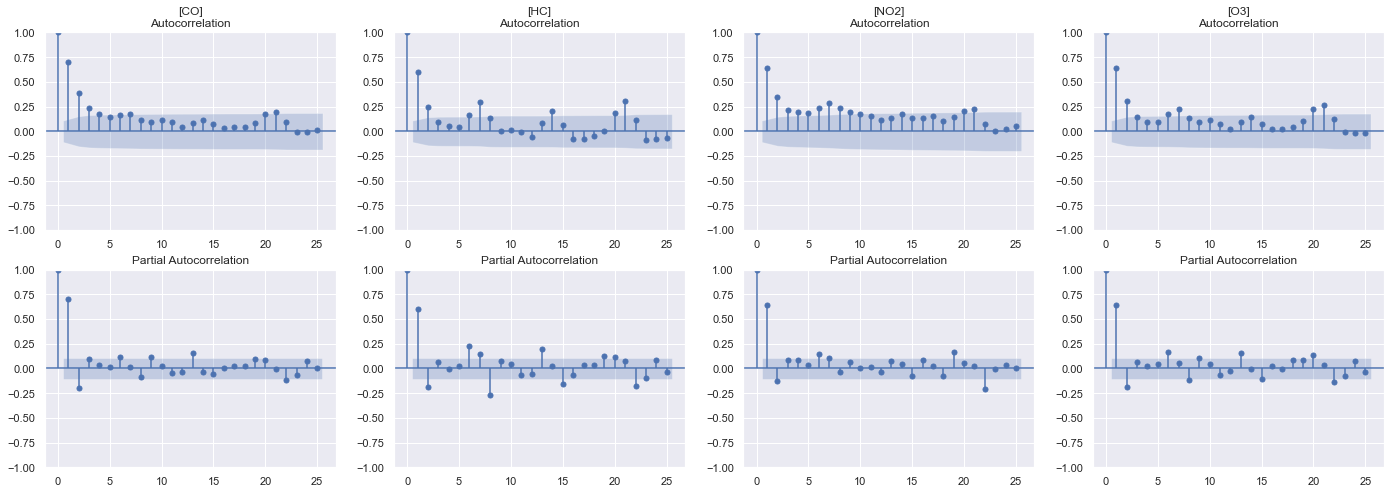

In [29]:
fig, axes = plt.subplots(2,4, figsize = (24,8))
for idx, variable in enumerate(gases):
    plot_acf(pivotDf[variable], lags = 25, ax = axes[0, idx])
    plot_pacf(pivotDf[variable], lags = 25, ax = axes[1, idx])
    axes[0, idx].set_title(f'[{variable}]\nAutocorrelation')
plt.show()

Determining the seasonal order of the models

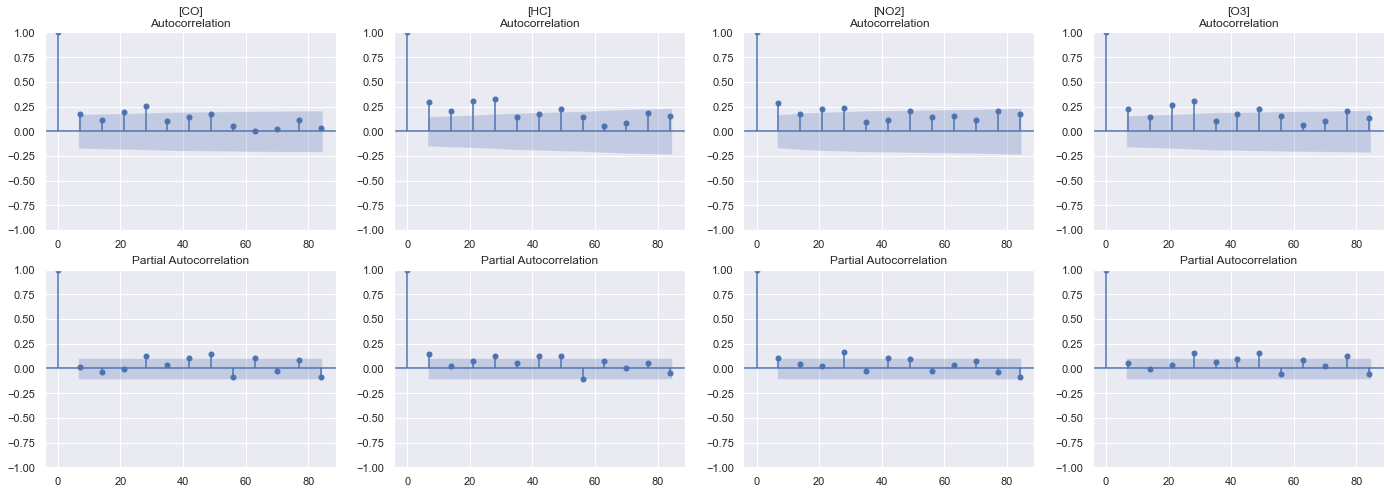

In [30]:
fig, axes = plt.subplots(2,4, figsize = (24,8))
for idx, variable in enumerate(gases):
    plot_acf(pivotDf[variable], lags = np.arange(0,85,7), ax = axes[0, idx])
    plot_pacf(pivotDf[variable], lags = np.arange(0,85,7), ax = axes[1, idx])
    axes[0, idx].set_title(f'[{variable}]\nAutocorrelation')
plt.show()

<b>Global order -> (p,d,q)</b>

<b>Seasonal order -> (P,D,Q,s)</b>

Since we already know that the time series is stationary, the seasonal period is weekly and no seasonal differencing is required as the seasonality strength is small, there are some fixed values for the global and seasonal orders.

- Global order -> (p,<u>0</u>,q), where p and q are iterable
- Seasonal order -> (P,<u>0</u>,Q,7)<u></u>, where P and Q are iterable

Based on the plots, our initial orders can be:

| Gas | Global Order | Seasonal Order | 
| ---    | ---   | ---   |
| CO     | (2,0,0)   | (4,0,0,7)     |  
| HC   | (2,0,2)     | (1,0,4,7)     |
| NO2    | (2,0,0)     | (4,0,1,7)     |
| O3     | (2,0,2)     | (4,0,0,7)     |

In [31]:
glob_order = {'CO': (2,0,0),'HC':(2,0,2), 'NO2':(2,0,0), 'O3':(2,0,2)}
seasonal_order = {'CO': (4,0,0,7),'HC':(1,0,4,7), 'NO2':(4,0,1,7), 'O3':(4,0,1,7)}

<b>Cross-validation/Backtesting</b>

Similarly, there are many ways to cross-validate for time series, however, we cannot use conventional methods such as `StratifiedKFoldCV` and `KFoldCV` due to the time dependency of our dataset. (These methods assume that there is no relationship between the observations)

Instead we need to use the following steps to split up the data, keeping the temporal order in which the values were obeserved.

1. Normal Train-test split by manually slicing the dataframe into an 8:2 ratio using indexing
2. Multiple Train-test splits using sklearn's `TimeSeriesSplit` (i.e. Expanding Window Technique)

Why should we not only use step 1?
- Plainly using an 8:2 split ratio, using only 80% of the dataset to evaluate our models is not as robust as using the whole of the dataset to evaluate the model

Splitting the data into train and test set using an 8:2 ratio and further splitting each set into exogenous variables ('T' and 'RH') and endogenous variables (target variables).

In [32]:
# Splitting the data into train and test set
test_size = int(len(pivotDf)/5)
train_set, test_set = pivotDf[:-test_size], pivotDf[-test_size:]

# Splitting the train set into endogenous and exogenous variables
exog, endog = train_set[['T', 'RH']], train_set[gases]

# Splitting the test set into endogenous and exogenous variables
exog_test, endog_test = test_set[['T', 'RH']], test_set[gases]

To conduct the Expanding Window technique to cross-validate the train set, we will write the following functions for each type of the models for easier readibility.

<u>Function for cross-validation of smoothing models</u>

In [33]:
def smoothingcv(model, idx, endog, splits=4, summary=False):
    
    tscv = TimeSeriesSplit(n_splits = splits)
    cv_rmse = []
    train_rmse = []
    aic = []
    bic = []

    for train_index, test_index in tscv.split(endog):

        endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
        model2 = model(endog=endog_train).fit()
        train_predictions = model2.predict(endog_train.index.min(), endog_train.index.max())
        val_predictions = model2.predict(endog_val.index.min(), endog_val.index.max())

        train_rmse.append(mean_squared_error(endog_train, train_predictions, squared=False))
        cv_rmse.append(mean_squared_error(endog_val, val_predictions, squared=False))
        aic.append(model2.aic)
        bic.append(model2.bic)
            
    if summary:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std']), model2
    else:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])

<u>Function for cross-validation of Unobserved Components</u>

In [34]:
def ucmcv(model, idx, endog, exog=None, ar=1, season=None, splits=4, summary=False):

    tscv = TimeSeriesSplit(n_splits = splits)
    cv_rmse = []
    train_rmse = []
    aic = []
    bic = []
    
    for train_index, test_index in tscv.split(endog):

        try:
            exog_train, exog_test = exog.iloc[train_index], exog.iloc[test_index]
            endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
            model2 = model(exog=exog_train, endog=endog_train, level=True, trend=True, cycle=True, autoregressive=ar, 
                               irregular=True, seasonal=season).fit(maxiter=1000)

            train_predictions = model2.predict(exog_train.index.min(), exog_train.index.max(), exog=exog_train)
            val_predictions = model2.predict(exog_test.index.min(), exog_test.index.max(), exog=exog_test)
        except:
            endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
            model2 = model(endog=endog_train, level=True, trend=True, cycle=True, autoregressive=ar, 
                               irregular=True, seasonal=season).fit(maxiter=1000)

            train_predictions = model2.predict(endog_train.index.min(), endog_train.index.max())
            val_predictions = model2.predict(endog_val.index.min(), endog_val.index.max())

        train_rmse.append(mean_squared_error(endog_train, train_predictions, squared=False))
        cv_rmse.append(mean_squared_error(endog_val, val_predictions, squared=False))
        aic.append(model2.aic)
        bic.append(model2.bic)
            
    if summary:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std']), model2
    else:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])

<u>Function for cross-validation of ARIMA family models</u>

In [35]:
def arimacv(model, idx, endog, exog=None, splits=4, order=(0,0,0), s_order=(0,0,0,0), summary=False):
    
    tscv = TimeSeriesSplit(n_splits = splits)
    cv_rmse = []
    train_rmse = []
    aic = []
    bic = []
    
    for train_index, test_index in tscv.split(endog):

        try:
            exog_train, exog_test = exog.iloc[train_index], exog.iloc[test_index]
            endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
            model2 = model(exog=exog_train, endog=endog_train, order=order, seasonal_order=s_order, freq='D', enforce_stationarity=True).fit()
            train_predictions = model2.predict(exog_train.index.min(), exog_train.index.max(), exog=exog_train)
            val_predictions = model2.predict(exog_test.index.min(), exog_test.index.max(), exog=exog_test)
        except:
            endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
            model2 = model(endog=endog_train, order=order, seasonal_order=s_order, freq='D', enforce_stationarity=True).fit()
            train_predictions = model2.predict(endog_train.index.min(), endog_train.index.max())
            val_predictions = model2.predict(endog_val.index.min(), endog_val.index.max())

        train_rmse.append(mean_squared_error(endog_train, train_predictions, squared=False))
        cv_rmse.append(mean_squared_error(endog_val, val_predictions, squared=False))
        aic.append(model2.aic)
        bic.append(model2.bic)
            
    if summary:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std']), model2
    else:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])

<u>Function for cross-validation of vector autoregression models</u>

In [36]:
def varmaxcv(model, idx, endog, exog=None, splits=4, order=(0,1), summary=False):

    tscv = TimeSeriesSplit(n_splits = splits)
    train_rmse = []
    cv_rmse = []
    aic = []
    bic = []
    
    warnings.filterwarnings('ignore')
    for train_index, test_index in tscv.split(endog):

        try:
            exog_train, exog_test = exog.iloc[train_index], exog.iloc[test_index]
            endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
            model2 = model(exog=exog_train, endog=endog_train, order=order).fit(max_iter=1000)
            train_predictions = model2.predict(exog_train.index.min(), exog_train.index.max(), exog=exog_train)
            val_predictions = model2.predict(exog_test.index.min(), exog_test.index.max(), exog=exog_test)
        except:
            endog_train, endog_val = endog.iloc[train_index], endog.iloc[test_index]
            model2 = model(endog=endog_train, order=order).fit(max_iter=1000)
            train_predictions = model2.predict(endog_train.index.min(), endog_train.index.max())
            val_predictions = model2.predict(endog_val.index.min(), endog_val.index.max())

        train_rmse.append(mean_squared_error(endog_train, train_predictions, squared=False))
        cv_rmse.append(mean_squared_error(endog_val, val_predictions, squared=False))
        aic.append(model2.aic)
        bic.append(model2.bic)

    df.append(pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std']))
            
    if summary:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std']), model2
    else:
        return pd.DataFrame([[np.mean(train_rmse), np.std(train_rmse), np.mean(cv_rmse), np.std(cv_rmse), np.mean(aic), np.std(aic), 
                            np.mean(bic), np.std(bic)]], index=[idx], columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])

<b>What do we want to analyse from the models?</b>

<u>From model summary:</u>

Ljung-Box Test Statistic to test if there is a lack of fit of the model [7].
$$H_0 : \text{The model does not show a lack of fit} \\ H_1 : \text{The model shows a lack of fit} $$


Heteroskedasticity Test Statistic to test if the variances for the errors are equal [8].
$$H_0 : \text{Variances of errors are equal} \\ H_1 : \text{Variances of errors are unequal} $$

We would be performing the hypothesis tests on a significance level of 5%.

<u>From the model residual diagnostics:</u>

Ideally, we want to observe:
1. A relative mean close to zero for the standardized residuals over time
2. Normal distribution the the histogram + kernel density estimate
3. Residuals falling close to the reference line of the Q-Q plot
4. No significant lags in the correlogram 

These would help to ensure that the forecast is unbiased and no information is lost in the residuals that should be used in computing forecasts [9].
___

Exponential Smoothing

In [37]:
exp_models = defaultdict()
exp_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = smoothingcv(ExponentialSmoothing, col, endog[col], splits=3, summary=True)
    exp_results = exp_results.append(format)
    exp_models[col] = model
exp_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         70.688345        4.497065    118.421700    30.776491  1129.388844   
HC         87.495037        2.122448    147.737361    16.924765  1191.172717   
NO2        90.818812        4.233107    139.458326    10.281976  1198.125754   
O3        150.413401        7.296079    261.767132    59.147094  1332.100530   

        aic_std     bic_mean     bic_std  
CO   434.595097  1134.987593  435.469354  
HC   468.155434  1196.771467  469.029425  
NO2  465.683551  1203.724504  466.557546  
O3   518.707159  1337.699279  519.581060

We can see that exponential smoothing model performs averagely based on the cross-validated RMSE scores. But the standard deviations of the cross-validated RMSE scores are quite high indicating that the model is unstable, especially for gas O3 with a standard deviation of 59.147094.

In [38]:
for model in exp_models:
    display(exp_models[model].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                       CO   No. Observations:                  198
Model:             ExponentialSmoothing   SSE                         838871.430
Optimized:                         True   AIC                           1657.606
Trend:                             None   BIC                           1664.183
Seasonal:                          None   AICC                          1657.813
Seasonal Periods:                  None   Date:                 Fri, 12 Aug 2022
Box-Cox:                          False   Time:                         18:18:54
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              1036.2998                  l.0                 True
------------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                       HC   No. Observations:                  198
Model:             ExponentialSmoothing   SSE                        1413656.685
Optimized:                         True   AIC                           1760.938
Trend:                             None   BIC                           1767.514
Seasonal:                          None   AICC                          1761.145
Seasonal Periods:                  None   Date:                 Fri, 12 Aug 2022
Box-Cox:                          False   Time:                         18:18:54
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              712.14537                  l.0                 True
------------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                      NO2   No. Observations:                  198
Model:             ExponentialSmoothing   SSE                        1442028.169
Optimized:                         True   AIC                           1764.872
Trend:                             None   BIC                           1771.449
Seasonal:                          None   AICC                          1765.079
Seasonal Periods:                  None   Date:                 Fri, 12 Aug 2022
Box-Cox:                          False   Time:                         18:18:54
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level              933.80037                  l.0                 True
------------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                       O3   No. Observations:                  198
Model:             ExponentialSmoothing   SSE                        3935621.429
Optimized:                         True   AIC                           1963.668
Trend:                             None   BIC                           1970.244
Seasonal:                          None   AICC                          1963.875
Seasonal Periods:                  None   Date:                 Fri, 12 Aug 2022
Box-Cox:                          False   Time:                         18:18:54
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              836.72574                  l.0                 True
------------------------------------------------------------------------------
"""

Holt-Winters Exponential Smoothing

In [39]:
holt_models = defaultdict()
holt_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = smoothingcv(Holt, col, endog[col], splits=3, summary=True)
    holt_results = holt_results.append(format)
    holt_models[col] = model
holt_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         73.484988        4.898794    306.373916   118.604604  1143.340183   
HC         87.886451        1.568429    180.838477    15.166047  1196.967461   
NO2        94.139289        4.963770    349.990241   124.036884  1211.167276   
O3        156.382845       11.428039    784.618714   397.470837  1343.527626   

        aic_std     bic_mean     bic_std  
CO   438.038540  1154.537681  439.786903  
HC   470.337503  1208.164960  472.084797  
NO2  467.540270  1222.364774  469.290022  
O3   515.498736  1354.725125  517.248887

The Holt-Winters exponential smoothing model performs extremely bad with high cross-validated RMSE scores. Furthermore, the standard deviations of the cross-validated RMSE are in the hundreds, indicating that it is a very unstable model that cannot produce consistent results.

In [40]:
for model in holt_models:
    display(holt_models[model].summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                     CO   No. Observations:                  198
Model:                           Holt   SSE                         902071.887
Optimized:                       True   AIC                           1675.988
Trend:                       Additive   BIC                           1689.141
Seasonal:                        None   AICC                          1676.428
Seasonal Periods:                None   Date:                 Fri, 12 Aug 2022
Box-Cox:                        False   Time:                         18:18:54
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9799241                alpha                 True
smoothing_trend            0.0608035                 beta                 True
initial_level              1054.1534                  l.0                 True
initial_trend             -40.062595                  b.0                 True
------------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                     HC   No. Observations:                  198
Model:                           Holt   SSE                        1453179.792
Optimized:                       True   AIC                           1770.398
Trend:                       Additive   BIC                           1783.551
Seasonal:                        None   AICC                          1770.837
Seasonal Periods:                None   Date:                 Fri, 12 Aug 2022
Box-Cox:                        False   Time:                         18:18:54
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9784837                alpha                 True
smoothing_trend            0.0229105                 beta                 True
initial_level              730.59262                  l.0                 True
initial_trend             -13.271366                  b.0                 True
------------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                    NO2   No. Observations:                  198
Model:                           Holt   SSE                        1507261.125
Optimized:                       True   AIC                           1777.632
Trend:                       Additive   BIC                           1790.786
Seasonal:                        None   AICC                          1778.072
Seasonal Periods:                None   Date:                 Fri, 12 Aug 2022
Box-Cox:                        False   Time:                         18:18:54
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9563400                alpha                 True
smoothing_trend            0.0437706                 beta                 True
initial_level              930.05418                  l.0                 True
initial_trend             -5.8163241                  b.0                 True
------------------------------------------------------------------------------
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                     O3   No. Observations:                  198
Model:                           Holt   SSE                        3930586.197
Optimized:                       True   AIC                           1967.414
Trend:                       Additive   BIC                           1980.567
Seasonal:                        None   AICC                          1967.854
Seasonal Periods:                None   Date:                 Fri, 12 Aug 2022
Box-Cox:                        False   Time:                         18:18:54
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend           4.1473e-09                 beta                 True
initial_level              870.16920                  l.0                 True
initial_trend             -0.3664430                  b.0                 True
------------------------------------------------------------------------------
"""

Unobserved Components without exogenous variables

In [41]:
ucm_models = defaultdict()
ucm_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = ucmcv(UnobservedComponents, col, endog[col], ar=1, splits=3, summary=True)
    ucm_results = ucm_results.append(format)
    ucm_models[col] = model
ucm_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO        151.953551       33.434142    139.001073    45.140552  1462.509184   
HC        126.900137       24.178474    119.071079    24.221240  1494.955005   
NO2       173.517477       31.573075    124.256346    25.400878  1518.210049   
O3        183.994642       20.804016    216.052017    69.525114  1653.560705   

        aic_std     bic_mean     bic_std  
CO   582.415020  1473.557923  584.228560  
HC   586.847123  1506.003743  588.665299  
NO2  608.220830  1529.258787  610.034156  
O3   664.028873  1664.609444  665.842531

Unobserved components model without exogenous models show that the model performance is average based on the cross-validated RMSE scores but it also unstable as the deviation in cross-validated RMSE scores are of a considerable amount.

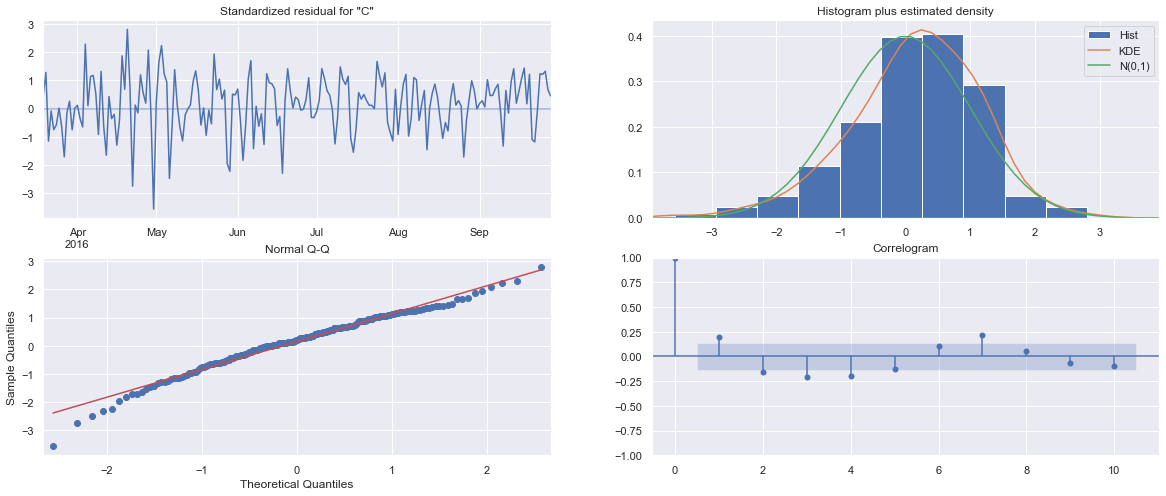

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                      CO   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1081.944
                               + cycle   AIC                           2171.888
                               + AR(1)   BIC                           2184.960
Date:                 Fri, 12 Aug 2022   HQIC                          2177.181
Time:                         18:18:57                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   1.33e-09    542.348   2.45e-12      1.000   -1062.982    1062.982
sigma2.ar         3663.0128    754.069      4.858      0.000    2185.064    5140.962
frequency.cycle      1.5175      0.011    134.424      0.000       1.495       1.540
ar.L1                0.7384      0.068     10.861      0.000       0.605       0.872
===================================================================================
Ljung-Box (L1) (Q):                   8.02   Jarque-Bera (JB):                14.96
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.54
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

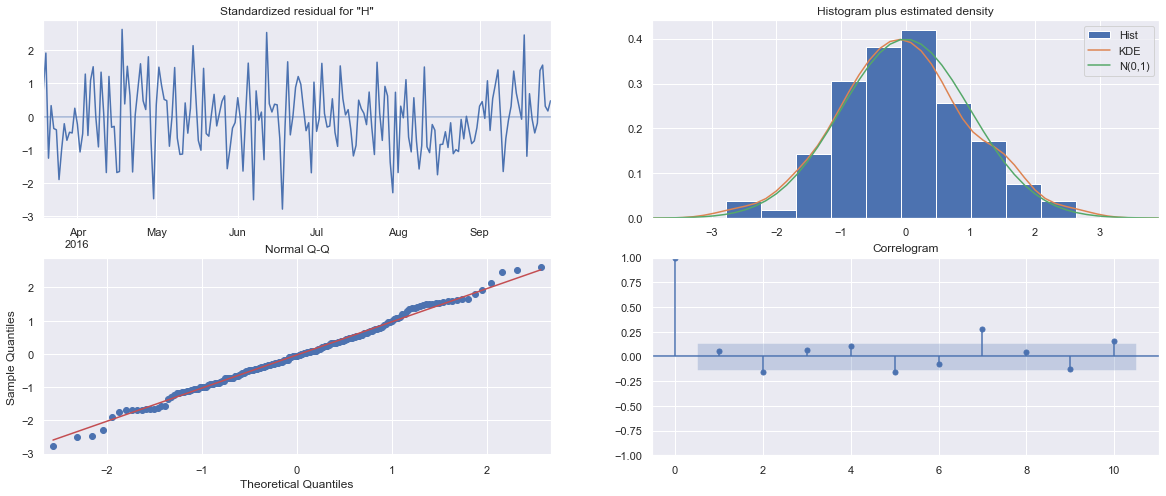

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                      HC   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1096.738
                               + cycle   AIC                           2201.476
                               + AR(1)   BIC                           2214.547
Date:                 Fri, 12 Aug 2022   HQIC                          2206.769
Time:                         18:18:57                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  5.015e-06    917.998   5.46e-09      1.000   -1799.242    1799.242
sigma2.ar         4203.8522   1203.494      3.493      0.000    1845.047    6562.657
frequency.cycle      0.9029      0.002    394.399      0.000       0.898       0.907
ar.L1                0.5991      0.107      5.604      0.000       0.390       0.809
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.46   Prob(JB):                         0.94
Heteroskedasticity (H):               0.75   Skew:                             0.06
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

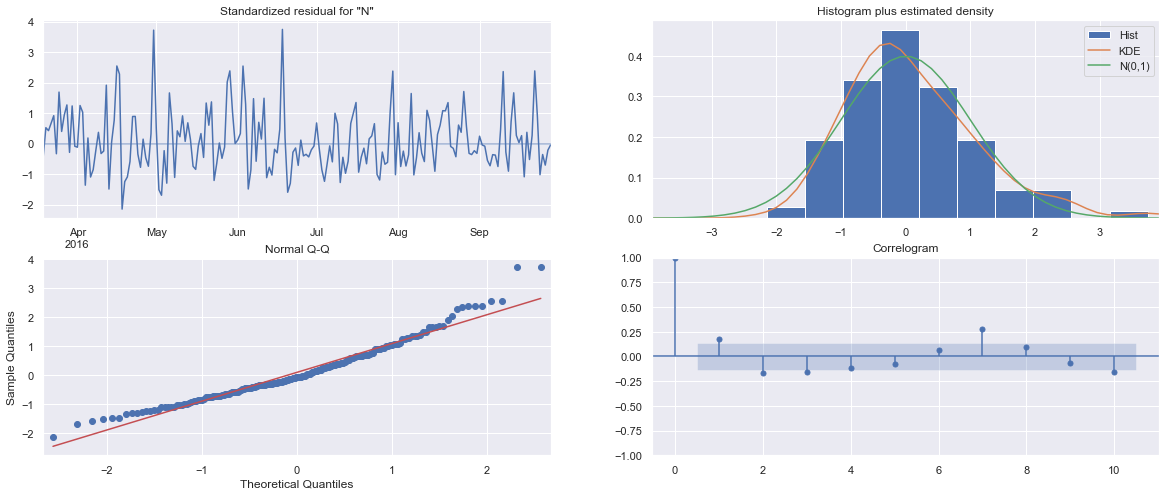

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                     NO2   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1125.687
                               + cycle   AIC                           2259.375
                               + AR(1)   BIC                           2272.446
Date:                 Fri, 12 Aug 2022   HQIC                          2264.668
Time:                         18:18:58                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  5.172e-06   1170.147   4.42e-09      1.000   -2293.447    2293.447
sigma2.ar         5742.5162   1429.269      4.018      0.000    2941.201    8543.831
frequency.cycle      2.3992      0.005    499.071      0.000       2.390       2.409
ar.L1                0.6174      0.100      6.194      0.000       0.422       0.813
===================================================================================
Ljung-Box (L1) (Q):                   6.03   Jarque-Bera (JB):                32.11
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.84
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

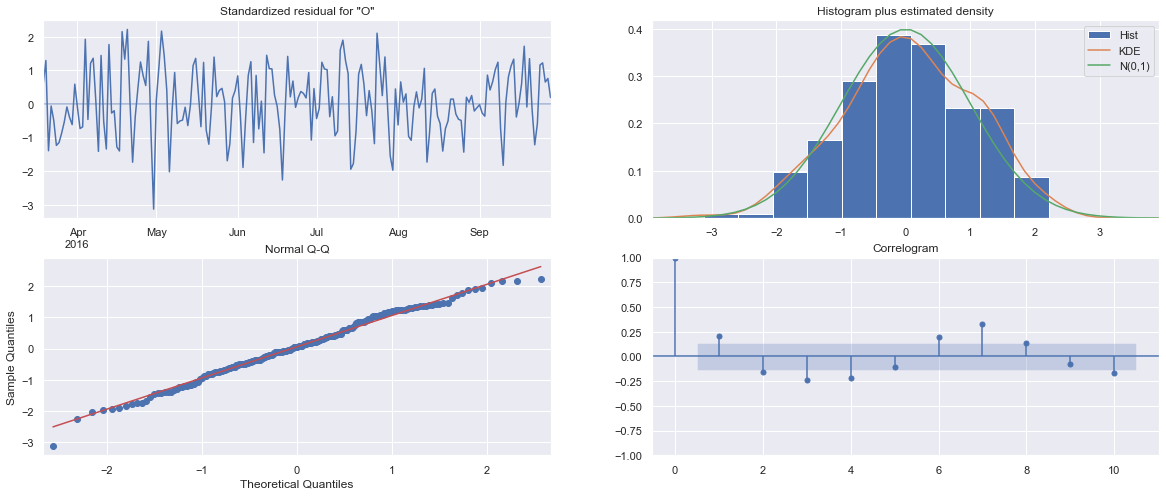

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                      O3   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1227.056
                               + cycle   AIC                           2462.111
                               + AR(1)   BIC                           2475.183
Date:                 Fri, 12 Aug 2022   HQIC                          2467.404
Time:                         18:18:58                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.591e-08   2677.214   5.94e-12      1.000   -5247.243    5247.243
sigma2.ar         1.631e+04   3370.618      4.838      0.000    9699.389    2.29e+04
frequency.cycle      1.6775      0.018     90.781      0.000       1.641       1.714
ar.L1                0.6375      0.085      7.472      0.000       0.470       0.805
===================================================================================
Ljung-Box (L1) (Q):                   8.81   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.00   Prob(JB):                         0.46
Heteroskedasticity (H):               0.55   Skew:                            -0.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
for model in ucm_models:
    ucm_models[model].plot_diagnostics()
    plt.show()
    display(ucm_models[model].summary())

Insights for Unobserved components without exogenous variables:

<u>CO</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

<u>HC</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

<u>NO2</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

<u>O3</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line. However, there is a significant lag at lag 1 indicating some information not being captured by the model, hence it is not a very good fit for the O3 gas

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.12     | 0.00    |
| HC     | 0.12    | 0.18    |
| NO2    | 0.16     | 0.00    |
| O3     | 0.00    | 0.08    |

- Heteroskedascity probability for HC and O3 are more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO and NO2, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for most gases are more than 0.05 except for O3 which means we fail to reject the null hypothesis for those gases and that the model does not show a lack of fit
- Since O3 had a Ljung-Box probability of less than 0.05, we have sufficient evidence to reject null hypothesis and the model shows a lack of fit
___

Unobserved Components with exogenous variables

In [43]:
ucmx_models = defaultdict()
ucmx_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = ucmcv(UnobservedComponents, col, endog[col], exog=exog, ar=1, splits=3, summary=True)
    ucmx_results = ucmx_results.append(format)
    ucmx_models[col] = model
ucmx_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO        114.165762       25.389000    181.536767    79.066053  1441.298688   
HC        114.618387       16.794746    157.285726    72.782456  1502.094978   
NO2       192.462237       43.060505    138.190234    24.412632  1511.510794   
O3        158.522853       20.287495    298.705093   145.553006  1642.056301   

        aic_std     bic_mean     bic_std  
CO   569.932571  1457.871796  572.651784  
HC   612.968857  1518.668085  615.685976  
NO2  606.494055  1528.083901  609.212660  
O3   661.630201  1658.629409  664.343683

Similarly with unobserved components but with exogenous variables, the cross-validated RMSE scores deviate quite a lot thus it is unstable. However, it performed worse with exogenous variables as it has higher cross-validated RMSE scores on average.

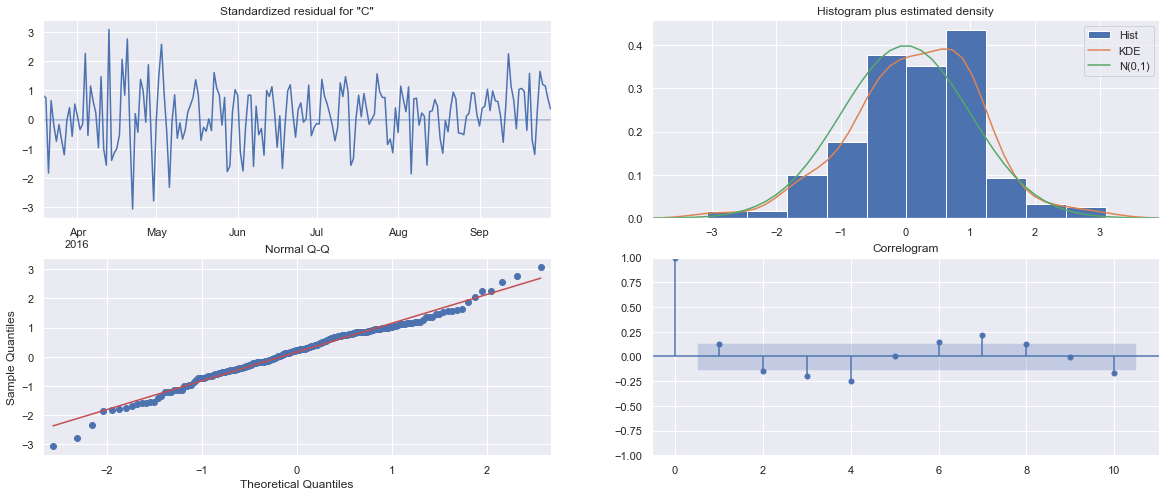

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                      CO   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1062.334
                               + cycle   AIC                           2136.667
                               + AR(1)   BIC                           2156.275
Date:                 Fri, 12 Aug 2022   HQIC                          2144.607
Time:                         18:19:02                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  6.011e-07    384.701   1.56e-09      1.000    -754.000     754.000
sigma2.ar         3008.6401    593.756      5.067      0.000    1844.900    4172.381
frequency.cycle      1.7966      0.006    324.651      0.000       1.786       1.807
ar.L1                0.7955      0.062     12.900      0.000       0.675       0.916
beta.T               9.7970      1.457      6.723      0.000       6.941      12.653
beta.RH              2.9295      0.620      4.725      0.000       1.714       4.145
===================================================================================
Ljung-Box (L1) (Q):                   3.00   Jarque-Bera (JB):                 4.79
Prob(Q):                              0.08   Prob(JB):                         0.09
Heteroskedasticity (H):               0.49   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

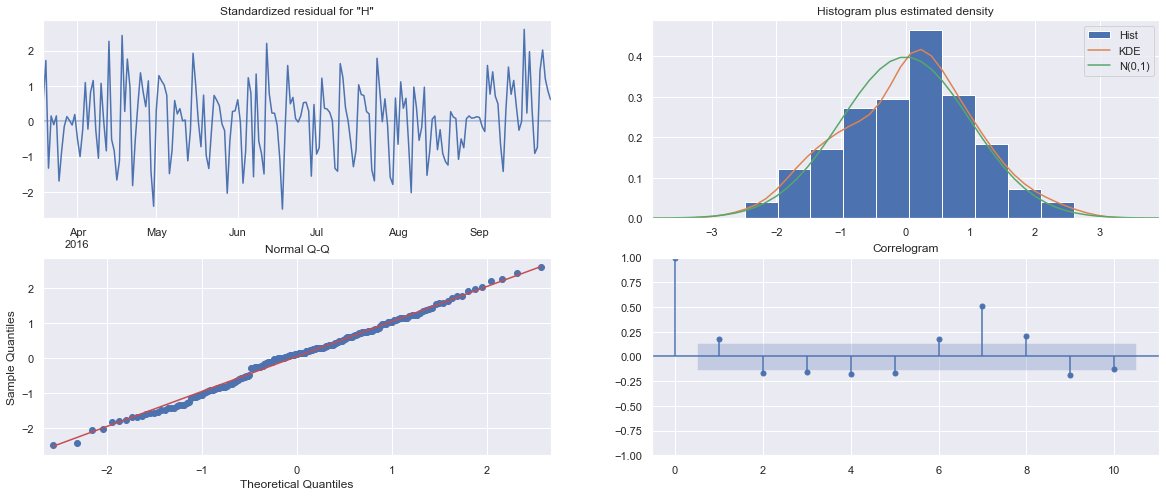

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                      HC   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1120.118
                               + cycle   AIC                           2252.237
                               + AR(1)   BIC                           2271.844
Date:                 Fri, 12 Aug 2022   HQIC                          2260.176
Time:                         18:19:02                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  3.764e-07   1080.853   3.48e-10      1.000   -2118.434    2118.434
sigma2.ar         5391.1565   1486.868      3.626      0.000    2476.948    8305.365
frequency.cycle      1.3333      0.007    178.564      0.000       1.319       1.348
ar.L1                0.6303      0.100      6.302      0.000       0.434       0.826
beta.T               7.5631      1.981      3.817      0.000       3.680      11.446
beta.RH             -0.5017      0.791     -0.634      0.526      -2.052       1.049
===================================================================================
Ljung-Box (L1) (Q):                   6.36   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.01   Prob(JB):                         0.68
Heteroskedasticity (H):               0.84   Skew:                            -0.07
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

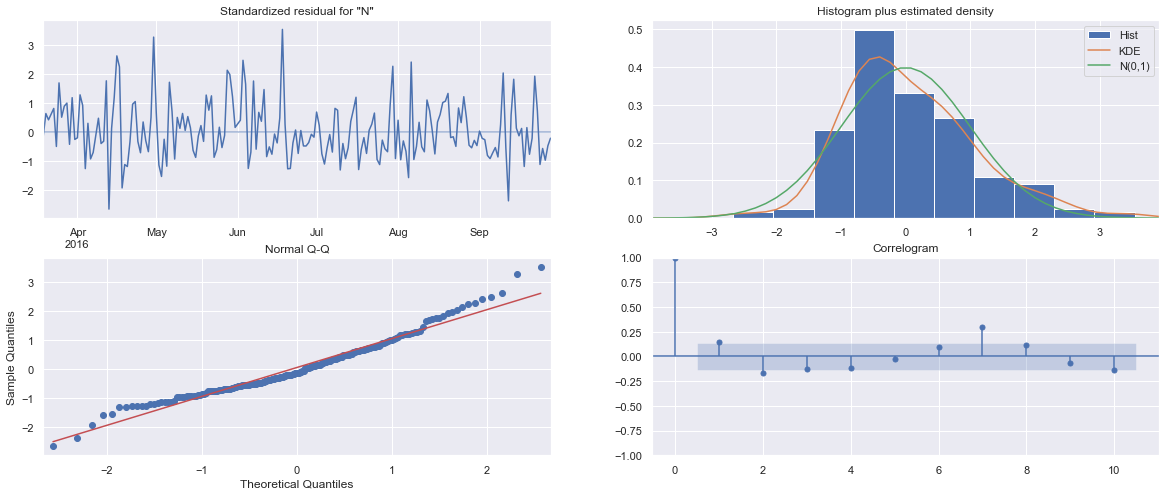

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                     NO2   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1120.072
                               + cycle   AIC                           2252.144
                               + AR(1)   BIC                           2271.751
Date:                 Fri, 12 Aug 2022   HQIC                          2260.083
Time:                         18:19:03                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0006   1236.427   4.92e-07      1.000   -2423.352    2423.353
sigma2.ar         5412.8794   1513.655      3.576      0.000    2446.170    8379.589
frequency.cycle      2.3989      0.005    508.312      0.000       2.390       2.408
ar.L1                0.5724      0.108      5.320      0.000       0.362       0.783
beta.T              -8.2869      1.566     -5.293      0.000     -11.355      -5.218
beta.RH             -1.3505      0.749     -1.802      0.072      -2.819       0.118
===================================================================================
Ljung-Box (L1) (Q):                   4.16   Jarque-Bera (JB):                18.52
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.65
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

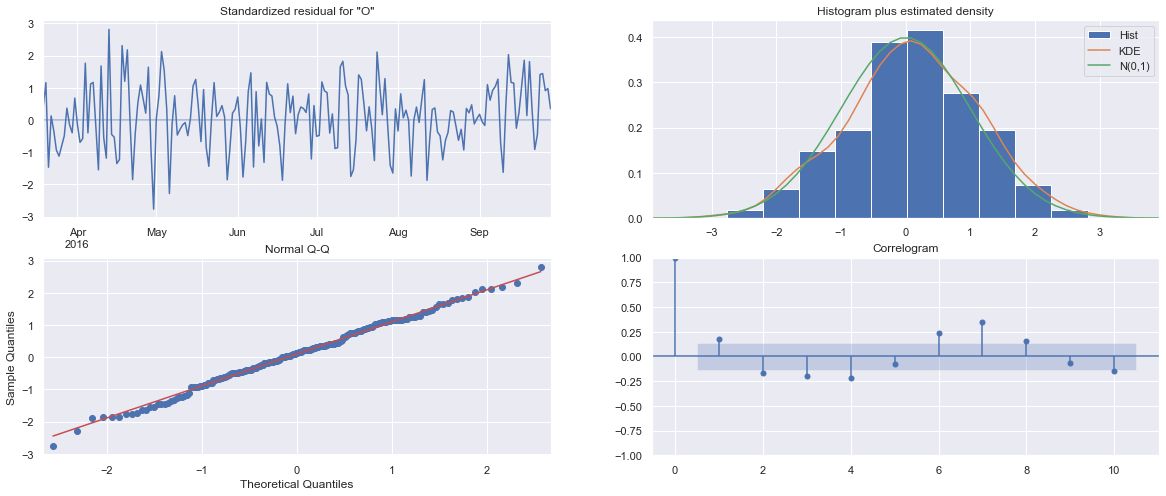

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Unobserved Components Results                         
===============================================================================
Dep. Variable:                      O3   No. Observations:                  198
Model:             deterministic trend   Log Likelihood               -1221.882
                               + cycle   AIC                           2455.765
                               + AR(1)   BIC                           2475.372
Date:                 Fri, 12 Aug 2022   HQIC                          2463.704
Time:                         18:19:03                                         
Sample:                     03-15-2016                                         
                          - 09-28-2016                                         
Covariance Type:                   opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  9.988e-09   2543.875   3.93e-12      1.000   -4985.903    4985.903
sigma2.ar         1.547e+04   3495.104      4.427      0.000    8620.947    2.23e+04
frequency.cycle      1.6745      0.015    112.057      0.000       1.645       1.704
ar.L1                0.6545      0.084      7.829      0.000       0.491       0.818
beta.T              13.2924      3.060      4.343      0.000       7.294      19.291
beta.RH              0.4702      1.249      0.376      0.707      -1.978       2.918
===================================================================================
Ljung-Box (L1) (Q):                   5.89   Jarque-Bera (JB):                 0.51
Prob(Q):                              0.02   Prob(JB):                         0.78
Heteroskedasticity (H):               0.63   Skew:                            -0.10
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
for model in ucmx_models:
    ucmx_models[model].plot_diagnostics()
    plt.show()
    display(ucmx_models[model].summary())

Insights for Unobserved components with exogenous variables:

<u>CO</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

<u>HC</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

<u>NO2</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line. However, there are significant lags at lags 1 and 2 indicating some information not being captured by the model, hence it is not a very good fit for the NO2 gas

<u>O3</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.73     | 0.01    |
| HC     | 0.44    | 0.50    |
| NO2    | 0.00     | 0.06    |
| O3     | 0.32    | 0.09    |

- Heteroskedascity probability for HC, NO2 and O3 are more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for most gases are more than 0.05 except for NO2 which means we fail to reject the null hypothesis for those gases and that the model does not show a lack of fit
- Since NO2 had a Ljung-Box probability of less than 0.05, we have sufficient evidence to reject null hypothesis and the model shows a lack of fit
___

ARIMA

In [45]:
arima_models = defaultdict()
arima_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                    'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = arimacv(ARIMA, col, endog[col], splits=3, order=glob_order[col], summary=True)
    arima_results = arima_results.append(format)
    arima_models[col] = model
arima_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         65.034506        3.727685    121.040700    19.899881  1486.389704   
HC         71.186599        0.584037    115.223887    25.909767  1523.997086   
NO2        81.551768        2.484026    144.093224    33.349811  1550.620642   
O3        126.286345        5.908822    200.368549    56.586042  1671.648435   

        aic_std     bic_mean     bic_std  
CO   576.257116  1497.587202  578.004750  
HC   602.611054  1540.793334  605.228162  
NO2  608.271803  1561.818141  610.018878  
O3   652.563162  1688.444683  655.181809

For the ARIMA model without exogenous variables, the scores of the cross-validated RMSE seems to perform better than the previous models and it also has lower standard deviation in cross-validated RMSE scores.

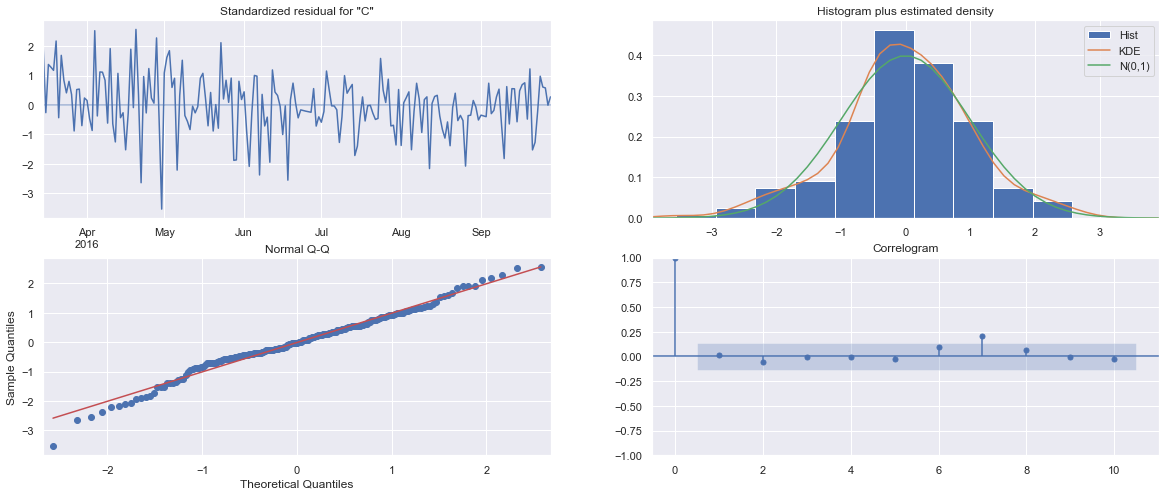

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  198
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1090.178
Date:                Fri, 12 Aug 2022   AIC                           2188.356
Time:                        18:19:05   BIC                           2201.509
Sample:                    03-15-2016   HQIC                          2193.680
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        864.9950     15.492     55.834      0.000     834.631     895.359
ar.L1          0.9832      0.076     12.879      0.000       0.834       1.133
ar.L2         -0.2644      0.072     -3.652      0.000      -0.406      -0.123
sigma2      3528.3275    309.925     11.384      0.000    2920.886    4135.769
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 7.05
Prob(Q):                              0.81   Prob(JB):                         0.03
Heteroskedasticity (H):               0.42   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

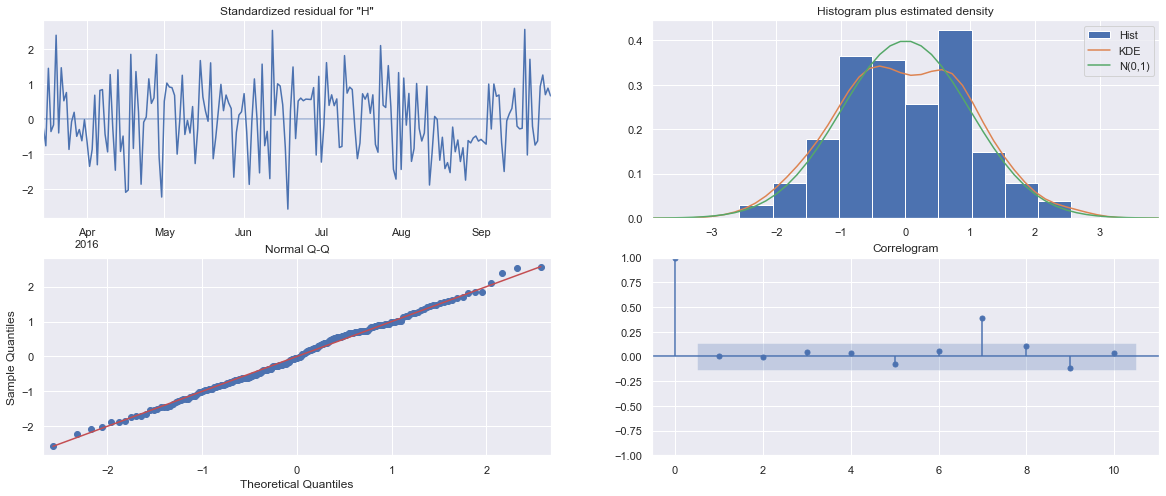

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     HC   No. Observations:                  198
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1125.531
Date:                Fri, 12 Aug 2022   AIC                           2263.062
Time:                        18:19:05   BIC                           2282.792
Sample:                    03-15-2016   HQIC                          2271.048
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        752.5691      9.800     76.796      0.000     733.362     771.776
ar.L1          0.8286      0.400      2.072      0.038       0.045       1.612
ar.L2         -0.3460      0.152     -2.273      0.023      -0.644      -0.048
ma.L1         -0.0334      0.407     -0.082      0.935      -0.831       0.764
ma.L2         -0.0222      0.228     -0.097      0.922      -0.468       0.424
sigma2      5052.7077    579.958      8.712      0.000    3916.010    6189.405
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.97   Prob(JB):                         0.51
Heteroskedasticity (H):               0.87   Skew:                             0.03
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

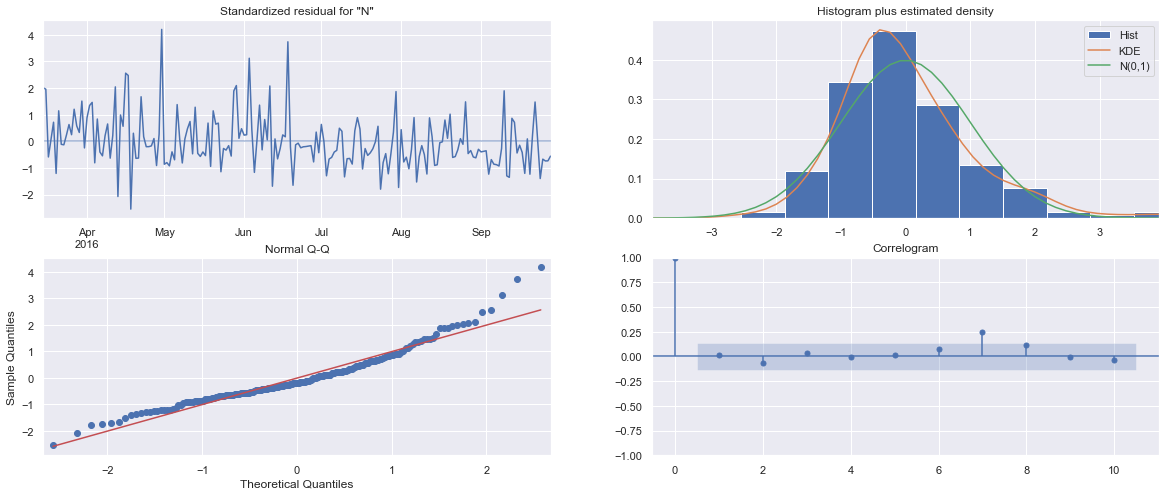

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NO2   No. Observations:                  198
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1142.293
Date:                Fri, 12 Aug 2022   AIC                           2292.586
Time:                        18:19:06   BIC                           2305.739
Sample:                    03-15-2016   HQIC                          2297.910
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        711.9026     18.751     37.966      0.000     675.151     748.654
ar.L1          0.8477      0.072     11.750      0.000       0.706       0.989
ar.L2         -0.2160      0.080     -2.699      0.007      -0.373      -0.059
sigma2      5982.5542    505.889     11.826      0.000    4991.029    6974.079
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                71.96
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             1.03
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

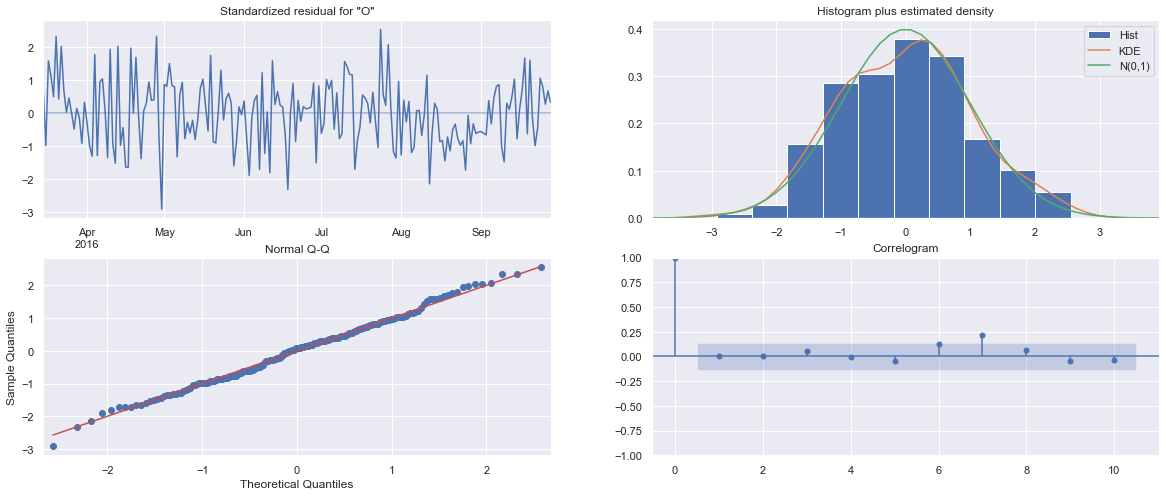

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  198
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1229.062
Date:                Fri, 12 Aug 2022   AIC                           2470.125
Time:                        18:19:06   BIC                           2489.854
Sample:                    03-15-2016   HQIC                          2478.110
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        759.2375     17.681     42.941      0.000     724.583     793.892
ar.L1          0.8576      0.382      2.245      0.025       0.109       1.606
ar.L2         -0.3686      0.182     -2.027      0.043      -0.725      -0.012
ma.L1         -0.0273      0.390     -0.070      0.944      -0.792       0.738
ma.L2          0.0426      0.184      0.232      0.816      -0.317       0.402
sigma2      1.437e+04   1555.778      9.239      0.000    1.13e+04    1.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.97   Prob(JB):                         0.79
Heteroskedasticity (H):               0.60   Skew:                             0.05
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
for model in arima_models:
    arima_models[model].plot_diagnostics()
    plt.show()
    display(arima_models[model].summary())

Insights for ARIMA:

- For all of the gases, the mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line
- However, there seems to be a significant lag for all the gases at lag 7. This could mean that the weekly seasonality established earlier is failed to be captured by the ARIMA model

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.81     | 0.00    |
| HC     | 0.97    | 0.59    |
| NO2    | 0.84     | 0.02    |
| O3     | 0.97    | 0.04    |

- Heteroskedascity probability for HC is more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO, NO2 and O3, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for all the gases are more than 0.05 which means we fail to reject the null hypothesis and that the model does not show a lack of fit
___

ARIMAX

In [47]:
arimax_models = defaultdict()
arimax_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                    'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = arimacv(ARIMA, col, endog[col], exog=exog, splits=3, order=glob_order[col], summary=True)
    arimax_results = arimax_results.append(format)
    arimax_models[col] = model
arimax_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         63.765756        3.970984    141.746004    17.417967  1482.102728   
HC         67.770820        2.120612    142.192221    21.375130  1518.369389   
NO2        74.599895        2.090913    135.127284    52.109940  1532.946217   
O3        126.079464        5.369161    237.176909    38.803816  1675.338608   

        aic_std     bic_mean     bic_std  
CO   571.767184  1498.898976  574.388653  
HC   607.016027  1540.764386  610.504587  
NO2  601.174197  1549.742464  603.792817  
O3   653.076412  1697.733605  656.568622

ARIMAX, the ARIMA model with exogenous variables seem to perform worse than without exogenous variables.

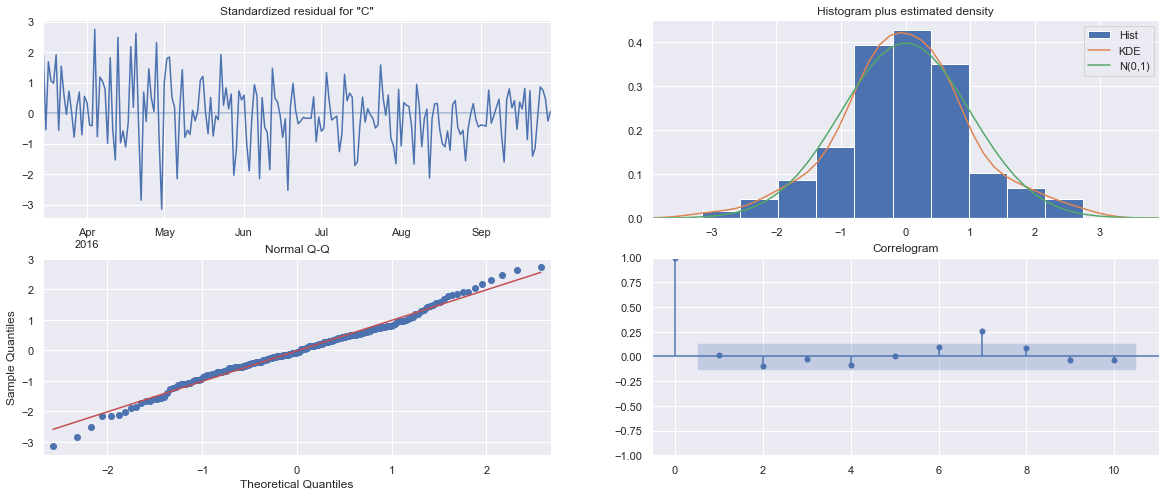

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  198
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1083.311
Date:                Fri, 12 Aug 2022   AIC                           2178.623
Time:                        18:19:09   BIC                           2198.352
Sample:                    03-15-2016   HQIC                          2186.609
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        646.9638     45.657     14.170      0.000     557.478     736.449
T              5.0362      1.451      3.470      0.001       2.192       7.880
RH             2.3866      0.646      3.696      0.000       1.121       3.652
ar.L1          0.9874      0.083     11.846      0.000       0.824       1.151
ar.L2         -0.1917      0.082     -2.350      0.019      -0.352      -0.032
sigma2      3289.4825    297.380     11.062      0.000    2706.629    3872.336
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.29
Prob(Q):                              0.87   Prob(JB):                         0.19
Heteroskedasticity (H):               0.37   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

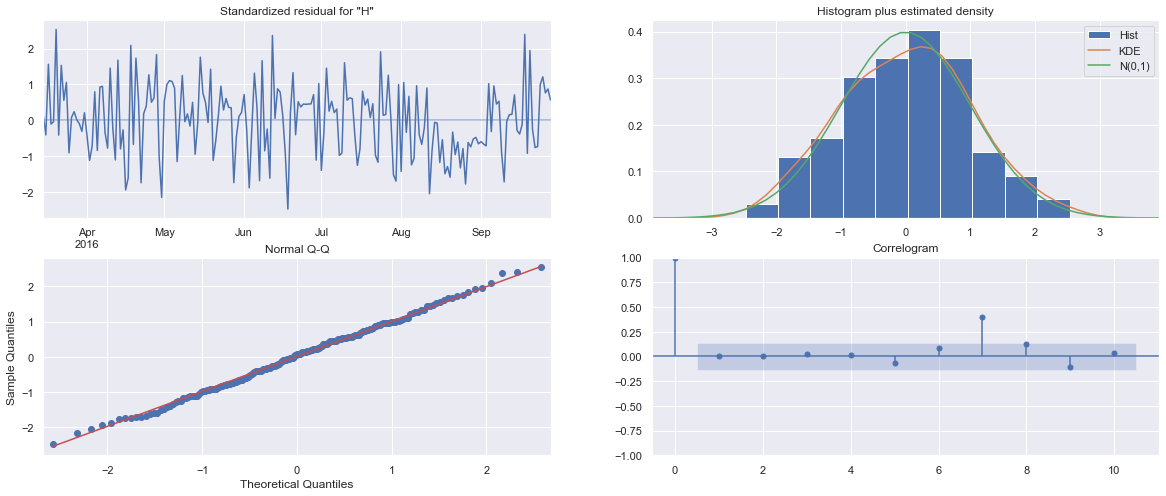

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     HC   No. Observations:                  198
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1123.815
Date:                Fri, 12 Aug 2022   AIC                           2263.630
Time:                        18:19:09   BIC                           2289.936
Sample:                    03-15-2016   HQIC                          2274.278
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        734.1205     57.021     12.875      0.000     622.362     845.879
T              2.2475      1.518      1.481      0.139      -0.727       5.222
RH            -0.8251      0.835     -0.989      0.323      -2.461       0.811
ar.L1          0.7806      0.580      1.345      0.179      -0.357       1.918
ar.L2         -0.2843      0.218     -1.306      0.192      -0.711       0.143
ma.L1          0.0374      0.587      0.064      0.949      -1.113       1.188
ma.L2         -0.0355      0.299     -0.119      0.905      -0.621       0.550
sigma2      5078.3642    592.483      8.571      0.000    3917.120    6239.609
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.19
Prob(Q):                              0.95   Prob(JB):                         0.55
Heteroskedasticity (H):               0.89   Skew:                             0.03
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

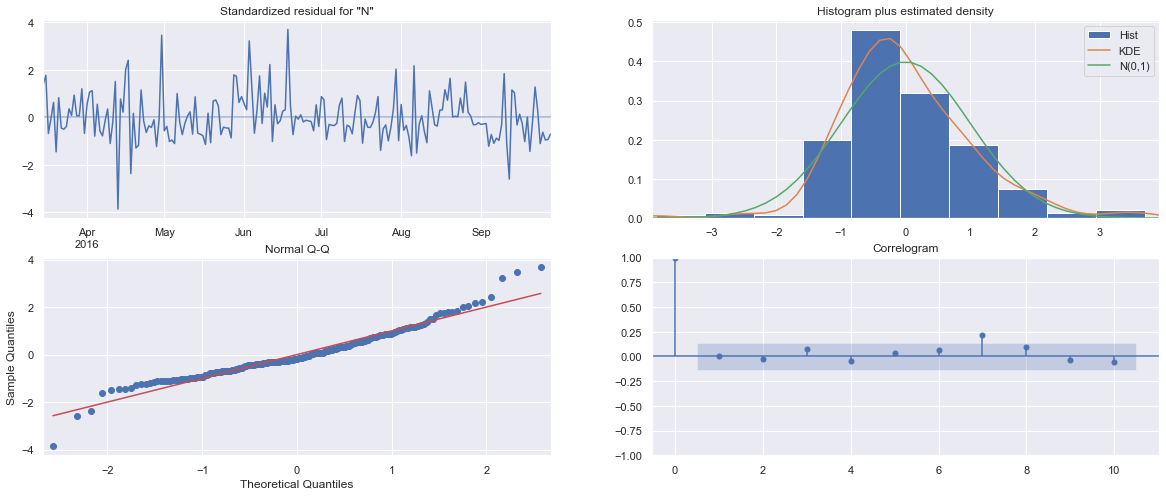

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NO2   No. Observations:                  198
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1128.292
Date:                Fri, 12 Aug 2022   AIC                           2268.584
Time:                        18:19:10   BIC                           2288.314
Sample:                    03-15-2016   HQIC                          2276.570
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        995.6637     35.138     28.336      0.000     926.794    1064.533
T            -10.0125      1.139     -8.788      0.000     -12.245      -7.780
RH            -1.1744      0.641     -1.833      0.067      -2.430       0.082
ar.L1          0.6892      0.069      9.945      0.000       0.553       0.825
ar.L2         -0.2440      0.078     -3.135      0.002      -0.397      -0.091
sigma2      5200.8579    412.405     12.611      0.000    4392.559    6009.157
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                45.99
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.52
Prob(H) (two-sided):                  0.16   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

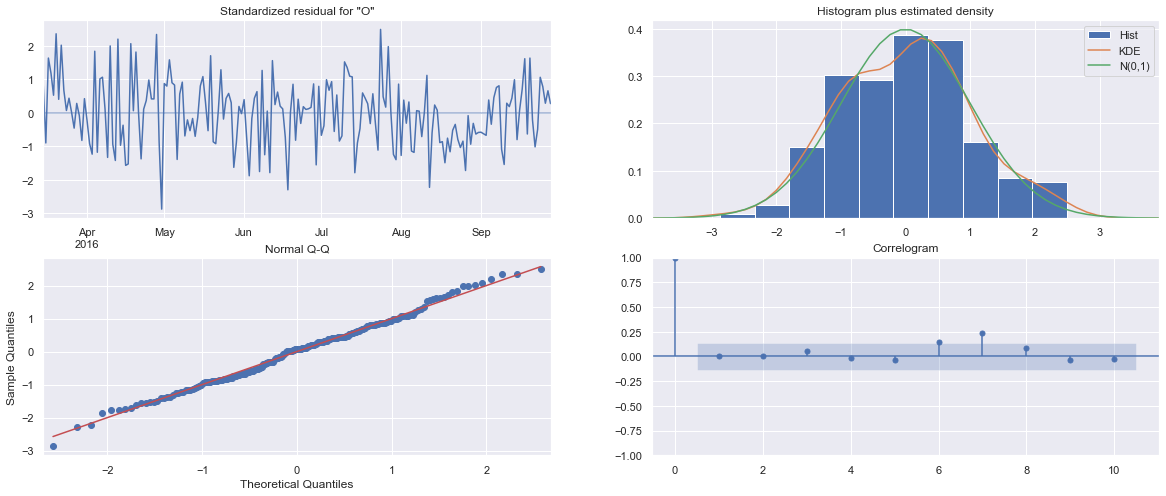

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  198
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1228.931
Date:                Fri, 12 Aug 2022   AIC                           2473.861
Time:                        18:19:10   BIC                           2500.167
Sample:                    03-15-2016   HQIC                          2484.509
                         - 09-28-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        725.0110     86.476      8.384      0.000     555.520     894.502
T              1.7136      2.311      0.741      0.458      -2.816       6.243
RH            -0.1353      1.343     -0.101      0.920      -2.767       2.496
ar.L1          0.8291      0.439      1.887      0.059      -0.032       1.690
ar.L2         -0.3364      0.208     -1.618      0.106      -0.744       0.071
ma.L1          0.0099      0.449      0.022      0.982      -0.870       0.889
ma.L2          0.0395      0.201      0.196      0.844      -0.355       0.434
sigma2      1.435e+04   1569.104      9.148      0.000    1.13e+04    1.74e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.99   Prob(JB):                         0.78
Heteroskedasticity (H):               0.59   Skew:                             0.07
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
for model in arimax_models:
    arimax_models[model].plot_diagnostics()
    plt.show()
    display(arimax_models[model].summary())

Insights for ARIMAX:

- For all gases, he mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line
- However, similar to ARIMA, there is a significant lag at lag 7 indicating weekly seasonality not being captured by the ARIMAX model

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.87     | 0.00    |
| HC     | 0.95    | 0.63    |
| NO2    | 0.93     | 0.16    |
| O3     | 0.99    | 0.04    |

- Heteroskedascity probability for HC and NO2 are more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO and O3, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for all the gases are more than 0.05 which means we fail to reject the null hypothesis and that the model does not show a lack of fit

Overall for ARIMA and ARIMAX, since there is a significant at lag 7 in the correlograms, it means weekly seasonality has been failed to be captured by the ARIMA model. Hence, I will try the ARIMA model with seasonal component to test for SARIMA and SARIMAX.
___

SARIMA

In [49]:
sarima_models = defaultdict()
sarima_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                    'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = arimacv(SARIMAX, col, endog[col], order=glob_order[col], s_order=seasonal_order[col], summary=True)
    sarima_results = sarima_results.append(format)
    sarima_models[col] = model
sarima_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO        120.946755       25.539930    180.617267    84.907757  1507.450649   
HC         95.848401       15.903187    102.587213    17.917536  1507.700906   
NO2       121.053535       20.921635    176.928416   118.362600  1563.346831   
O3        151.413005       19.470597    184.196350    50.113499  1677.670951   

        aic_std     bic_mean     bic_std  
CO   632.261453  1526.877267  635.731545  
HC   636.113874  1535.453216  641.071773  
NO2  657.176943  1585.548679  661.148641  
O3   710.297649  1705.423262  715.249330

SARIMA showed that the cross-validated RMSE returned quite good results but have high standard deviation in cross-validated RMSE scores, suggesting the model is unstable.

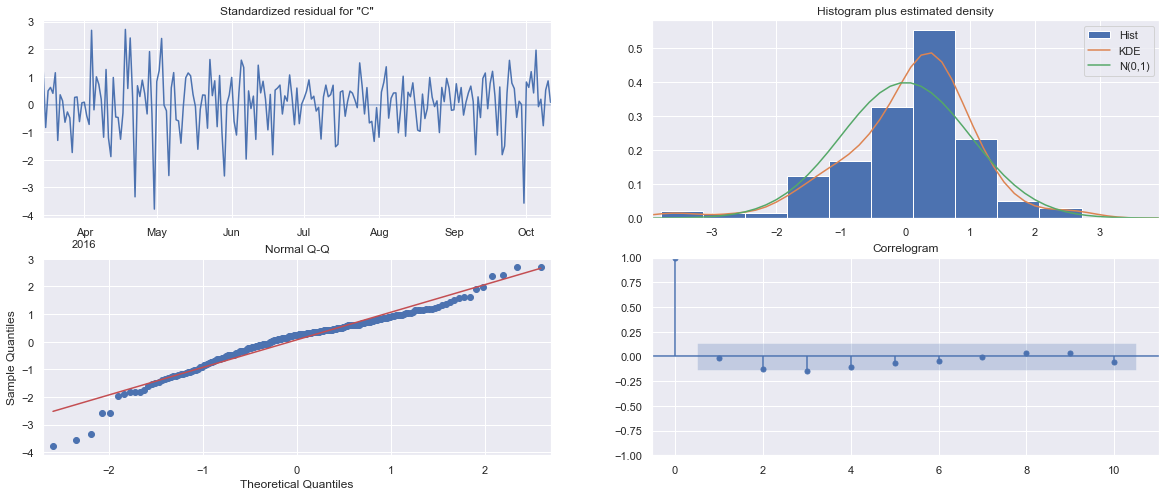

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  211
Model:             SARIMAX(2, 0, 0)x(4, 0, 0, 7)   Log Likelihood               -1170.742
Date:                           Fri, 12 Aug 2022   AIC                           2355.485
Time:                                   18:19:30   BIC                           2378.948
Sample:                               03-15-2016   HQIC                          2364.969
                                    - 10-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0061      0.087     11.528      0.000       0.835       1.177
ar.L2         -0.0167      0.087     -0.192      0.848      -0.188       0.154
ar.S.L7        0.1281      0.080      1.606      0.108      -0.028       0.284
ar.S.L14       0.0940      0.056      1.694      0.090      -0.015       0.203
ar.S.L21       0.0960      0.074      1.301      0.193      -0.049       0.241
ar.S.L28       0.2744      0.083      3.306      0.001       0.112       0.437
sigma2      3710.4861    309.079     12.005      0.000    3104.702    4316.270
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                51.14
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.74
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

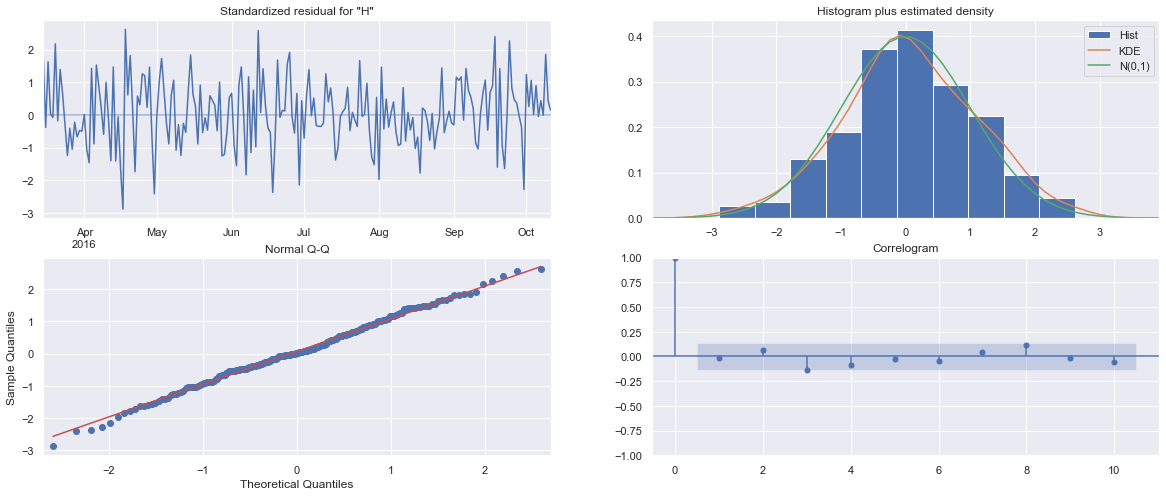

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                           HC   No. Observations:                  211
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1170.271
Date:                                      Fri, 12 Aug 2022   AIC                           2360.542
Time:                                              18:19:31   BIC                           2394.061
Sample:                                          03-15-2016   HQIC                          2374.091
                                               - 10-11-2016                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3989      0.144      9.737      0.000       1.117       1.680
ar.L2         -0.4067      0.140     -2.914      0.004      -0.680      -0.133
ma.L1         -0.6337      0.146     -4.345      0.000      -0.920      -0.348
ma.L2         -0.2180      0.095     -2.300      0.021      -0.404      -0.032
ar.S.L7        0.9999      0.005    210.988      0.000       0.991       1.009
ma.S.L7       -0.9349      0.227     -4.121      0.000      -1.380      -0.490
ma.S.L14      -0.0782      0.096     -0.817      0.414      -0.266       0.110
ma.S.L21       0.0012      0.107      0.011      0.991      -0.209       0.212
ma.S.L28       0.0271      0.085      0.318      0.751      -0.140       0.194
sigma2      3339.8092    732.159      4.562      0.000    1904.804    4774.814
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.88   Prob(JB):                         0.95
Heteroskedasticity (H):               0.66   Skew:                            -0.04
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

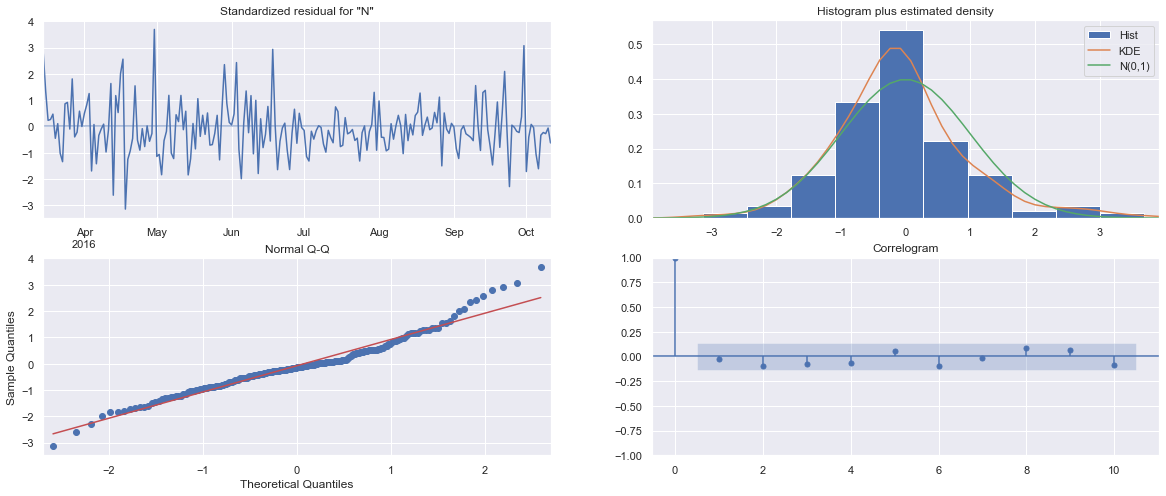

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 NO2   No. Observations:                  211
Model:             SARIMAX(2, 0, 0)x(4, 0, [1], 7)   Log Likelihood               -1212.520
Date:                             Fri, 12 Aug 2022   AIC                           2441.041
Time:                                     18:19:31   BIC                           2467.856
Sample:                                 03-15-2016   HQIC                          2451.880
                                      - 10-11-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7985      0.066     12.059      0.000       0.669       0.928
ar.L2         -0.0500      0.073     -0.687      0.492      -0.193       0.093
ar.S.L7        0.8902      0.111      7.994      0.000       0.672       1.108
ar.S.L14      -0.0074      0.079     -0.094      0.925      -0.162       0.147
ar.S.L21       0.0216      0.093      0.233      0.816      -0.160       0.203
ar.S.L28       0.0933      0.099      0.939      0.348      -0.101       0.288
ma.S.L7       -0.7982      0.090     -8.912      0.000      -0.974      -0.623
sigma2      5113.9652    455.661     11.223      0.000    4220.885    6007.045
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                36.46
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                             0.61
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

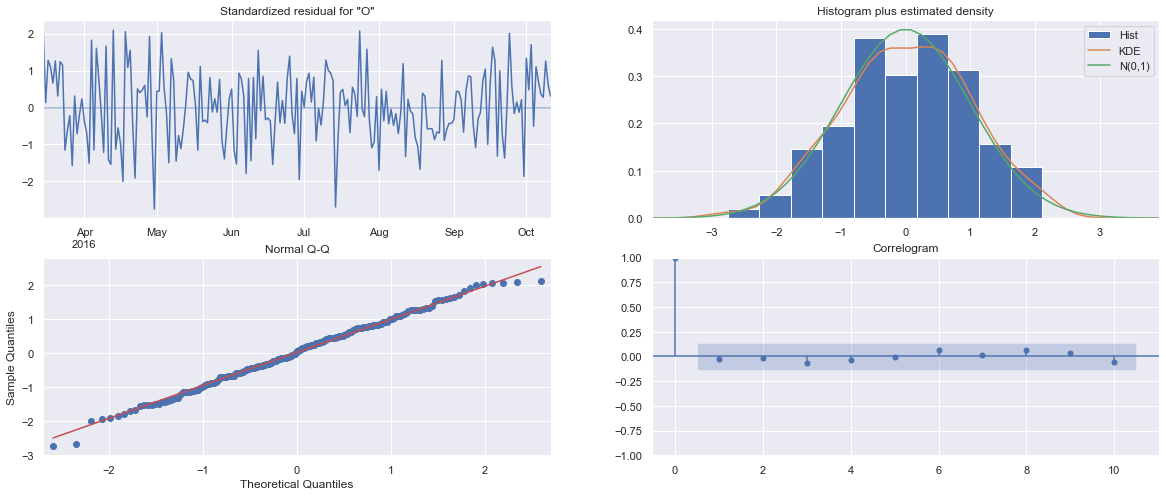

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  O3   No. Observations:                  211
Model:             SARIMAX(2, 0, 2)x(4, 0, [1], 7)   Log Likelihood               -1306.598
Date:                             Fri, 12 Aug 2022   AIC                           2633.195
Time:                                     18:19:32   BIC                           2666.714
Sample:                                 03-15-2016   HQIC                          2646.744
                                      - 10-11-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3367      0.160     -2.106      0.035      -0.650      -0.023
ar.L2          0.6597      0.141      4.694      0.000       0.384       0.935
ma.L1          1.1530      0.191      6.034      0.000       0.778       1.527
ma.L2          0.1564      0.100      1.567      0.117      -0.039       0.352
ar.S.L7        1.0698      0.094     11.394      0.000       0.886       1.254
ar.S.L14      -0.0591      0.111     -0.535      0.593      -0.276       0.158
ar.S.L21      -0.0182      0.120     -0.151      0.880      -0.254       0.218
ar.S.L28       0.0075      0.095      0.079      0.937      -0.179       0.194
ma.S.L7       -0.9724      0.122     -7.943      0.000      -1.212      -0.732
sigma2      1.283e+04   8.68e-06   1.48e+09      0.000    1.28e+04    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.66   Prob(JB):                         0.55
Heteroskedasticity (H):               0.53   Skew:                            -0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.75e+25. Standard errors may be unstable.
"""

In [50]:
for model in sarima_models:
    sarima_models[model].plot_diagnostics()
    plt.show()
    display(sarima_models[model].summary())

Insights for SARIMA:

- For all the gases, the mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a relatively good fit

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.87     | 0.01    |
| HC     | 0.88    | 0.09    |
| NO2    | 0.74     | 0.01    |
| O3     | 0.66    | 0.01    |

- Heteroskedascity probability for HC is more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO, NO2 and O3, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for all the gases are more than 0.05 which means we fail to reject the null hypothesis and that the model does not show a lack of fit
___

SARIMAX

In [51]:
sarimax_models = defaultdict()
sarimax_results = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                    'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    format, model = arimacv(SARIMAX, col, endog[col], exog=exog, order=glob_order[col], s_order=seasonal_order[col], summary=True)
    sarimax_results = sarimax_results.append(format)
    sarimax_models[col] = model
sarimax_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         92.813604       15.678383    142.902894    86.890159  1489.614329   
HC         75.390448        1.330618    147.632976    33.351177  1497.423377   
NO2       125.344037       16.749246    216.901066   159.440127  1560.473395   
O3        124.046241        7.557468    286.254948    60.128870  1669.960695   

        aic_std     bic_mean     bic_std  
CO   620.156962  1514.591408  624.620842  
HC   624.996043  1530.726150  630.935501  
NO2  657.917701  1588.225706  662.873935  
O3   705.626248  1703.263468  711.574375

Similar to the relationship between ARIMA and ARIMAX, SARIMAX, seem to perform worse than SARIMA which is without the exogenous variables. However, we can see that the standard deviation for the cross-validated RMSE scores are much lower indicating a more stable model. 

Furthermore, more can be done to improve the model's performance such as feature engineering on the exogenous variables.

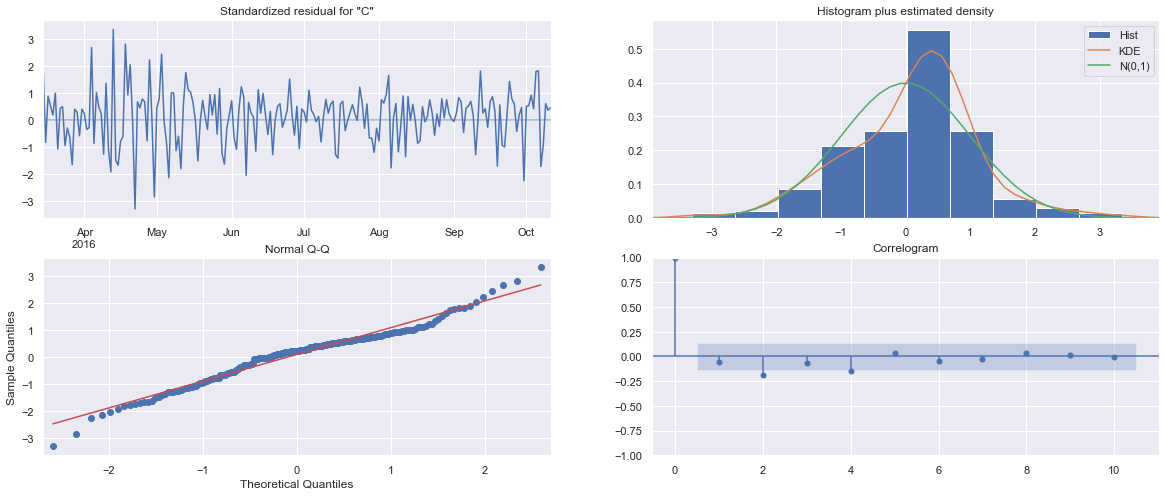

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  211
Model:             SARIMAX(2, 0, 0)x(4, 0, 0, 7)   Log Likelihood               -1150.119
Date:                           Fri, 12 Aug 2022   AIC                           2318.238
Time:                                   18:19:56   BIC                           2348.405
Sample:                               03-15-2016   HQIC                          2330.432
                                    - 10-11-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              9.9379      1.161      8.559      0.000       7.662      12.214
RH             3.0659      0.511      6.003      0.000       2.065       4.067
ar.L1          0.9067      0.077     11.812      0.000       0.756       1.057
ar.L2          0.0543      0.077      0.708      0.479      -0.096       0.205
ar.S.L7        0.2316      0.068      3.399      0.001       0.098       0.365
ar.S.L14       0.0862      0.062      1.385      0.166      -0.036       0.208
ar.S.L21       0.1212      0.077      1.565      0.118      -0.031       0.273
ar.S.L28       0.2843      0.078      3.651      0.000       0.132       0.437
sigma2      3084.9584    272.635     11.315      0.000    2550.603    3619.314
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                10.29
Prob(Q):                              0.44   Prob(JB):                         0.01
Heteroskedasticity (H):               0.45   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

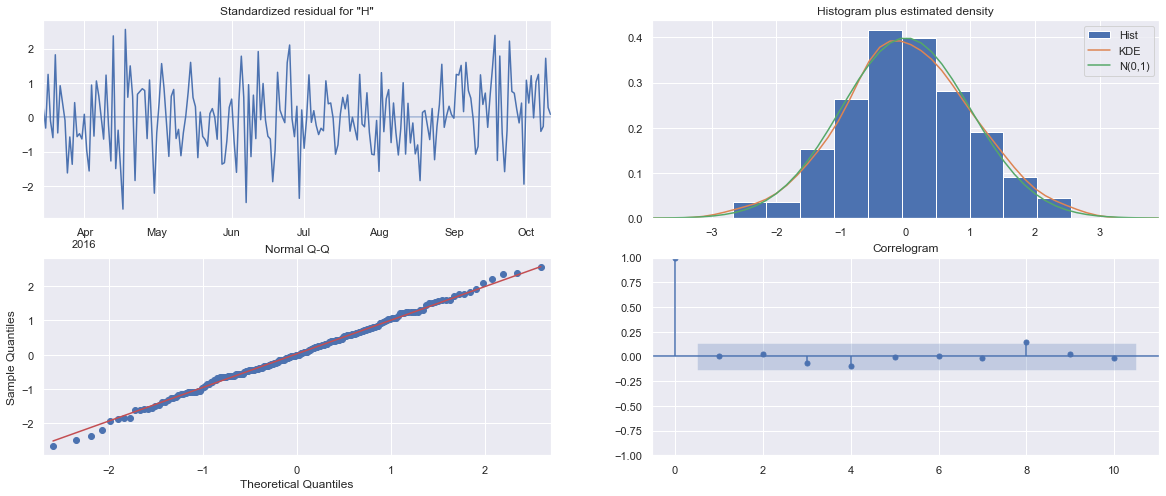

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                           HC   No. Observations:                  211
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1159.051
Date:                                      Fri, 12 Aug 2022   AIC                           2342.102
Time:                                              18:19:57   BIC                           2382.324
Sample:                                          03-15-2016   HQIC                          2358.360
                                               - 10-11-2016                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              7.7539      1.695      4.574      0.000       4.431      11.077
RH            -0.4997      0.559     -0.893      0.372      -1.596       0.596
ar.L1          1.4242      0.155      9.201      0.000       1.121       1.728
ar.L2         -0.4252      0.154     -2.754      0.006      -0.728      -0.123
ma.L1         -0.7301      0.169     -4.325      0.000      -1.061      -0.399
ma.L2         -0.1429      0.125     -1.142      0.254      -0.388       0.102
ar.S.L7        0.9990      0.004    239.170      0.000       0.991       1.007
ma.S.L7       -0.8435      0.100     -8.427      0.000      -1.040      -0.647
ma.S.L14      -0.0885      0.093     -0.952      0.341      -0.271       0.094
ma.S.L21      -0.0318      0.107     -0.296      0.767      -0.242       0.179
ma.S.L28       0.0054      0.088      0.062      0.951      -0.167       0.177
sigma2      3241.9218    370.434      8.752      0.000    2515.885    3967.959
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.95   Prob(JB):                         0.98
Heteroskedasticity (H):               0.84   Skew:                            -0.01
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

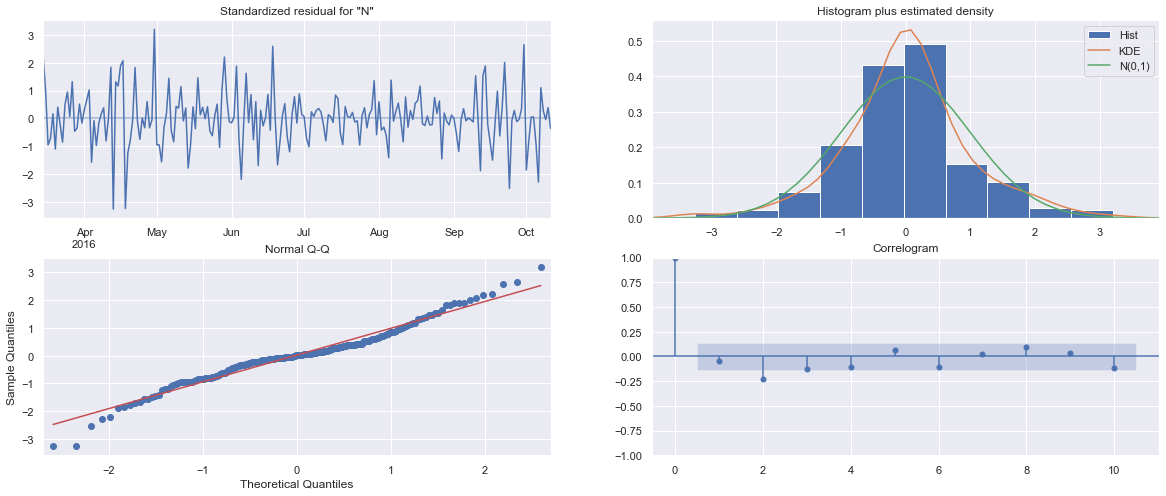

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 NO2   No. Observations:                  211
Model:             SARIMAX(2, 0, 0)x(4, 0, [1], 7)   Log Likelihood               -1212.475
Date:                             Fri, 12 Aug 2022   AIC                           2444.949
Time:                                     18:19:57   BIC                           2478.468
Sample:                                 03-15-2016   HQIC                          2458.498
                                      - 10-11-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -7.1560      1.589     -4.504      0.000     -10.270      -4.042
RH            -0.6854      0.731     -0.938      0.348      -2.117       0.747
ar.L1          0.8395      0.075     11.198      0.000       0.693       0.986
ar.L2          0.0910      0.077      1.176      0.240      -0.061       0.243
ar.S.L7        0.8613      0.131      6.589      0.000       0.605       1.117
ar.S.L14       0.0730      0.094      0.775      0.438      -0.111       0.257
ar.S.L21      -0.0139      0.116     -0.119      0.905      -0.242       0.214
ar.S.L28       0.0706      0.119      0.594      0.552      -0.162       0.304
ma.S.L7       -0.8348      0.099     -8.440      0.000      -1.029      -0.641
sigma2      5749.6246    536.819     10.711      0.000    4697.478    6801.771
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                19.69
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.02
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

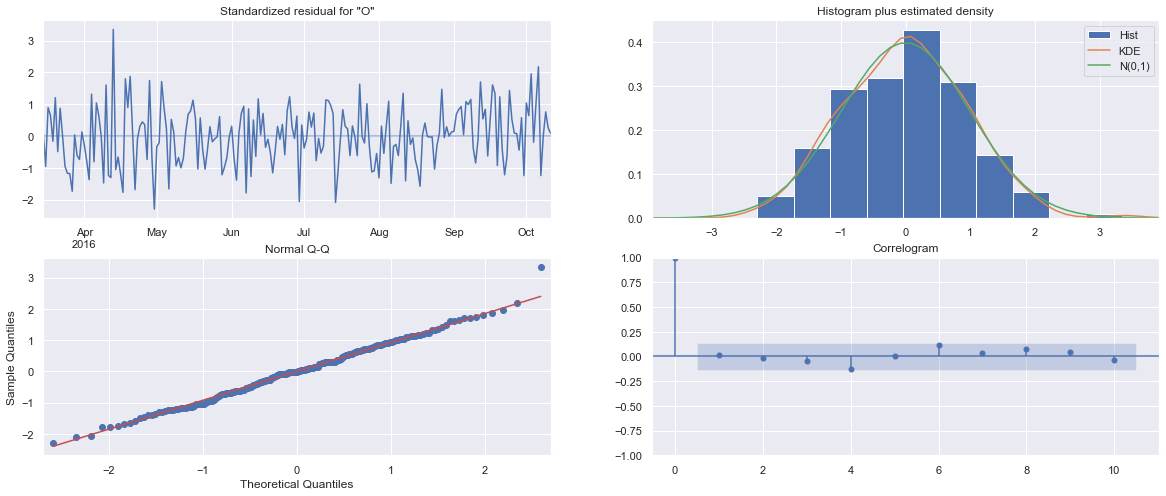

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  O3   No. Observations:                  211
Model:             SARIMAX(2, 0, 2)x(4, 0, [1], 7)   Log Likelihood               -1295.471
Date:                             Fri, 12 Aug 2022   AIC                           2614.941
Time:                                     18:19:58   BIC                           2655.164
Sample:                                 03-15-2016   HQIC                          2631.200
                                      - 10-11-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             20.2779      3.219      6.300      0.000      13.969      26.587
RH             1.4302      1.209      1.183      0.237      -0.939       3.800
ar.L1          1.2293      0.227      5.406      0.000       0.784       1.675
ar.L2         -0.2300      0.227     -1.013      0.311      -0.675       0.215
ma.L1         -0.5540      0.222     -2.497      0.013      -0.989      -0.119
ma.L2         -0.2562      0.149     -1.722      0.085      -0.548       0.035
ar.S.L7        1.0779      0.091     11.863      0.000       0.900       1.256
ar.S.L14      -0.0353      0.129     -0.275      0.784      -0.288       0.217
ar.S.L21      -0.0442      0.134     -0.329      0.742      -0.307       0.219
ar.S.L28       0.0012      0.099      0.012      0.991      -0.192       0.195
ma.S.L7       -0.9846      0.045    -21.819      0.000      -1.073      -0.896
sigma2      1.338e+04   1808.140      7.399      0.000    9834.034    1.69e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.82
Prob(Q):                              0.88   Prob(JB):                         0.66
Heteroskedasticity (H):               0.68   Skew:                             0.15
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
for model in sarimax_models:
    sarimax_models[model].plot_diagnostics()
    plt.show()
    display(sarimax_models[model].summary())

Insights for SARIMAX:

<u>CO</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line, However, there is a significant lag at lag 2 suggesting that the model does not capture some information

<u>HC</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line. However, there is a significant lag at lag 8 suggesting that there is still some information left in the residuals that can be used to compute forecasts 

<u>NO2</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line. However, similar to CO, there is also a significant lag at lag 2 in the correlogram, indicating some information in the residuals that should still be used to compute forecasts

<u>O3</u>
- Mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and there are no significant lags in the correlogram, indicating a good fit

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.44     | 0.00    |
| HC     | 0.95    | 0.48    |
| NO2    | 0.52     | 0.11    |
| O3     | 0.88    | 0.10    |

- Heteroskedascity probability for HC, NO2 and O3 are more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for all the gases are more than 0.05 except for O3 which means we fail to reject the null hypothesis and that the model does not show a lack of fit
___

VARMA

In [53]:
varma_results  = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                    'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
format, varma_model = varmaxcv(VARMAX, 'Scores', endog, splits=3, summary=True)
varma_results = varma_results.append(format)
varma_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std  \
Scores        90.827682         1.18331     145.27213    32.737111   

           aic_mean      aic_std    bic_mean      bic_std  
Scores  5815.117082  2343.199639  5899.09832  2356.278361

Using the VARMAX model, without the exogenous variables, VARMA performs quite well with a low cross-validated RMSE score of 145.27213 and considerably low standard deviation in cross-validated RMSE scores of 32.737111.

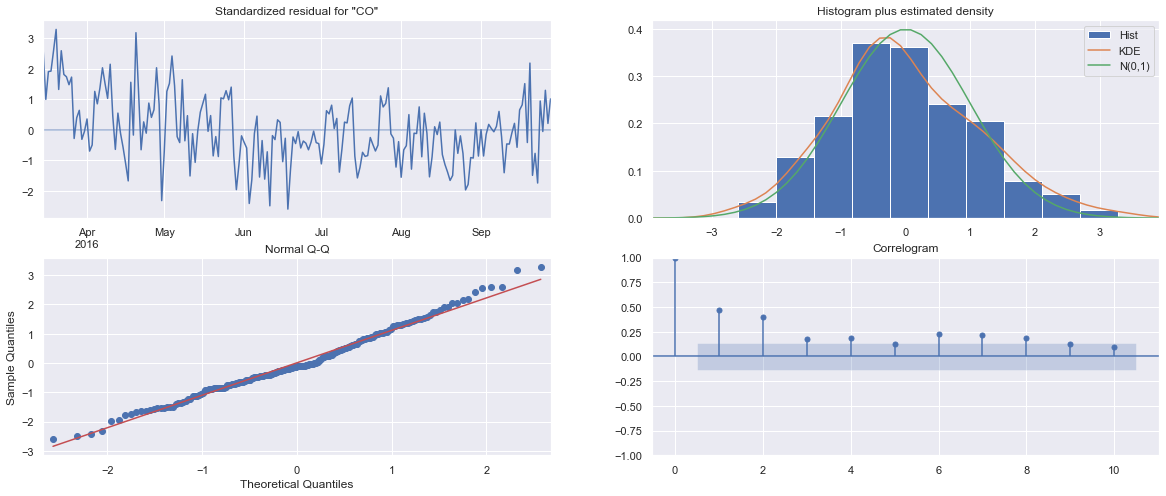

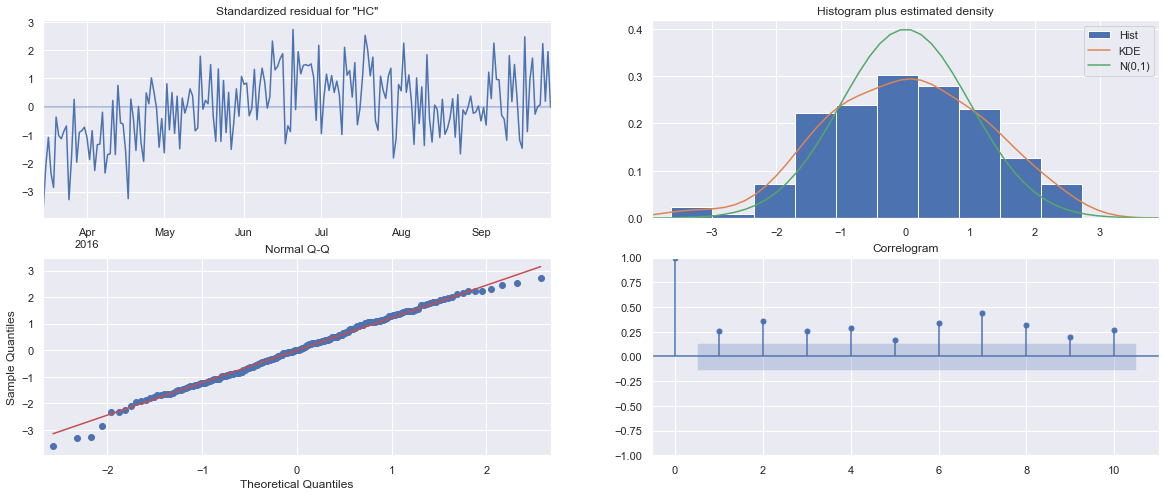

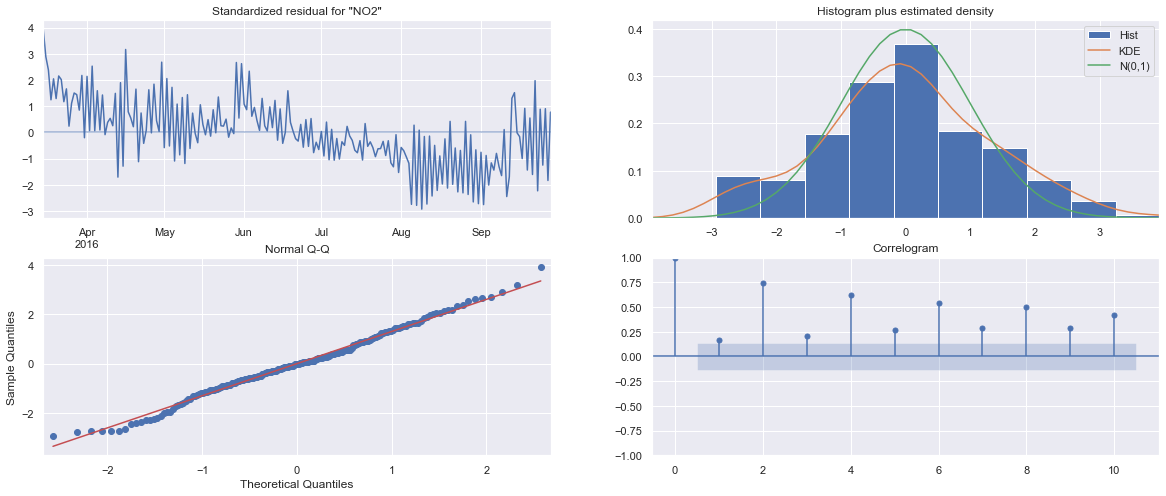

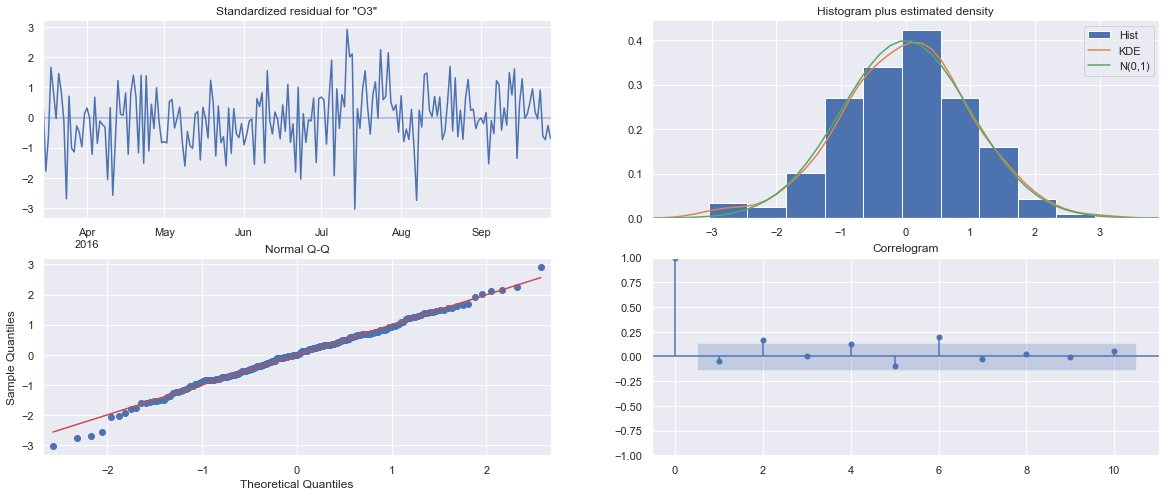

In [54]:
for var in range(4):
    varma_model.plot_diagnostics(variable=var)
    plt.show()

In [55]:
display(varma_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Statespace Model Results                              
=====================================================================================
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  198
Model:                                VMA(1)   Log Likelihood               -4317.371
                                 + intercept   AIC                           8694.741
Date:                       Fri, 12 Aug 2022   BIC                           8793.389
Time:                               18:20:03   HQIC                          8734.671
Sample:                           03-15-2016                                         
                                - 09-28-2016                                         
Covariance Type:                         opg                                         
===============================================================================================
Ljung-Box (L1) (Q):     44.95, 13.65, 5.81, 0.49   Jarque-Bera (JB):     4.16, 1.34, 0.22, 2.16
Prob(Q):                  0.00, 0.00, 0.02, 0.48   Prob(JB):             0.13, 0.51, 0.90, 0.34
Heteroskedasticity (H):   0.45, 0.58, 1.15, 0.76   Skew:               0.35, -0.17, 0.08, -0.19
Prob(H) (two-sided):      0.00, 0.03, 0.58, 0.26   Kurtosis:             3.05, 2.79, 2.98, 3.35
                           Results for equation CO                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    862.7328      8.753     98.568      0.000     845.578     879.888
L1.e(CO)       0.4531      0.116      3.900      0.000       0.225       0.681
L1.e(HC)       0.3278      0.125      2.613      0.009       0.082       0.574
L1.e(NO2)      0.2601      0.062      4.170      0.000       0.138       0.382
L1.e(O3)       0.0134      0.086      0.156      0.876      -0.155       0.182
                           Results for equation HC                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    752.5494      9.231     81.526      0.000     734.457     770.641
L1.e(CO)      -0.4140      0.159     -2.605      0.009      -0.725      -0.103
L1.e(HC)       0.9913      0.181      5.464      0.000       0.636       1.347
L1.e(NO2)      0.3008      0.084      3.596      0.000       0.137       0.465
L1.e(O3)       0.0055      0.122      0.045      0.964      -0.234       0.245
                           Results for equation NO2                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    711.9068     11.371     62.607      0.000     689.620     734.194
L1.e(CO)       0.6639      0.157      4.217      0.000       0.355       0.972
L1.e(HC)      -0.1452      0.180     -0.807      0.420      -0.498       0.207
L1.e(NO2)      0.6407      0.088      7.276      0.000       0.468       0.813
L1.e(O3)      -0.1200      0.121     -0.992      0.321      -0.357       0.117
                           Results for equation O3                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    759.1423     16.097     47.161      0.000     727.593     790.691
L1.e(CO)      -0.6524      0.265     -2.464      0.014      -1.171      -0.134
L1.e(

Insights for VARMA:

- For all the gases, the mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line. However all the correlograms except for O3 shows significant lags in the correlograms, indicating that a lot of information in the residuals are still useful for computing forecasts, indicating a bad fit

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.00     | 0.00    |
| HC     | 0.00    | 0.03    |
| NO2    | 0.02     | 0.58    |
| O3     | 0.48    | 0.26    |

- Heteroskedascity probability for NO2 and O3 are more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO and HC, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for most of the gases are less than 0.05 except for O3 which means we have sufficient evidence to reject the null hypothesis and that the model shows a lack of fit for those gases
___

VARMAX

In [56]:
varmax_results  = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                    'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
format, varmax_model = varmaxcv(VARMAX, 'Scores', endog, exog, splits=3, summary=True)
varmax_results = varmax_results.append(format)
varmax_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std  \
Scores         86.04301        0.817765    159.067063    26.539917   

           aic_mean      aic_std     bic_mean     bic_std  
Scores  5679.967505  2250.085343  5786.343741  2266.65885

Similar to the relationship between ARIMA and ARIMAX, SARIMA and SARIMAX, VARMAX model with exogenous variables seem to peform worse than the VARMAX model without exogenous variables. Returning a cross-validated RMSE score of 159.067063 and standard deviation in cross-validated RMSE scores of 26.539917.

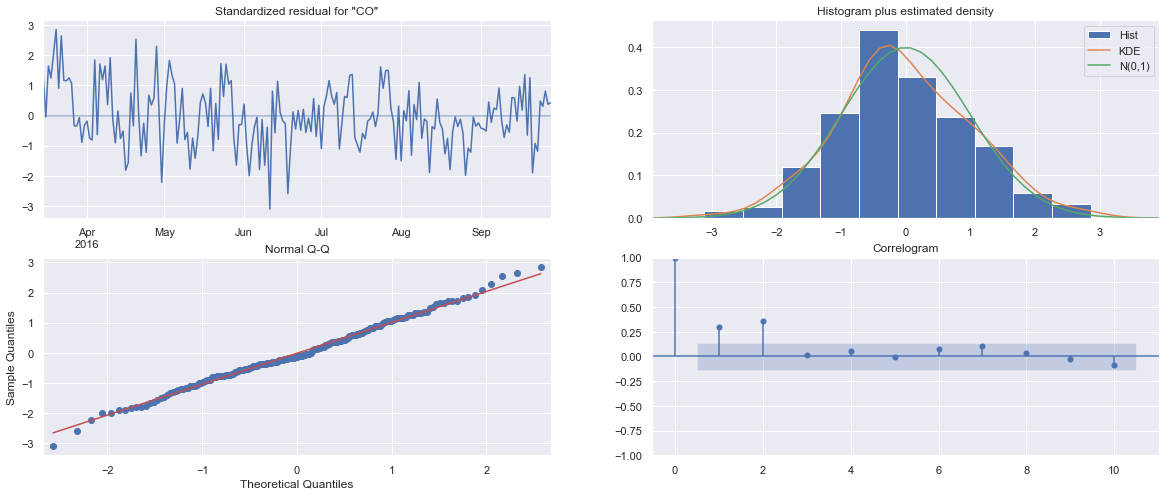

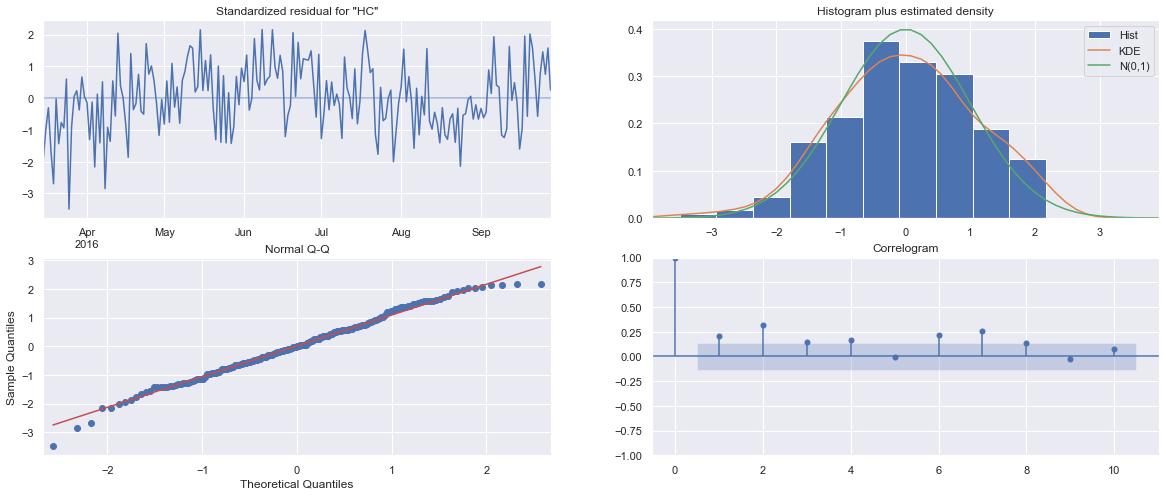

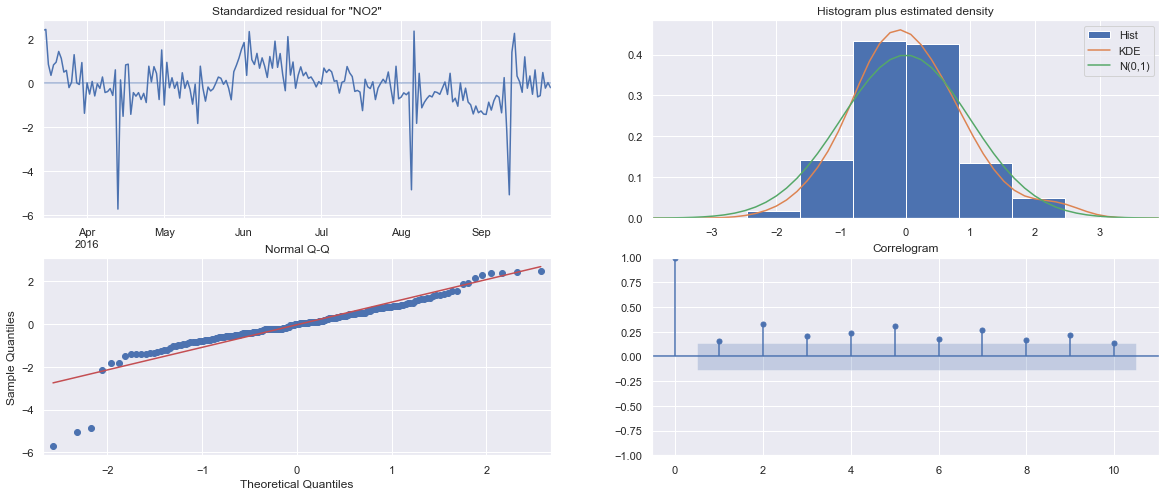

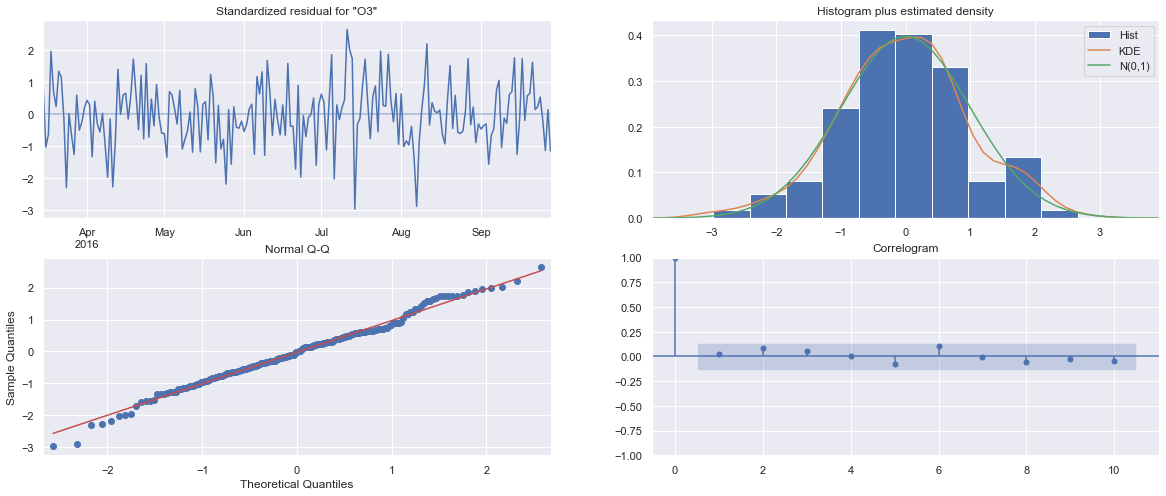

In [57]:
for var in range(4):
    varmax_model.plot_diagnostics(variable=var)
    plt.show()

In [58]:
display(varmax_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Statespace Model Results                              
=====================================================================================
Dep. Variable:     ['CO', 'HC', 'NO2', 'O3']   No. Observations:                  198
Model:                               VMAX(1)   Log Likelihood               -4182.441
                                 + intercept   AIC                           8440.883
Date:                       Fri, 12 Aug 2022   BIC                           8565.837
Time:                               18:20:10   HQIC                          8491.460
Sample:                           03-15-2016                                         
                                - 09-28-2016                                         
Covariance Type:                         opg                                         
===============================================================================================
Ljung-Box (L1) (Q):     18.11, 8.41, 4.61, 0.15   Jarque-Bera (JB):    0.36, 0.87, 533.15, 0.57
Prob(Q):                 0.00, 0.00, 0.03, 0.70   Prob(JB):              0.84, 0.65, 0.00, 0.75
Heteroskedasticity (H):  0.49, 0.72, 1.30, 1.00   Skew:               0.09, -0.15, -1.45, -0.07
Prob(H) (two-sided):     0.00, 0.18, 0.30, 1.00   Kurtosis:             3.10, 2.90, 10.50, 3.23
                           Results for equation CO                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    859.3532     63.463     13.541      0.000     734.968     983.739
L1.e(CO)       0.4089      0.125      3.269      0.001       0.164       0.654
L1.e(HC)       0.1007      0.131      0.771      0.440      -0.155       0.357
L1.e(NO2)      0.1243      0.081      1.527      0.127      -0.035       0.284
L1.e(O3)       0.1525      0.092      1.664      0.096      -0.027       0.332
beta.T        -3.2619      1.617     -2.017      0.044      -6.432      -0.092
beta.RH        1.9038      0.816      2.332      0.020       0.304       3.504
                           Results for equation HC                            
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    719.1470     76.935      9.347      0.000     568.357     869.937
L1.e(CO)      -0.3061      0.168     -1.825      0.068      -0.635       0.023
L1.e(HC)       0.8452      0.183      4.607      0.000       0.486       1.205
L1.e(NO2)      0.1912      0.103      1.862      0.063      -0.010       0.393
L1.e(O3)       0.1027      0.123      0.833      0.405      -0.139       0.344
beta.T         1.6693      1.894      0.881      0.378      -2.043       5.381
beta.RH       -0.1040      0.978     -0.106      0.915      -2.020       1.812
                           Results for equation NO2                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1140.0546     70.264     16.225      0.000    1002.340    1277.769
L1.e(CO)       0.2018      0.203      0.993      0.321      -0.197       0.600
L1.e(HC)      -0.2304      0.208     -1.110      0.267      -0.637       0.176
L1.e(NO2)      0.4484      0.097      4.616      0.000       0.258       0.639
L1.e(O3)      -0.0775      0.152     -0.510      0.610      -0.376       0.220
beta.T       -12.8809      1.824     -7.061      0.000     -16.457      -9.305
beta.RH       -2.9503      0.970     -3.041      0.002      -4.852      -1.049
     

Insights for VARMAX:

- For all the gases, the mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line. However all the correlograms except for O3 still show significant lags in the correlograms, indicating that some of information in the residuals are still useful for computing forecasts

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.00     | 0.00    |
| HC     | 0.00    | 0.18    |
| NO2    | 0.03     | 0.30    |
| O3     | 0.70    | 1.00    |

- Heteroskedascity probability for HC, NO2 and O3 are more than 0.05 which means we fail to reject the null hypothesis and the variance of the residuals are equal
- However, for CO, the probability is less than 0.05. This means that there is no constant variance in the residuals 
- Ljung-Box probability for most of the gases are less than 0.05 except for O3 which means we have sufficient evidence to reject the null hypothesis and that the model shows a lack of fit for those gases
___

# Model Improvement

<h3>Feature Engineering</h3>

We will be creating new feature(s) for model improvement, these feature(s) will be part of the exogenous variables.

<u>1. Dew point</u>

To calculate the dew point [10]: 

1. Multiply 17.625 by the temperature and divide the result by the temperature plus 243.04
2. Take the natural logarithm of the relative humidity divided by 100 and add it to the result of the previous step
3. Multiply the result of Step 3 by 243.04 and divide it by 17.625 minus the result of Step 2

In [59]:
# Creating 'Dew point' exogenous variable for train set
train_set['Dew point'] = (243.04*(np.log(train_set['RH']/100)+((17.625*train_set['T'])/(243.04 + train_set['T']))))/(17.625-(np.log(train_set['RH']/100)+(17.625*train_set['T'])/(243.04 + train_set['T'])))

# Creating 'Dew point' exogenous variable for test set
test_set['Dew point'] = (243.04*(np.log(test_set['RH']/100)+((17.625*test_set['T'])/(243.04 + test_set['T']))))/(17.625-(np.log(test_set['RH']/100)+(17.625*test_set['T'])/(243.04 + test_set['T'])))

# Creating 'Dew point' exogenous variable for whole of dataset
pivotDf['Dew point'] = (243.04*(np.log(pivotDf['RH']/100)+((17.625*pivotDf['T'])/(243.04+pivotDf['T']))))/(17.625-(np.log(pivotDf['RH']/100)+(17.625*pivotDf['T'])/(243.04 + pivotDf['T'])))

<u>2. Is Weekend</u>

Find out if that particular day was a weekend or not. 

- Value of '1' means yes, '0' means no

In [60]:
# Creating 'Is Weekend' exogenous variable for train set
train_set['Is Weekend'] =((train_set.index.dayofweek == 5)|(train_set.index.dayofweek == 6)).astype(int)

# Creating 'Is Weekend' exogenous variable for test set
test_set['Is Weekend'] =((test_set.index.dayofweek == 5)|(test_set.index.dayofweek == 6)).astype(int)

# Creating 'Is Weekend' exogenous variable for whole of dataset
pivotDf['Is Weekend'] =((pivotDf.index.dayofweek == 5)|(pivotDf.index.dayofweek == 6)).astype(int)

In [61]:
# Creating dictionary of new exogenous variables for train set
dewpoint_exog = train_set[['T','RH','Dew point']]
weekend_exog = train_set[['T','RH','Is Weekend']]
both_exog = train_set[['T','RH','Dew point','Is Weekend']]

exog_dict = {
    'dewpoint': dewpoint_exog, 
    'isweekend': weekend_exog,
    'both': both_exog
    }

Now, we will test the combinations of the newly created features and selected which exogenous vriables combination is best for each model.

<b>Unobserved Components with exogenous variables</b>

In [62]:
# Displaying unobserved components with exogenous variables 'T' and 'RH' for comparison
ucmx_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO        114.165762       25.389000    181.536767    79.066053  1441.298688   
HC        114.618387       16.794746    157.285726    72.782456  1502.094978   
NO2       192.462237       43.060505    138.190234    24.412632  1511.510794   
O3        158.522853       20.287495    298.705093   145.553006  1642.056301   

        aic_std     bic_mean     bic_std  
CO   569.932571  1457.871796  572.651784  
HC   612.968857  1518.668085  615.685976  
NO2  606.494055  1528.083901  609.212660  
O3   661.630201  1658.629409  664.343683

In [63]:
format = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                                'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    for exog in exog_dict:
        format = format.append(ucmcv(UnobservedComponents, f'{col} with {exog}', endog[col], exog=exog_dict[exog], ar=1, splits=3))
format

train_rmse_mean  train_rmse_std  cv_rmse_mean  \
CO with dewpoint         120.997658       59.395369    191.060299   
CO with isweekend        110.839359       20.734040    179.377158   
CO with both             106.335625       38.675678    152.005204   
HC with dewpoint          94.833626       22.888855    158.104256   
HC with isweekend        109.267112       12.786478    154.402761   
HC with both             116.210486       47.904576    154.316267   
NO2 with dewpoint        158.834370       12.592556    132.004300   
NO2 with isweekend       186.404742       32.742056    136.536950   
NO2 with both            152.345373        6.617182    131.992153   
O3 with dewpoint         173.060654       50.126416    300.651298   
O3 with isweekend        144.898457       14.018335    298.400449   
O3 with both             192.787278       97.986759    300.103600   

                    cv_rmse_std     aic_mean     aic_std     bic_mean  \
CO with dewpoint      78.073143  1445.450733  575.095090  1464.786025   
CO with isweekend     88.317795  1422.582635  562.388382  1441.917927   
CO with both          59.980686  1421.934780  559.609783  1444.032256   
HC with dewpoint      70.839403  1495.058524  593.807202  1514.393816   
HC with isweekend     68.071518  1483.051549  602.436697  1502.386841   
HC with both          70.155500  1475.513634  602.154036  1497.611110   
NO2 with dewpoint     22.396372  1516.144128  606.864697  1535.479420   
NO2 with isweekend    23.660425  1487.807377  596.619065  1507.142668   
NO2 with both         26.210900  1493.743090  599.877381  1515.840566   
O3 with dewpoint     146.806953  1643.097720  660.595787  1662.433012   
O3 with isweekend    155.024690  1614.316241  645.032024  1633.651533   
O3 with both         147.689367  1619.298149  653.607529  1641.395625   

                       bic_std  
CO with dewpoint    578.262792  
CO with isweekend   565.560295  
CO with both        563.228689  
HC with dewpoint    596.982415  
HC with isweekend   605.602129  
HC with both        605.759073  
NO2 with dewpoint   610.034133  
NO2 with isweekend  599.785591  
NO2 with both       603.500473  
O3 with dewpoint    663.762093  
O3 with isweekend   648.203652  
O3 with both        657.224128

In general, for unobserved components with exogenous variables, the newly created features did not improve the cross-validated RMSE scores of all the gases. HC, NO2 and O3 showed a slight improvement when both 'Dew point' and 'Is Weekend' were used as exogenous variables for HC as well as NO2 and 'Is Weekend' for O3. CO was the only gas that did not show an improvement in cross-validated RMSE.

| Gas | Previous | Improved | Added exogenous variable(s) |
| ---    | ---   | ---   | ---   |
| HC    | 149.442987     | 122.268412    | Dew point, Is Weekend |
| NO2    | 124.456128     | 117.077365    | Dew point, Is Weekend |
| O3     | 267.148203    | 237.438715    | Is Weekend |

<b>ARIMAX</b>

In [64]:
# Displaying arimax with exogenous variables 'T' and 'RH' for comparison
arimax_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         63.765756        3.970984    141.746004    17.417967  1482.102728   
HC         67.770820        2.120612    142.192221    21.375130  1518.369389   
NO2        74.599895        2.090913    135.127284    52.109940  1532.946217   
O3        126.079464        5.369161    237.176909    38.803816  1675.338608   

        aic_std     bic_mean     bic_std  
CO   571.767184  1498.898976  574.388653  
HC   607.016027  1540.764386  610.504587  
NO2  601.174197  1549.742464  603.792817  
O3   653.076412  1697.733605  656.568622

In [65]:
format = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    for exog in exog_dict:
        format = format.append(arimacv(ARIMA, f'{col} with {exog}', endog[col], exog=exog_dict[exog], splits=3, order=glob_order[col]))
format

train_rmse_mean  train_rmse_std  cv_rmse_mean  \
CO with dewpoint          64.522430        5.050603    123.174340   
CO with isweekend         60.532592        3.761983    145.256648   
CO with both              61.458723        4.978345    130.282827   
HC with dewpoint          67.688377        2.086719    129.036122   
HC with isweekend         64.093701        2.111076    123.265410   
HC with both              64.156530        1.292515    115.810866   
NO2 with dewpoint         74.687196        2.202901    127.092672   
NO2 with isweekend        70.125609        2.065191    133.956441   
NO2 with both             70.013591        2.013467    124.514347   
O3 with dewpoint         125.398840        4.989957    209.250840   
O3 with isweekend        116.620711        2.844796    240.098322   
O3 with both             117.353323        3.794895    236.392613   

                    cv_rmse_std     aic_mean     aic_std     bic_mean  \
CO with dewpoint       0.939096  1486.276100  569.408544  1505.871723   
CO with isweekend     18.965225  1469.357069  565.397193  1488.952691   
CO with both          10.897107  1473.933953  563.218377  1496.328950   
HC with dewpoint      18.750580  1520.068458  606.562104  1545.262830   
HC with isweekend     20.421279  1505.201079  601.317871  1530.395451   
HC with both          20.930663  1507.192015  598.345974  1535.185761   
NO2 with dewpoint     48.805928  1535.119036  600.933487  1554.714659   
NO2 with isweekend    50.267817  1518.327341  594.386649  1537.922964   
NO2 with both         50.019299  1519.963860  594.454725  1542.358857   
O3 with dewpoint      41.633003  1676.423363  653.736614  1701.617735   
O3 with isweekend     24.266532  1659.393463  650.307135  1684.587834   
O3 with both          53.643443  1660.702314  647.490522  1688.696060   

                       bic_std  
CO with dewpoint    572.466241  
CO with isweekend   568.454765  
CO with both        566.711620  
HC with dewpoint    610.487045  
HC with isweekend   605.242063  
HC with both        602.707740  
NO2 with dewpoint   603.988510  
NO2 with isweekend  597.441390  
NO2 with both       597.945649  
O3 with dewpoint    657.664136  
O3 with isweekend   654.234747  
O3 with both        651.855009

For ARIMAX, it seems like the newly created features helped in improving the performance of the model with two of the gases, CO and O3, improving on the exogenous feature 'Dew point' while the other two HC and NO2 improved the most with both the newly created features.

| Gas | Previous | Improved | Added exogenous variable(s) |
| ---    | ---   | ---   | ---   |
| CO    | 141.746004     | 123.174340    | Dew point |
| HC     | 142.192221    | 115.810866    | Dew point, Is Weekend |
| NO2    | 135.127284     | 124.514347    | Dew point, Is Weekend |
| O3     | 237.176909    | 209.250840    | Dew point |

<b>SARIMAX</b>

In [66]:
# Displaying sarimax with exogenous variables 'T' and 'RH' for comparison
sarimax_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std     aic_mean  \
CO         92.813604       15.678383    142.902894    86.890159  1489.614329   
HC         75.390448        1.330618    147.632976    33.351177  1497.423377   
NO2       125.344037       16.749246    216.901066   159.440127  1560.473395   
O3        124.046241        7.557468    286.254948    60.128870  1669.960695   

        aic_std     bic_mean     bic_std  
CO   620.156962  1514.591408  624.620842  
HC   624.996043  1530.726150  630.935501  
NO2  657.917701  1588.225706  662.873935  
O3   705.626248  1703.263468  711.574375

In [67]:
format = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for col in gases:
    for exog in exog_dict:
        format = format.append(arimacv(SARIMAX, f'{col} with {exog}', endog[col], exog=exog_dict[exog], 
                            order=glob_order[col], s_order=seasonal_order[col]))
format

train_rmse_mean  train_rmse_std  cv_rmse_mean  \
CO with dewpoint          62.270100        4.999174    143.652493   
CO with isweekend         92.946086       16.100599    149.389947   
CO with both              61.204301        4.448338    139.568722   
HC with dewpoint          60.930863        2.292771    131.675228   
HC with isweekend         81.134120       10.793709    137.801623   
HC with both              60.207098        1.937199    135.107340   
NO2 with dewpoint         73.237178        2.765274    123.785505   
NO2 with isweekend       128.300535       17.444192    147.526300   
NO2 with both             71.554882        1.897106    118.968935   
O3 with dewpoint         118.855914        6.955218    258.299642   
O3 with isweekend        121.163474        4.951911    288.823617   
O3 with both             115.255519        5.078800    250.923618   

                    cv_rmse_std     aic_mean     aic_std     bic_mean  \
CO with dewpoint      56.119684  1476.603841  618.049777  1504.356152   
CO with isweekend     62.996737  1485.545066  619.366779  1513.297377   
CO with both          54.103388  1475.607037  618.421208  1506.134579   
HC with dewpoint      21.223582  1491.176902  633.329306  1527.254906   
HC with isweekend     43.504746  1490.673894  630.735472  1526.751898   
HC with both          17.847302  1491.301494  634.799952  1530.154729   
NO2 with dewpoint     33.767331  1537.211679  654.433350  1567.739221   
NO2 with isweekend    50.371474  1561.118693  657.149250  1591.646235   
NO2 with both         38.674971  1533.748858  655.974657  1567.051631   
O3 with dewpoint      31.137552  1665.408846  704.094068  1701.486851   
O3 with isweekend    105.009989  1662.453810  706.196943  1698.531814   
O3 with both          35.648749  1661.707200  704.747904  1700.560436   

                       bic_std  
CO with dewpoint    623.012575  
CO with isweekend   624.323039  
CO with both        623.879921  
HC with dewpoint    639.779299  
HC with isweekend   637.176423  
HC with both        641.745947  
NO2 with dewpoint   659.883473  
NO2 with isweekend  662.607729  
NO2 with both       661.917700  
O3 with dewpoint    710.538796  
O3 with isweekend   712.633932  
O3 with both        711.689075

Similar to ARIMAX, for SARIMAX, all of the gases improved in cross-validated RMSE scores after including the new features and this time it seems that adding both of the newly created exogenous variables for most of the gases returns better performance except for HC where only adding the new feature 'Dew point', increased the model's peformance. 

| Gas | Previous | Improved | Added exogenous variable(s) |
| ---    | ---   | ---   | ---   |
| CO    | 142.902894     | 139.568722    | Dew point, Is Weekend |
| HC     | 147.632976    | 131.675228    | Dew point |
| NO2    | 216.901066     | 118.968935    | Dew point, Is Weekend |
| O3     | 286.254948    | 250.923618    | Dew point, Is Weekend |

<b>VARMAX</b>

In [68]:
# Displaying varmax with exogenous variables 'T' and 'RH' for comparison
varmax_results

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std  \
Scores         86.04301        0.817765    159.067063    26.539917   

           aic_mean      aic_std     bic_mean     bic_std  
Scores  5679.967505  2250.085343  5786.343741  2266.65885

In [69]:
format = pd.DataFrame(columns=['train_rmse_mean', 'train_rmse_std', 'cv_rmse_mean', 'cv_rmse_std', 
                            'aic_mean', 'aic_std', 'bic_mean', 'bic_std'])
for exog in exog_dict:
    format = format.append(varmaxcv(VARMAX, f'Scores with {exog}', endog, exog=exog_dict[exog], splits=3))
format

train_rmse_mean  train_rmse_std  cv_rmse_mean  \
Scores with dewpoint         86.483159        0.984232    147.500246   
Scores with isweekend        80.639539        0.467008    159.241667   
Scores with both             81.417721        0.964661    145.084321   

                       cv_rmse_std     aic_mean      aic_std     bic_mean  \
Scores with dewpoint     21.546027  5678.446901  2240.266999  5796.020635   
Scores with isweekend    28.493720  5672.120337  2245.921124  5789.694071   
Scores with both         22.156336  5669.671446  2237.796120  5798.442679   

                           bic_std  
Scores with dewpoint   2258.585660  
Scores with isweekend  2264.238928  
Scores with both       2257.858820

As for VARMAX, we see that with added exogenous variables 'Dew point' and 'Is Weekend', the model performed slightly better.

| Previous | Improved | Added exogenous variable(s) |
| ---   | ---   | ---   |
| 159.067063     | 145.084321    | Dew point, Is Weekend |

<h3>Hyperparameter Tuning</h3>

We want to conduct hyperparameter tuning to further find the best set of parameters that can improve our model.

I intend to tune VARMAX with both the added exogenous variable 'Dew point' and 'Is Weekend' and ARIMA model with seasonal components with and without exogenous variables (SARIMAX and SARIMA) for all the gases to find the best parameters and further shortlist the models.

Why didn't I tune the other models?
- I chose not to tune for the smoothing models (Exponential Smoothing) because they are not robust to predicting for outlier values 
- For Unobserved Components, there is significant auto correlation the residuals, indicating a poor fit, this tells me the unobserved components probably will not return my desired results 
- For ARIMA and ARIMAX, they fail to capture the seasonality, hence it is not a suitable model for this dataset

<b>VARMA</b>

In [70]:
# Store the tuned p first
varmax_list = [(p,0) for p in range(1,11,1)]
varmax_q_list = [(0,q) for q in range(1,11,1)]

# Then append the tuned q
for order in varmax_q_list:
    varmax_list.append(order)

In [71]:
def varmax_gridsearch(ord, exog):
    try:
        return varmaxcv(VARMAX, f'VARMAX{ord}', endog, exog=exog, splits=3, order=ord)
    except:
        return None

In [72]:
varma_scores = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(varmax_gridsearch)(order, None) for order in varmax_list)))
varma_scores

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std  \
VARMAX(1, 0)         87.999517        2.667453    145.943729    33.221381   
VARMAX(2, 0)         81.386310        2.730116    144.593435    32.141339   
VARMAX(3, 0)         80.001301        1.889713    145.482734    34.430202   
VARMAX(4, 0)         78.081075        0.952450    144.698514    32.933866   
VARMAX(5, 0)         76.038337        0.299694    141.562492    33.377413   
VARMAX(6, 0)         74.211107        0.875936    142.153311    28.720272   
VARMAX(7, 0)         70.222063        1.633354    139.827260    31.856168   
VARMAX(8, 0)         68.933043        2.340287    138.088961    31.458120   
VARMAX(9, 0)         68.587588        1.404696    139.045995    30.792076   
VARMAX(10, 0)        68.455295        0.354393    138.302420    28.803430   
VARMAX(0, 1)         90.736075        1.270557    145.264161    32.741952   
VARMAX(0, 2)         87.024444        0.882393    144.914536    32.895788   
VARMAX(0, 3)         84.867783        1.548136    145.001927    32.750724   
VARMAX(0, 4)         83.752838        1.138931    145.070363    32.299274   
VARMAX(0, 5)         85.543469        2.920109    145.316707    32.675625   
VARMAX(0, 6)         79.116991        3.073599    146.268580    31.811003   
VARMAX(0, 7)         77.095274        2.652480    144.939760    33.416510   
VARMAX(0, 8)         76.726658        3.404652    145.030278    32.325563   
VARMAX(0, 9)         74.372814        3.280580    144.983966    32.444241   
VARMAX(0, 10)        75.663252        4.605276    145.445935    32.864862   

                  aic_mean      aic_std     bic_mean      bic_std  
VARMAX(1, 0)   5577.827116  2200.073274  5661.808355  2213.163546  
VARMAX(2, 0)   5573.134985  2191.342286  5701.906217  2211.411318  
VARMAX(3, 0)   5566.023557  2187.047107  5739.584783  2214.100522  
VARMAX(4, 0)   5582.187208  2182.960068  5800.538429  2216.994905  
VARMAX(5, 0)   5594.160971  2186.154158  5857.302185  2227.171025  
VARMAX(6, 0)   5600.582317  2170.626810  5908.513525  2218.617861  
VARMAX(7, 0)   5602.780283  2169.146763  5955.501485  2224.130067  
VARMAX(8, 0)   5604.427754  2171.235265  6001.938950  2233.226945  
VARMAX(9, 0)   5628.461414  2165.822198  6070.762605  2234.792667  
VARMAX(10, 0)  5646.543049  2158.135698  6133.634233  2234.058241  
VARMAX(0, 1)   5814.500513  2343.782711  5898.481752  2356.861899  
VARMAX(0, 2)   5749.107485  2296.941527  5877.878718  2317.012773  
VARMAX(0, 3)   5728.159256  2262.766746  5901.720482  2289.808971  
VARMAX(0, 4)   5736.893092  2266.799256  5955.244312  2300.826569  
VARMAX(0, 5)   5747.873062  2246.459532  6011.014276  2287.479933  
VARMAX(0, 6)   5733.313648  2242.561552  6041.244856  2290.570241  
VARMAX(0, 7)   5737.658136  2227.136843  6090.379338  2282.142624  
VARMAX(0, 8)   5764.190430  2220.343754  6161.701626  2282.388868  
VARMAX(0, 9)   5781.300474  2225.019392  6223.601664  2293.996738  
VARMAX(0, 10)  5805.889995  2220.428273  6292.981179  2296.351751

<b>VARMAX</b>

In [73]:
varmax_scores = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(varmax_gridsearch)(order, exog_dict['both']) for order in varmax_list)))
varmax_scores

train_rmse_mean  train_rmse_std  cv_rmse_mean  cv_rmse_std  \
VARMAX(1, 0)         80.703212        1.130746    136.542518    32.055095   
VARMAX(2, 0)         76.020847        0.535422    134.566122    30.771740   
VARMAX(3, 0)         73.848392        1.396673    139.867875    28.078997   
VARMAX(4, 0)         72.509116        2.334151    142.311042    26.817853   
VARMAX(5, 0)         72.847648        1.387483    139.962875    28.993739   
VARMAX(6, 0)         72.028394        1.156985    142.129472    28.479854   
VARMAX(7, 0)         69.822926        3.522579    143.481873    31.815496   
VARMAX(8, 0)         67.663217        5.177324    146.124918    33.179854   
VARMAX(9, 0)         71.261736        1.223066    161.279030    26.841838   
VARMAX(10, 0)        78.031980       10.828809    162.439554    27.996886   
VARMAX(0, 1)         81.392130        0.979667    145.077129    22.164873   
VARMAX(0, 2)         79.160471        1.041366    145.306375    21.790002   
VARMAX(0, 3)         79.168230        1.555002    145.330857    21.882469   
VARMAX(0, 4)         77.902123        0.826611    145.705081    22.080057   
VARMAX(0, 5)         74.090119        4.108449    144.002299    22.534840   
VARMAX(0, 6)         73.284300        5.291438    144.752564    22.289765   
VARMAX(0, 7)         71.839127        4.278425    144.977120    21.550030   
VARMAX(0, 8)         69.857598        4.612425    145.119801    21.594923   
VARMAX(0, 9)         67.325608        6.808487    143.484657    22.766141   
VARMAX(0, 10)        68.467425        5.683938    144.289341    22.648671   

                  aic_mean      aic_std     bic_mean      bic_std  
VARMAX(1, 0)   5598.021269  2219.383313  5726.792502  2239.442831  
VARMAX(2, 0)   5601.299016  2211.956606  5774.860243  2238.991309  
VARMAX(3, 0)   5600.059555  2206.653083  5818.410776  2240.666505  
VARMAX(4, 0)   5618.568298  2201.718694  5881.709513  2242.704177  
VARMAX(5, 0)   5636.109301  2201.724069  5944.040510  2249.668109  
VARMAX(6, 0)   5649.477537  2190.584657  6002.198739  2245.504347  
VARMAX(7, 0)   5668.431725  2184.574650  6065.942922  2246.467886  
VARMAX(8, 0)   5673.567721  2183.950776  6115.868911  2252.832629  
VARMAX(9, 0)   5729.057355  2151.935562  6216.148539  2227.692252  
VARMAX(10, 0)  5783.371335  2102.517822  6315.252514  2185.036810  
VARMAX(0, 1)   5669.689191  2237.791827  5798.460423  2257.854548  
VARMAX(0, 2)   5638.185676  2227.185669  5811.746903  2254.213571  
VARMAX(0, 3)   5650.899619  2223.353899  5869.250839  2257.351428  
VARMAX(0, 4)   5664.712875  2229.659951  5927.854090  2270.636680  
VARMAX(0, 5)   5678.948676  2222.637367  5986.879884  2270.595432  
VARMAX(0, 6)   5699.042233  2217.739382  6051.763435  2272.694384  
VARMAX(0, 7)   5706.661641  2220.547145  6104.172838  2282.474540  
VARMAX(0, 8)   5721.561708  2221.365105  6163.862899  2290.239429  
VARMAX(0, 9)   5745.361197  2211.500913  6232.452381  2287.374214  
VARMAX(0, 10)  5779.813344  2200.645185  6311.694522  2283.458299

From the grid search, we can see that when q=0, the cross-validated RMSE values are better than the orders when p=0.

Hence, I will only shortlist the best combination of p and q for VARMA and VARMAX: 
- VARMA((8,0))
- VARMAX((2,0))

VARMA((8,0)) returned the best cross-validated RMSE score for VARMA combinations.

VARMAX((2,0)) returned the best cross-validated RMSE score for VARMAX combinations.
___

In [74]:
g_order = [(p,0,q) for p in range(4) for q in range(4)]

seas_order = [(P,0,Q,7) for P in range(4) for Q in range(4)]

<b>SARIMA</b>

Now, lets search for the best parameters for the ARIMA models with seasonal components but without exogenous variables (SARIMA). Since it is a univariate model, I will be tuning the parameters separately for each gas.

In [75]:
def sarimax_gridsearch(ord, sord, exog, gas, index):
    try:
        return arimacv(SARIMAX, f'{index}{ord}{sord}', endog[gas], exog=exog, splits=3, order=ord, s_order=sord)
    except:
        return None

<u>CO</u>

In [76]:
sarimaco = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, None, 'CO', 'SARIMA') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimaco.loc[sarimaco['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [00:45<00:00,  2.87s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMA(3, 0, 3)(2, 0, 3, 7)       115.554372       21.477328     90.404490   
SARIMA(3, 0, 2)(1, 0, 2, 7)       116.189890       21.923696     92.088399   
SARIMA(1, 0, 2)(2, 0, 1, 7)       117.089890       21.257555     92.157411   
SARIMA(3, 0, 2)(1, 0, 1, 7)       116.117862       21.996229     92.531753   
SARIMA(3, 0, 3)(1, 0, 3, 7)       115.640648       21.467934     92.672895   

                             cv_rmse_std     aic_mean     aic_std  \
SARIMA(3, 0, 3)(2, 0, 3, 7)    26.554518  1491.050313  563.729390   
SARIMA(3, 0, 2)(1, 0, 2, 7)    30.598658  1489.779476  563.713796   
SARIMA(1, 0, 2)(2, 0, 1, 7)    26.318360  1493.479185  570.304017   
SARIMA(3, 0, 2)(1, 0, 1, 7)    33.637835  1486.836773  562.674983   
SARIMA(3, 0, 3)(1, 0, 3, 7)    26.708444  1489.787620  564.150372   

                                bic_mean     bic_std  
SARIMA(3, 0, 3)(2, 0, 3, 7)  1524.642809  568.972240  
SARIMA(3, 0, 2)(1, 0, 2, 7)  1514.973848  567.644601  
SARIMA(1, 0, 2)(2, 0, 1, 7)  1513.074808  573.361964  
SARIMA(3, 0, 2)(1, 0, 1, 7)  1509.231770  566.169670  
SARIMA(3, 0, 3)(1, 0, 3, 7)  1520.580740  568.956383

We can see that after tuning for CO, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (3,0,3)     | (2,0,3,7)    |

___

<u>HC</u>

In [77]:
sarimahc = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, None, 'HC', 'SARIMA') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimahc.loc[sarimahc['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [00:46<00:00,  2.88s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMA(1, 0, 3)(3, 0, 3, 7)        93.592600       13.077890     94.713352   
SARIMA(1, 0, 2)(1, 0, 1, 7)        95.437509       13.238467     95.495931   
SARIMA(1, 0, 2)(1, 0, 2, 7)        95.297097       13.039822     95.936061   
SARIMA(1, 0, 2)(3, 0, 3, 7)        94.375151       12.553786     96.056024   
SARIMA(1, 0, 3)(1, 0, 1, 7)        94.293415       13.668619     96.137712   

                             cv_rmse_std     aic_mean     aic_std  \
SARIMA(1, 0, 3)(3, 0, 3, 7)    17.028380  1507.218540  585.834930   
SARIMA(1, 0, 2)(1, 0, 1, 7)    18.169098  1504.896005  584.112724   
SARIMA(1, 0, 2)(1, 0, 2, 7)    18.033585  1506.373808  584.721622   
SARIMA(1, 0, 2)(3, 0, 3, 7)    17.177500  1507.228322  585.551365   
SARIMA(1, 0, 3)(1, 0, 1, 7)    19.874959  1498.928933  579.210888   

                                bic_mean     bic_std  
SARIMA(1, 0, 3)(3, 0, 3, 7)  1538.011661  590.634045  
SARIMA(1, 0, 2)(1, 0, 1, 7)  1521.692252  586.730658  
SARIMA(1, 0, 2)(1, 0, 2, 7)  1525.969431  587.776147  
SARIMA(1, 0, 2)(3, 0, 3, 7)  1535.222068  589.917358  
SARIMA(1, 0, 3)(1, 0, 1, 7)  1518.524555  582.264876

We can see that after tuning for HC, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (1,0,3)     | (3,0,3,7)    |

___

<u>NO2</u>

In [78]:
sarimano2 = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, None, 'NO2', 'SARIMA') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimano2.loc[sarimano2['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [00:46<00:00,  2.91s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMA(2, 0, 1)(1, 0, 1, 7)       118.761852       19.595695    102.869044   
SARIMA(0, 0, 2)(2, 0, 2, 7)       166.980598       23.778638    104.268667   
SARIMA(2, 0, 3)(1, 0, 1, 7)       117.272952       17.658317    104.570437   
SARIMA(3, 0, 1)(1, 0, 1, 7)       117.197733       19.766451    105.332122   
SARIMA(1, 0, 0)(1, 0, 1, 7)       120.038134       18.945262    105.411998   

                             cv_rmse_std     aic_mean     aic_std  \
SARIMA(2, 0, 1)(1, 0, 1, 7)    30.335867  1551.894024  588.843921   
SARIMA(0, 0, 2)(2, 0, 2, 7)    26.091686  1682.178638  721.577545   
SARIMA(2, 0, 3)(1, 0, 1, 7)    27.862508  1551.049592  596.375717   
SARIMA(3, 0, 1)(1, 0, 1, 7)    25.958509  1545.215035  587.702246   
SARIMA(1, 0, 0)(1, 0, 1, 7)    33.879489  1556.177223  596.915171   

                                bic_mean     bic_std  
SARIMA(2, 0, 1)(1, 0, 1, 7)  1568.690272  591.468731  
SARIMA(0, 0, 2)(2, 0, 2, 7)  1701.774261  724.572690  
SARIMA(2, 0, 3)(1, 0, 1, 7)  1573.444589  599.871165  
SARIMA(3, 0, 1)(1, 0, 1, 7)  1564.810658  590.758920  
SARIMA(1, 0, 0)(1, 0, 1, 7)  1567.374721  598.662984

We can see that after tuning for NO2, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (2,0,1)     | (1,0,1,7)    |

___

<u>O3</u>

In [79]:
sarimao3 = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, None, 'O3', 'SARIMA') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimao3.loc[sarimao3['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [00:47<00:00,  2.94s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMA(1, 0, 2)(1, 0, 1, 7)       151.317140       17.185115    176.174731   
SARIMA(1, 0, 3)(1, 0, 2, 7)       148.482995       17.828383    177.356126   
SARIMA(3, 0, 3)(3, 0, 1, 7)       147.579076       17.933540    177.644976   
SARIMA(1, 0, 3)(1, 0, 1, 7)       148.514594       17.847866    177.705454   
SARIMA(3, 0, 3)(2, 0, 2, 7)       147.335115       18.137976    178.272054   

                             cv_rmse_std     aic_mean     aic_std  \
SARIMA(1, 0, 2)(1, 0, 1, 7)    44.076689  1673.882871  646.359884   
SARIMA(1, 0, 3)(1, 0, 2, 7)    46.398824  1669.976471  642.513859   
SARIMA(3, 0, 3)(3, 0, 1, 7)    43.693843  1673.654922  641.476244   
SARIMA(1, 0, 3)(1, 0, 1, 7)    46.714748  1668.030988  642.533142   
SARIMA(3, 0, 3)(2, 0, 2, 7)    40.788037  1672.789408  640.585150   

                                bic_mean     bic_std  
SARIMA(1, 0, 2)(1, 0, 1, 7)  1690.679119  648.979976  
SARIMA(1, 0, 3)(1, 0, 2, 7)  1692.371468  646.006191  
SARIMA(3, 0, 3)(3, 0, 1, 7)  1704.448043  646.277609  
SARIMA(1, 0, 3)(1, 0, 1, 7)  1687.626610  645.588868  
SARIMA(3, 0, 3)(2, 0, 2, 7)  1703.582529  645.386790

We can see that after tuning for O3, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (1,0,2)     | (1,0,1,7)    |

___

<b>SARIMA best parameters</b>

| Gas | Global Order | Seasonal Order |
| ---    | ---   | ---   |
| CO     | (3,0,3)    | (2,0,3,7)    |
| HC    | (1,0,3)     | (3,0,3,7)    |
| NO2    | (2,0,1)     | (1,0,1,7)    |
| O3     | (1,0,2)    | (1,0,1,7)    |

___

<b>SARIMAX</b>

Now, lets search for the best parameters for the ARIMA models with seasonal components and with exogenous variables (SARIMAX). Since it is a univariate model, I will be tuning the parameters separately for each gas.

<u>CO</u>

In [80]:
sarimaxco = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, exog_dict['both'], 'CO', 'SARIMAX') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimaxco.loc[sarimaxco['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [01:11<00:00,  4.44s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMAX(0, 0, 2)(0, 0, 0, 7)        64.984760        3.325600    129.974777   
SARIMAX(0, 0, 0)(0, 0, 0, 7)        91.837198        3.299017    132.025762   
SARIMAX(0, 0, 1)(0, 0, 0, 7)        68.784058        2.265140    132.343252   
SARIMAX(3, 0, 3)(3, 0, 3, 7)        55.799096        4.037414    134.111375   
SARIMAX(0, 0, 3)(0, 0, 0, 7)        62.325852        2.677388    134.178900   

                              cv_rmse_std     aic_mean     aic_std  \
SARIMAX(0, 0, 2)(0, 0, 0, 7)    45.885856  1494.287944  578.927729   
SARIMAX(0, 0, 0)(0, 0, 0, 7)    50.992689  1585.968591  620.332938   
SARIMAX(0, 0, 1)(0, 0, 0, 7)    50.125531  1510.218513  590.398674   
SARIMAX(3, 0, 3)(3, 0, 3, 7)    46.022632  1477.129973  563.235316   
SARIMAX(0, 0, 3)(0, 0, 0, 7)    42.881194  1484.655355  576.021535   

                                 bic_mean     bic_std  
SARIMAX(0, 0, 2)(0, 0, 0, 7)  1513.883566  581.986203  
SARIMAX(0, 0, 0)(0, 0, 0, 7)  1599.965464  622.517567  
SARIMAX(0, 0, 1)(0, 0, 0, 7)  1527.014761  593.020080  
SARIMAX(3, 0, 3)(3, 0, 3, 7)  1524.719342  570.651734  
SARIMAX(0, 0, 3)(0, 0, 0, 7)  1507.050352  579.517366

We can see that after tuning for CO, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (0,0,2)     | (0,0,0,7)    |

___

<u>HC</u>

In [81]:
sarimaxhc = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, exog_dict['dewpoint'], 'HC', 'SARIMAX') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimaxhc.loc[sarimaxhc['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [01:01<00:00,  3.86s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMAX(1, 0, 3)(2, 0, 2, 7)        59.735265        1.601921    116.457307   
SARIMAX(2, 0, 3)(2, 0, 2, 7)        59.266659        0.719074    121.889444   
SARIMAX(2, 0, 3)(2, 0, 1, 7)        58.541312        0.057639    122.409143   
SARIMAX(3, 0, 2)(1, 0, 3, 7)        58.616737        0.365268    122.480322   
SARIMAX(1, 0, 3)(3, 0, 2, 7)        59.670746        1.653866    122.969646   

                              cv_rmse_std     aic_mean     aic_std  \
SARIMAX(1, 0, 3)(2, 0, 2, 7)    10.675065  1486.734075  579.493038   
SARIMAX(2, 0, 3)(2, 0, 2, 7)    11.823437  1487.504182  583.094864   
SARIMAX(2, 0, 3)(2, 0, 1, 7)    20.069178  1483.225109  585.150876   
SARIMAX(3, 0, 2)(1, 0, 3, 7)    22.599417  1484.256439  581.712035   
SARIMAX(1, 0, 3)(3, 0, 2, 7)    15.384404  1487.662151  578.375192   

                                 bic_mean     bic_std  
SARIMAX(1, 0, 3)(2, 0, 2, 7)  1520.326570  584.728984  
SARIMAX(2, 0, 3)(2, 0, 2, 7)  1523.896052  588.765320  
SARIMAX(2, 0, 3)(2, 0, 1, 7)  1516.817604  590.385099  
SARIMAX(3, 0, 2)(1, 0, 3, 7)  1520.648309  587.387065  
SARIMAX(1, 0, 3)(3, 0, 2, 7)  1524.054021  584.048425

We can see that after tuning for HC, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (1,0,3)     | (2,0,2,7)    |

___

<u>NO2</u>

In [82]:
sarimaxno2 = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, exog_dict['both'], 'NO2', 'SARIMAX') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimaxno2.loc[sarimaxno2['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [01:08<00:00,  4.26s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMAX(1, 0, 3)(1, 0, 2, 7)        69.152031        1.107559    126.322654   
SARIMAX(1, 0, 0)(2, 0, 1, 7)        69.967382        1.497412    126.813065   
SARIMAX(2, 0, 2)(1, 0, 2, 7)        69.009702        0.775653    126.837391   
SARIMAX(3, 0, 2)(1, 0, 2, 7)        68.936458        0.792449    127.116224   
SARIMAX(2, 0, 0)(2, 0, 1, 7)        69.889643        1.446237    127.197356   

                              cv_rmse_std     aic_mean     aic_std  \
SARIMAX(1, 0, 3)(1, 0, 2, 7)    49.707923  1525.249141  595.352137   
SARIMAX(1, 0, 0)(2, 0, 1, 7)    53.558290  1522.095854  595.559608   
SARIMAX(2, 0, 2)(1, 0, 2, 7)    50.236333  1525.111167  596.209368   
SARIMAX(3, 0, 2)(1, 0, 2, 7)    47.511963  1526.613068  596.066120   
SARIMAX(2, 0, 0)(2, 0, 1, 7)    54.013010  1523.862684  595.484249   

                                 bic_mean     bic_std  
SARIMAX(1, 0, 3)(1, 0, 2, 7)  1558.841636  600.588773  
SARIMAX(1, 0, 0)(2, 0, 1, 7)  1547.290226  599.486975  
SARIMAX(2, 0, 2)(1, 0, 2, 7)  1558.703662  601.447710  
SARIMAX(3, 0, 2)(1, 0, 2, 7)  1563.004938  601.739437  
SARIMAX(2, 0, 0)(2, 0, 1, 7)  1551.856430  599.848263

We can see that after tuning for NO2, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (1,0,3)     | (1,0,2,7)    |

___

<u>O3</u>

In [83]:
sarimaxo3 = pd.concat(Parallel(n_jobs=-1, verbose=0)((delayed(sarimax_gridsearch)(order, sorder, exog_dict['both'], 'O3', 'SARIMAX') 
                    for order in tqdm(g_order) for sorder in seas_order)))

# Selecting the parameters with the lowest cross-validated RMSE value
sarimaxo3.loc[sarimaxo3['cv_rmse_mean'].nsmallest(n=5).index]

100%|██████████| 16/16 [01:08<00:00,  4.28s/it]


train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMAX(0, 0, 2)(0, 0, 0, 7)       119.327905        3.438814    227.011053   
SARIMAX(0, 0, 1)(0, 0, 0, 7)       122.019823        1.699849    227.899642   
SARIMAX(2, 0, 0)(0, 0, 0, 7)       118.685179        3.772858    228.569153   
SARIMAX(0, 0, 1)(3, 0, 3, 7)       118.650424        3.317983    228.643177   
SARIMAX(3, 0, 3)(3, 0, 3, 7)       114.107437        3.251932    230.202165   

                              cv_rmse_std     aic_mean     aic_std  \
SARIMAX(0, 0, 2)(0, 0, 0, 7)    35.440304  1660.551480  651.635852   
SARIMAX(0, 0, 1)(0, 0, 0, 7)    34.765610  1666.178561  658.067760   
SARIMAX(2, 0, 0)(0, 0, 0, 7)    39.020246  1658.989156  650.465794   
SARIMAX(0, 0, 1)(3, 0, 3, 7)    34.479925  1669.277008  651.381290   
SARIMAX(3, 0, 3)(3, 0, 3, 7)    46.994864  1667.416903  646.636651   

                                 bic_mean     bic_std  
SARIMAX(0, 0, 2)(0, 0, 0, 7)  1680.147102  654.689892  
SARIMAX(0, 0, 1)(0, 0, 0, 7)  1682.974808  660.685051  
SARIMAX(2, 0, 0)(0, 0, 0, 7)  1678.584778  653.519882  
SARIMAX(0, 0, 1)(3, 0, 3, 7)  1702.869503  656.617397  
SARIMAX(3, 0, 3)(3, 0, 3, 7)  1715.006271  654.053238

We can see that after tuning for O3, the best set of parameters are:

| Global Order | Seasonal Order |
| ---   | ---   |
| (0,0,2)     | (0,0,0,7)    |

<b>Final model</b>

We will be using SARIMAX as our final model as the model seems to be the most stable with lowest mean standard deviation for cross-validated RMSE as compared to the other models. On top of that, it captures the seasonality such that it maximizes the data and leaves no important data in the residuals that can be used to compute forecasts.

| Gas | Global Order | Seasonal Order | Included exogenous variable(s) |
| ---    | ---   | ---   | ---   |
| CO     | (0,0,2)    | (0,0,0,7)    | T, RH, Dew point, Is Weekend |
| HC    | (1,0,3)     | (2,0,2,7)    | T, RH, Dew point |
| NO2    | (1,0,3)     | (1,0,2,7)    | T, RH, Dew point, Is Weekend |
| O3     | (0,0,2)    | (0,0,0,7)    | T, RH, Dew point, Is Weekend |

In [84]:
# SARIMAX shortlisted orders
sarimax_orders = {
    'CO': {'order': (0,0,2), 's_order': (0,0,0,7)}, 
    'HC': {'order': (1,0,3), 's_order': (2,0,2,7)}, 
    'NO2': {'order': (1,0,3), 's_order': (1,0,2,7)}, 
    'O3': {'order': (0,0,2), 's_order': (0,0,0,7)}
}

<b>Evaluating final model for kaggle on held-out test set</b>

In [85]:
sarimax_pred = []
sarimax_tuned_models = defaultdict()
test_true = test_set.melt(value_vars=gases, value_name='Value', var_name='Gas', ignore_index=False)

for gas in gases:
    exog_input = exog_dict['both']
    exog_test_set = test_set[['T','RH','Dew point','Is Weekend']]
    if gas == 'HC':
        exog_input = exog_dict['dewpoint']
        exog_test_set = test_set[['T','RH','Dew point']]
    sarimaxmodel = SARIMAX(endog=train_set[gas], exog=exog_input, order=sarimax_orders[gas]['order'], 
                        seasonal_order=sarimax_orders[gas]['s_order'], freq='D', enforce_stationarity=True).fit()
    sarimax_tuned_models[gas] = sarimaxmodel
    
    pred = sarimaxmodel.predict(start=test_set.index.min(), end=test_set.index.max(), exog=exog_test_set)
    for value in pred:
        sarimax_pred.append(value)

print(f"RMSE with SARIMAX final orders: {mean_squared_error(test_true['Value'], sarimax_pred, squared=False)}")

RMSE with SARIMAX final orders: 168.47658881643267


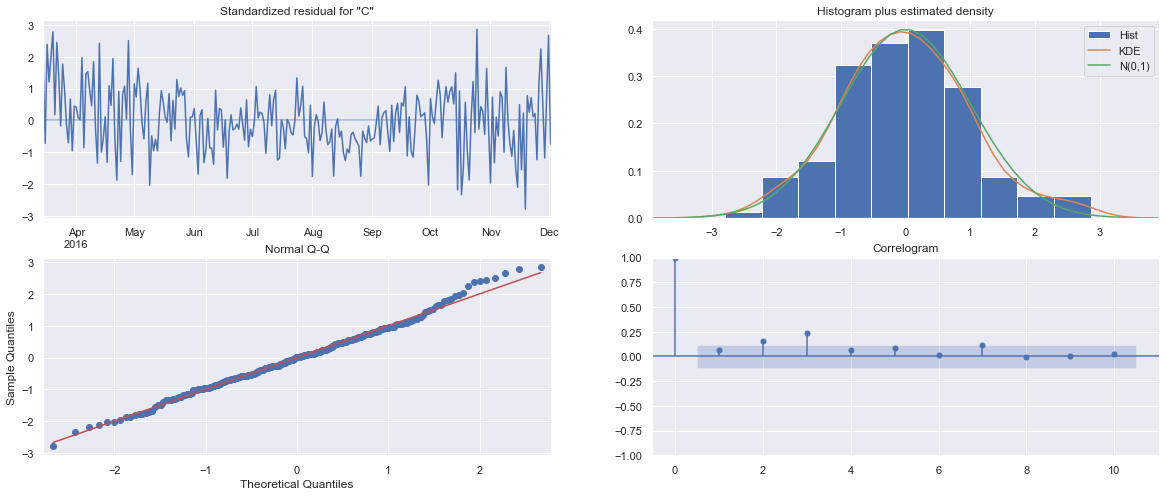

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  263
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1475.498
Date:                Fri, 12 Aug 2022   AIC                           2964.996
Time:                        18:36:26   BIC                           2990.001
Sample:                    03-15-2016   HQIC                          2975.045
                         - 12-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             25.4163      1.046     24.308      0.000      23.367      27.466
RH            12.1623      0.336     36.226      0.000      11.504      12.820
Dew point    -25.1309      1.501    -16.746      0.000     -28.072     -22.190
Is Weekend   -41.2774     10.162     -4.062      0.000     -61.194     -21.361
ma.L1          0.8079      0.062     13.005      0.000       0.686       0.930
ma.L2          0.4037      0.063      6.358      0.000       0.279       0.528
sigma2      4357.7197    371.395     11.733      0.000    3629.799    5085.641
===================================================================================
Ljung-Box (L1) (Q):                   1.17   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.28   Prob(JB):                         0.29
Heteroskedasticity (H):               0.90   Skew:                             0.21
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

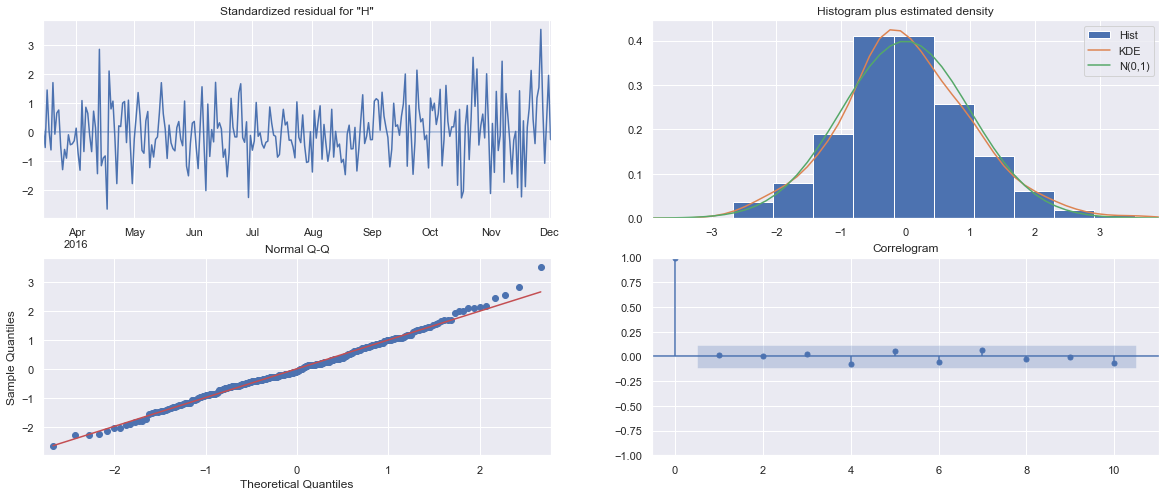

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                     HC   No. Observations:                  263
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -1475.538
Date:                                Fri, 12 Aug 2022   AIC                           2975.075
Time:                                        18:36:27   BIC                           3017.941
Sample:                                    03-15-2016   HQIC                          2992.302
                                         - 12-02-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             28.4048      8.127      3.495      0.000      12.476      44.334
RH             7.5325      2.713      2.777      0.005       2.216      12.849
Dew point    -20.7065      8.613     -2.404      0.016     -37.587      -3.826
ar.L1          0.9782      0.020     49.785      0.000       0.940       1.017
ma.L1         -0.3337      0.069     -4.856      0.000      -0.468      -0.199
ma.L2         -0.1566      0.061     -2.555      0.011      -0.277      -0.036
ma.L3         -0.2093      0.071     -2.932      0.003      -0.349      -0.069
ar.S.L7        0.0265      0.375      0.071      0.944      -0.708       0.761
ar.S.L14       0.9722      0.374      2.599      0.009       0.239       1.705
ma.S.L7        0.0131      0.377      0.035      0.972      -0.726       0.753
ma.S.L14      -0.9467      0.351     -2.698      0.007      -1.634      -0.259
sigma2      4098.4999    372.060     11.016      0.000    3369.277    4827.723
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.11
Prob(Q):                              0.84   Prob(JB):                         0.13
Heteroskedasticity (H):               1.59   Skew:                             0.22
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

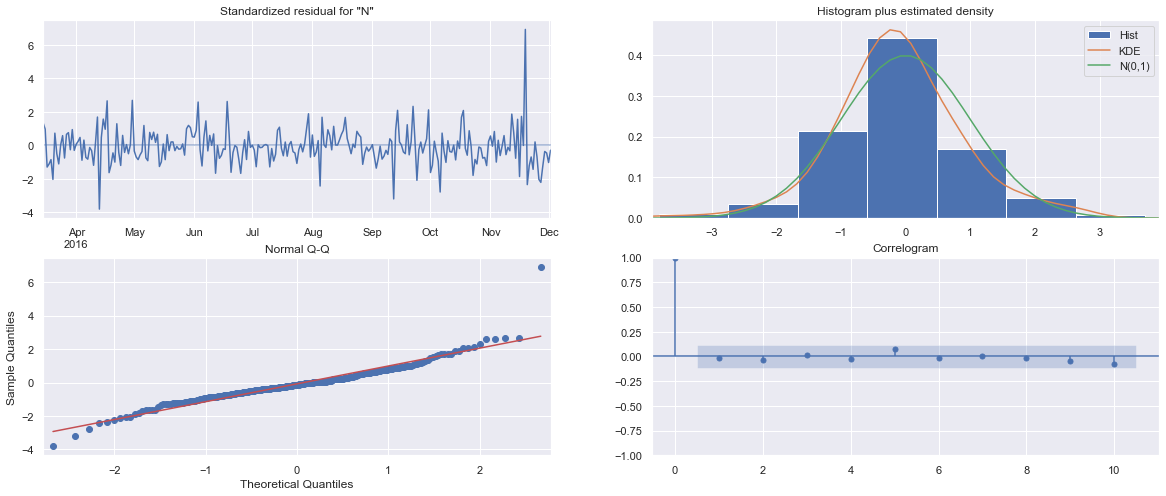

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    NO2   No. Observations:                  263
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 7)   Log Likelihood               -1526.384
Date:                                Fri, 12 Aug 2022   AIC                           3076.768
Time:                                        18:36:27   BIC                           3119.634
Sample:                                    03-15-2016   HQIC                          3093.995
                                         - 12-02-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             14.0663      7.856      1.791      0.073      -1.330      29.463
RH             5.3812      2.689      2.001      0.045       0.112      10.651
Dew point    -26.6915      8.282     -3.223      0.001     -42.925     -10.458
Is Weekend    84.4593     32.118      2.630      0.009      21.510     147.409
ar.L1          0.9938      0.009    105.549      0.000       0.975       1.012
ma.L1         -0.4111      0.051     -8.116      0.000      -0.510      -0.312
ma.L2         -0.1213      0.053     -2.296      0.022      -0.225      -0.018
ma.L3         -0.2638      0.067     -3.912      0.000      -0.396      -0.132
ar.S.L7        0.9998      0.007    152.424      0.000       0.987       1.013
ma.S.L7       -0.9666      0.151     -6.405      0.000      -1.262      -0.671
ma.S.L14      -0.0257      0.052     -0.491      0.623      -0.128       0.077
sigma2      5254.8123    804.764      6.530      0.000    3677.505    6832.120
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               596.65
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             1.03
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

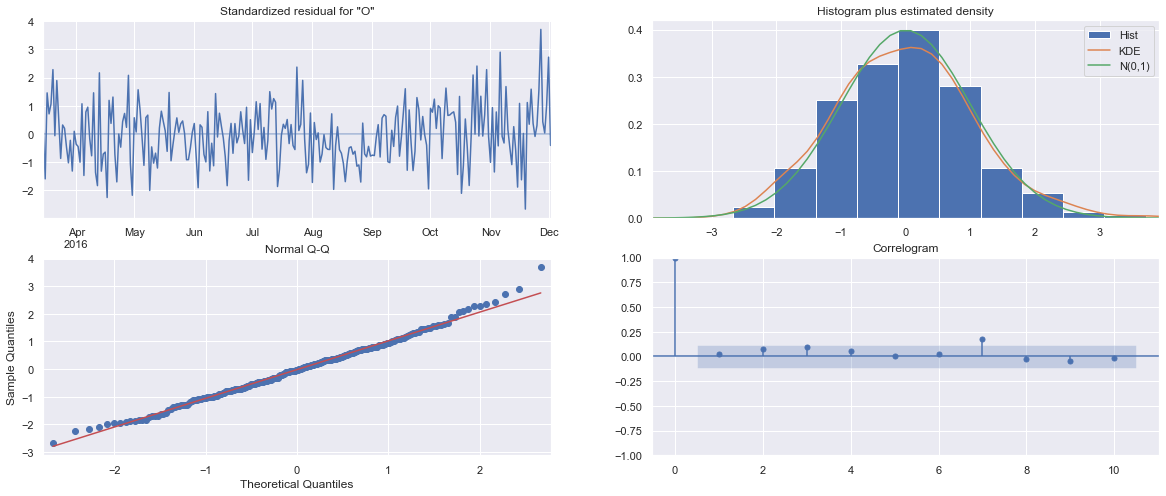

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  263
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1657.092
Date:                Fri, 12 Aug 2022   AIC                           3328.184
Time:                        18:36:28   BIC                           3353.189
Sample:                    03-15-2016   HQIC                          3338.233
                         - 12-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             24.0820      1.810     13.302      0.000      20.534      27.630
RH            11.6858      0.563     20.752      0.000      10.582      12.790
Dew point    -25.5977      3.012     -8.498      0.000     -31.501     -19.694
Is Weekend   -94.9529     21.024     -4.516      0.000    -136.159     -53.747
ma.L1          0.7404      0.062     11.941      0.000       0.619       0.862
ma.L2          0.3219      0.059      5.420      0.000       0.205       0.438
sigma2      1.598e+04   1271.023     12.575      0.000    1.35e+04    1.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.68   Prob(JB):                         0.14
Heteroskedasticity (H):               1.33   Skew:                             0.28
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
for model in sarimax_tuned_models:
    sarimax_tuned_models[model].plot_diagnostics()
    plt.show()
    display(sarimax_tuned_models[model].summary())

In [87]:
sarimaxco.loc[sarimaxco['cv_rmse_mean'].nsmallest(n=5).index]

train_rmse_mean  train_rmse_std  cv_rmse_mean  \
SARIMAX(0, 0, 2)(0, 0, 0, 7)        64.984760        3.325600    129.974777   
SARIMAX(0, 0, 0)(0, 0, 0, 7)        91.837198        3.299017    132.025762   
SARIMAX(0, 0, 1)(0, 0, 0, 7)        68.784058        2.265140    132.343252   
SARIMAX(3, 0, 3)(3, 0, 3, 7)        55.799096        4.037414    134.111375   
SARIMAX(0, 0, 3)(0, 0, 0, 7)        62.325852        2.677388    134.178900   

                              cv_rmse_std     aic_mean     aic_std  \
SARIMAX(0, 0, 2)(0, 0, 0, 7)    45.885856  1494.287944  578.927729   
SARIMAX(0, 0, 0)(0, 0, 0, 7)    50.992689  1585.968591  620.332938   
SARIMAX(0, 0, 1)(0, 0, 0, 7)    50.125531  1510.218513  590.398674   
SARIMAX(3, 0, 3)(3, 0, 3, 7)    46.022632  1477.129973  563.235316   
SARIMAX(0, 0, 3)(0, 0, 0, 7)    42.881194  1484.655355  576.021535   

                                 bic_mean     bic_std  
SARIMAX(0, 0, 2)(0, 0, 0, 7)  1513.883566  581.986203  
SARIMAX(0, 0, 0)(0, 0, 0, 7)  1599.965464  622.517567  
SARIMAX(0, 0, 1)(0, 0, 0, 7)  1527.014761  593.020080  
SARIMAX(3, 0, 3)(3, 0, 3, 7)  1524.719342  570.651734  
SARIMAX(0, 0, 3)(0, 0, 0, 7)  1507.050352  579.517366

We can see that there is some autocorrelation in the residuals for CO and this could be because of the seasonal order for the model that predicts for CO. The seasonal parameters were (0,0,0,7) which means that there is no seasonal order at all, hence, we will try the next best combination of parameters where there is seasonal order.

| Global Order | Seasonal Order |
| ---   | ---   |
| (3,0,3)     | (3,0,3,7)    |

___

<b>Re-evaluating the same model with a slight change in parameters</b>

<u>SARIMAX</u>

In [88]:
# SARIMAX final orders
sarimax_final_orders = {
    'CO': {'order': (3,0,3), 's_order': (3,0,3,7)}, 
    'HC': {'order': (1,0,3), 's_order': (2,0,2,7)}, 
    'NO2': {'order': (1,0,3), 's_order': (1,0,2,7)}, 
    'O3': {'order': (0,0,2), 's_order': (0,0,0,7)}
}

In [89]:
sarimax_pred = []
sarimax_tuned_models = defaultdict()
test_true = test_set.melt(value_vars=gases, value_name='Value', var_name='Gas', ignore_index=False)

for gas in gases:
    exog_input = exog_dict['both']
    exog_test_set = test_set[['T','RH','Dew point','Is Weekend']]
    if gas == 'HC':
        exog_input = exog_dict['dewpoint']
        exog_test_set = test_set[['T','RH','Dew point']]
    sarimaxmodel = SARIMAX(endog=train_set[gas], exog=exog_input, order=sarimax_final_orders[gas]['order'], 
                        seasonal_order=sarimax_final_orders[gas]['s_order'], freq='D', enforce_stationarity=True).fit()
    sarimax_tuned_models[gas] = sarimaxmodel
    
    pred = sarimaxmodel.predict(start=test_set.index.min(), end=test_set.index.max(), exog=exog_test_set)
    for value in pred:
        sarimax_pred.append(value)

print(f"RMSE with SARIMAX final orders: {mean_squared_error(test_true['Value'], sarimax_pred, squared=False)}")

RMSE with SARIMAX final orders: 172.27358449327266


The SARIMAX combinations performed quite well with an RMSE of 172.26219860399596 on an unseen test set.

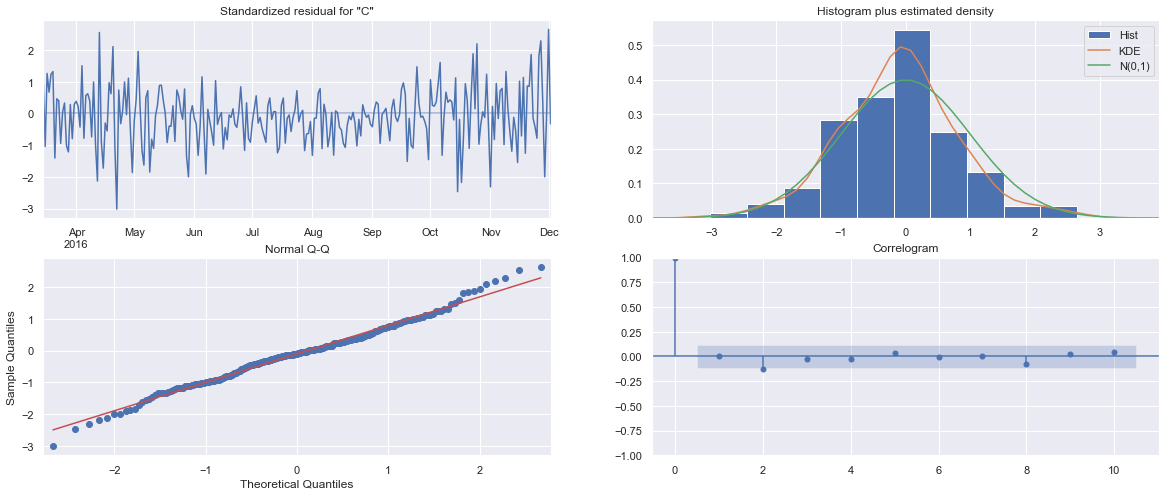

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  263
Model:             SARIMAX(3, 0, 3)x(3, 0, 3, 7)   Log Likelihood               -1448.193
Date:                           Fri, 12 Aug 2022   AIC                           2930.386
Time:                                   18:36:36   BIC                           2991.113
Sample:                               03-15-2016   HQIC                          2954.790
                                    - 12-02-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             30.2026      3.057      9.878      0.000      24.210      36.195
RH            11.1597      0.972     11.479      0.000       9.254      13.065
Dew point    -23.2099      3.198     -7.258      0.000     -29.478     -16.942
Is Weekend   -59.5770     23.330     -2.554      0.011    -105.304     -13.850
ar.L1          0.3003      0.080      3.769      0.000       0.144       0.456
ar.L2         -0.4045      0.058     -7.022      0.000      -0.517      -0.292
ar.L3          0.8066      0.067     12.011      0.000       0.675       0.938
ma.L1          0.5131      0.121      4.240      0.000       0.276       0.750
ma.L2          0.9131      0.092      9.916      0.000       0.733       1.094
ma.L3         -0.1202      0.110     -1.094      0.274      -0.336       0.095
ar.S.L7        0.0995      0.154      0.646      0.518      -0.202       0.402
ar.S.L14      -0.0706      0.142     -0.495      0.620      -0.350       0.209
ar.S.L21       0.9699      0.117      8.280      0.000       0.740       1.200
ma.S.L7       -0.0584      0.313     -0.187      0.852      -0.671       0.554
ma.S.L14       0.0401      0.315      0.127      0.899      -0.577       0.657
ma.S.L21      -0.9535      0.328     -2.910      0.004      -1.596      -0.311
sigma2      4000.5715   1072.706      3.729      0.000    1898.107    6103.036
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.57
Prob(Q):                              0.95   Prob(JB):                         0.10
Heteroskedasticity (H):               1.00   Skew:                             0.07
Prob(H) (two-sided):                  1.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

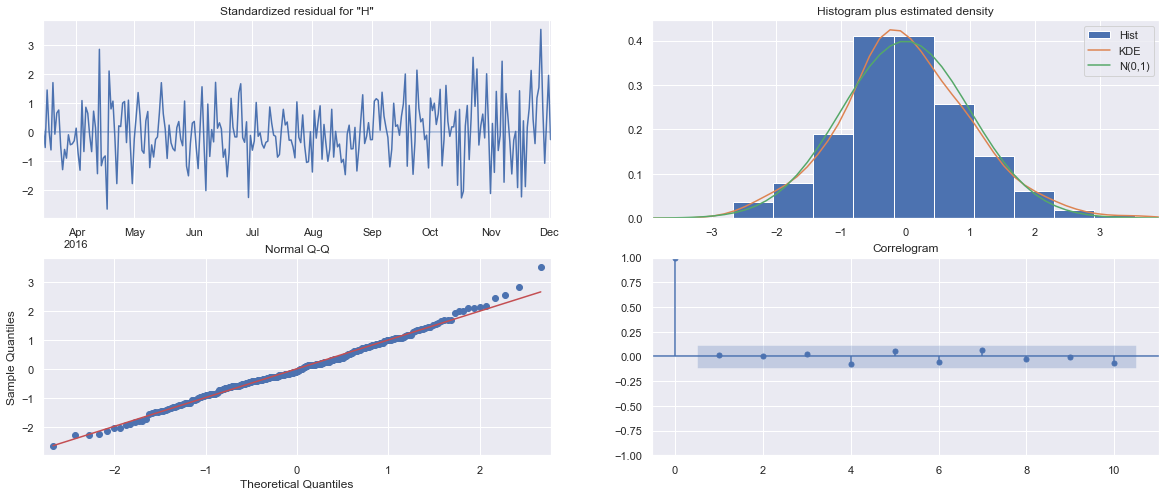

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                     HC   No. Observations:                  263
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -1475.538
Date:                                Fri, 12 Aug 2022   AIC                           2975.075
Time:                                        18:36:37   BIC                           3017.941
Sample:                                    03-15-2016   HQIC                          2992.302
                                         - 12-02-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             28.4048      8.127      3.495      0.000      12.476      44.334
RH             7.5325      2.713      2.777      0.005       2.216      12.849
Dew point    -20.7065      8.613     -2.404      0.016     -37.587      -3.826
ar.L1          0.9782      0.020     49.785      0.000       0.940       1.017
ma.L1         -0.3337      0.069     -4.856      0.000      -0.468      -0.199
ma.L2         -0.1566      0.061     -2.555      0.011      -0.277      -0.036
ma.L3         -0.2093      0.071     -2.932      0.003      -0.349      -0.069
ar.S.L7        0.0265      0.375      0.071      0.944      -0.708       0.761
ar.S.L14       0.9722      0.374      2.599      0.009       0.239       1.705
ma.S.L7        0.0131      0.377      0.035      0.972      -0.726       0.753
ma.S.L14      -0.9467      0.351     -2.698      0.007      -1.634      -0.259
sigma2      4098.4999    372.060     11.016      0.000    3369.277    4827.723
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.11
Prob(Q):                              0.84   Prob(JB):                         0.13
Heteroskedasticity (H):               1.59   Skew:                             0.22
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

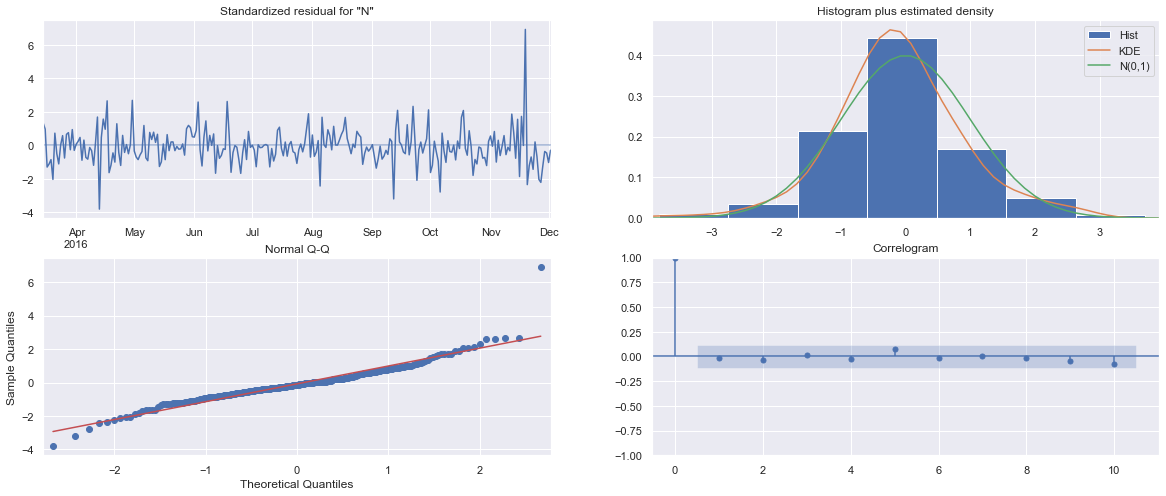

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    NO2   No. Observations:                  263
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 7)   Log Likelihood               -1526.384
Date:                                Fri, 12 Aug 2022   AIC                           3076.768
Time:                                        18:36:37   BIC                           3119.634
Sample:                                    03-15-2016   HQIC                          3093.995
                                         - 12-02-2016                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             14.0663      7.856      1.791      0.073      -1.330      29.463
RH             5.3812      2.689      2.001      0.045       0.112      10.651
Dew point    -26.6915      8.282     -3.223      0.001     -42.925     -10.458
Is Weekend    84.4593     32.118      2.630      0.009      21.510     147.409
ar.L1          0.9938      0.009    105.549      0.000       0.975       1.012
ma.L1         -0.4111      0.051     -8.116      0.000      -0.510      -0.312
ma.L2         -0.1213      0.053     -2.296      0.022      -0.225      -0.018
ma.L3         -0.2638      0.067     -3.912      0.000      -0.396      -0.132
ar.S.L7        0.9998      0.007    152.424      0.000       0.987       1.013
ma.S.L7       -0.9666      0.151     -6.405      0.000      -1.262      -0.671
ma.S.L14      -0.0257      0.052     -0.491      0.623      -0.128       0.077
sigma2      5254.8123    804.764      6.530      0.000    3677.505    6832.120
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               596.65
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                             1.03
Prob(H) (two-sided):                  0.02   Kurtosis:                        10.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

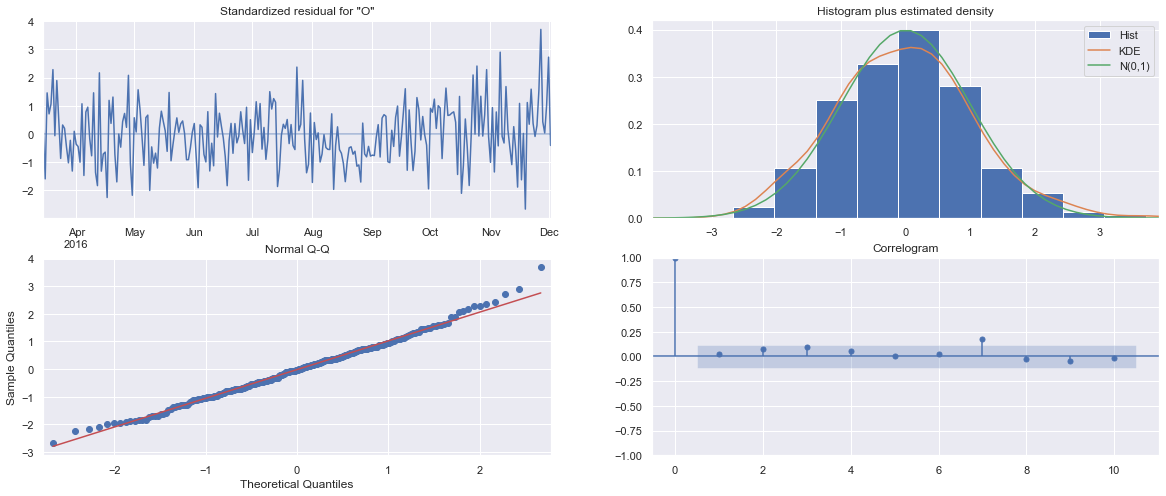

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  263
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -1657.092
Date:                Fri, 12 Aug 2022   AIC                           3328.184
Time:                        18:36:38   BIC                           3353.189
Sample:                    03-15-2016   HQIC                          3338.233
                         - 12-02-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             24.0820      1.810     13.302      0.000      20.534      27.630
RH            11.6858      0.563     20.752      0.000      10.582      12.790
Dew point    -25.5977      3.012     -8.498      0.000     -31.501     -19.694
Is Weekend   -94.9529     21.024     -4.516      0.000    -136.159     -53.747
ma.L1          0.7404      0.062     11.941      0.000       0.619       0.862
ma.L2          0.3219      0.059      5.420      0.000       0.205       0.438
sigma2      1.598e+04   1271.023     12.575      0.000    1.35e+04    1.85e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 3.98
Prob(Q):                              0.68   Prob(JB):                         0.14
Heteroskedasticity (H):               1.33   Skew:                             0.28
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
for model in sarimax_tuned_models:
    sarimax_tuned_models[model].plot_diagnostics()
    plt.show()
    display(sarimax_tuned_models[model].summary())

<b>Conclusion on the final model and parameters</b>

Ljung-Box Probability for all gases indicate that the <b>p-value</b> is greater than 0.05, which means that the model does not show a lack of fit.

We also see that we minimized the issue of autocorrelation in the residuals and we can proceed with the final part of this time series forecasting task. Basically, we did a trade-off for low autocorrelation in the residuals for RMSE score.

| Gas | Global Order | Seasonal Order | Included exogenous variable(s) |
| ---    | ---   | ---   | ---   |
| CO     | (3,0,3)    | (3,0,3,7)    | T, RH, Dew point, Is Weekend |
| HC    | (1,0,3)     | (2,0,2,7)    | T, RH, Dew point |
| NO2    | (1,0,3)     | (1,0,2,7)    | T, RH, Dew point, Is Weekend |
| O3     | (0,0,2)    | (0,0,0,7)    | T, RH, Dew point, Is Weekend |

Finally, we would train the SARIMAX model with the final parameters using the whole dataset and then predict for kaggle.

# Kaggle Submission

<b>Data preprocessing</b>

In [91]:
# Reading test set and dropping 'id' column
test = pd.read_csv('test.csv')
test.drop(columns=['id'], inplace=True)

# Removing the two unnamed columns
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

# Setting date as index
test.Date = pd.to_datetime(test.Date, dayfirst=True)
test.set_index('Date', inplace=True)

# Handling null values
test = test.replace({-200: np.NaN})
missing_index = test.isna().any(axis=1)

In [92]:
# Find out the days that have null values in the test set
test.loc[missing_index]

T  RH  Gas
Date                   
2017-02-14 NaN NaN   CO
2017-02-15 NaN NaN   CO
2017-02-14 NaN NaN   HC
2017-02-15 NaN NaN   HC
2017-02-14 NaN NaN  NO2
2017-02-15 NaN NaN  NO2
2017-02-14 NaN NaN   O3
2017-02-15 NaN NaN   O3

In [93]:
# Drifted values of 'T' and 'RH' on the day before days with null values
test.loc['2017-02-13']

T         RH  Gas
Date                                 
2017-02-13 -52.136458 -32.741667   CO
2017-02-13 -52.136458 -32.741667   HC
2017-02-13 -52.136458 -32.741667  NO2
2017-02-13 -52.136458 -32.741667   O3

In [94]:
# Drifted values of 'T' and 'RH' on the day after days with null values
test.loc['2017-02-16']

T          RH  Gas
Date                                   
2017-02-16 -174.005208 -168.239583   CO
2017-02-16 -174.005208 -168.239583   HC
2017-02-16 -174.005208 -168.239583  NO2
2017-02-16 -174.005208 -168.239583   O3

In [95]:
# Similar days with drifted values of 'T' and 'RH'
pivotUntouched.loc[['2016-12-19', '2016-12-22']]

T          RH          CO          HC         NO2  \
Date                                                                     
2016-12-19  -51.363194  -11.956250  648.391667  588.127778  333.647222   
2016-12-22 -164.510417 -154.515625   29.025000   -0.166667  -43.350000   

                    O3  
Date                    
2016-12-19  794.986111  
2016-12-22   18.833333

In [96]:
# Handling impossible values
for col in ['T', 'RH']:
    test.loc[test[col]<0, col] = np.NaN

# Treating days before and after days with null value as outliers
test.loc['2017-02-13',['T', 'RH']] = np.NaN
test.loc['2017-02-16',['T','RH']] = np.NaN

# Interpolate both the missing and null values
test['T'].interpolate(method ='time', limit_directiion='forward', inplace=True)
test['RH'].interpolate(method ='time', limit_directiion='forward', inplace=True)
test[['T' , 'RH']].isna().sum()

T     0
RH    0
dtype: int64

<b>Pivot Dataframe</b>

In [97]:
test['Value'] = np.zeros(252)
test_pv = test.pivot(columns='Gas', values='Value')
test_pv.insert(0, "RH", test[["RH"]].groupby(test.index).mean())
test_pv.insert(0, "T", test[["T"]].groupby(test.index).mean())

<b>Feature Engineering</b>

In [98]:
# Creating 'Dew point' exogenous variable
test_pv['Dew point'] = (243.04*(np.log(test_pv['RH']/100)+((17.625*test_pv['T'])/(243.04+test_pv['T']))))/(17.625-(np.log(test_pv['RH']/100)+(17.625*test_pv['T'])/(243.04 + test_pv['T'])))

# Creating 'Is Weekend' exogenous variable
test_pv['Is Weekend'] =((test_pv.index.dayofweek == 5)|(test_pv.index.dayofweek == 6)).astype(int)

<b>Predicting values using SARIMAX</b>

In [99]:
sarimax_final = defaultdict()

for gas in gases:
    exog_input = pivotDf[['T','RH','Dew point','Is Weekend']]
    exog_test_set = test_pv[['T','RH','Dew point','Is Weekend']]
    if gas == 'HC':
        exog_input = pivotDf[['T','RH','Dew point']]
        exog_test_set = test_pv[['T','RH','Dew point']]
    sarimaxfinalmodel = SARIMAX(endog=pivotDf[gas], exog=exog_input, order=sarimax_final_orders[gas]['order'], 
                            seasonal_order=sarimax_final_orders[gas]['s_order'], freq='D', enforce_stationarity=True).fit()
    test_pv[gas] = sarimaxfinalmodel.predict(start=test_pv.index.min(), end=test_pv.index.max(), exog=exog_test_set)
    sarimax_final[gas] = sarimaxfinalmodel

final = test_pv.melt(value_vars=gases, value_name='Value', var_name='Gas', ignore_index=False)

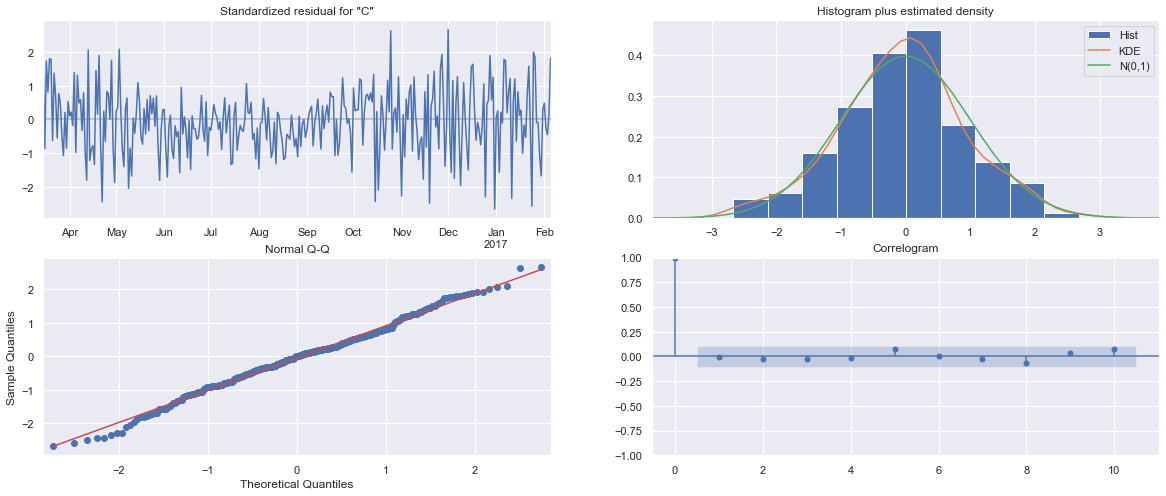

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                CO   No. Observations:                  328
Model:             SARIMAX(3, 0, 3)x(3, 0, 3, 7)   Log Likelihood               -1836.115
Date:                           Fri, 12 Aug 2022   AIC                           3706.230
Time:                                   18:36:48   BIC                           3770.711
Sample:                               03-15-2016   HQIC                          3731.956
                                    - 02-05-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             27.0074      1.719     15.708      0.000      23.637      30.377
RH            11.8524      0.450     26.315      0.000      10.970      12.735
Dew point    -24.4296      1.808    -13.514      0.000     -27.973     -20.887
Is Weekend   -52.1340     19.478     -2.677      0.007     -90.310     -13.958
ar.L1         -0.1753      0.333     -0.527      0.598      -0.827       0.477
ar.L2         -0.2214      0.341     -0.649      0.516      -0.890       0.447
ar.L3          0.5553      0.233      2.383      0.017       0.099       1.012
ma.L1          0.9792      0.343      2.854      0.004       0.307       1.652
ma.L2          0.8751      0.419      2.088      0.037       0.054       1.697
ma.L3          0.0614      0.125      0.492      0.622      -0.183       0.306
ar.S.L7        0.8612      0.143      6.021      0.000       0.581       1.142
ar.S.L14      -0.8247      0.166     -4.969      0.000      -1.150      -0.499
ar.S.L21       0.8885      0.115      7.729      0.000       0.663       1.114
ma.S.L7       -0.8464      0.184     -4.593      0.000      -1.208      -0.485
ma.S.L14       0.8135      0.212      3.845      0.000       0.399       1.228
ma.S.L21      -0.7447      0.155     -4.808      0.000      -1.048      -0.441
sigma2      4517.7935    392.899     11.499      0.000    3747.725    5287.862
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.97   Prob(JB):                         0.72
Heteroskedasticity (H):               1.44   Skew:                            -0.06
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

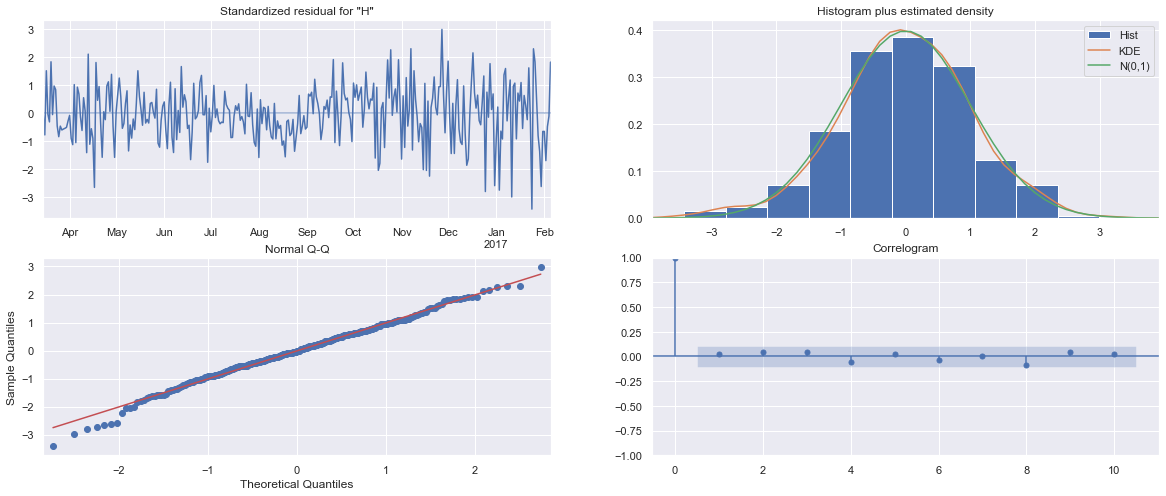

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                     HC   No. Observations:                  328
Model:             SARIMAX(1, 0, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -1879.425
Date:                                Fri, 12 Aug 2022   AIC                           3782.850
Time:                                        18:36:49   BIC                           3828.366
Sample:                                    03-15-2016   HQIC                          3801.009
                                         - 02-05-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             26.0565      4.731      5.508      0.000      16.784      35.329
RH             9.0359      1.492      6.056      0.000       6.112      11.960
Dew point    -23.4768      5.151     -4.558      0.000     -33.572     -13.381
ar.L1          0.9583      0.046     20.810      0.000       0.868       1.049
ma.L1         -0.2927      0.078     -3.755      0.000      -0.446      -0.140
ma.L2         -0.2772      0.061     -4.569      0.000      -0.396      -0.158
ma.L3         -0.2490      0.058     -4.272      0.000      -0.363      -0.135
ar.S.L7        0.0297      0.109      0.273      0.785      -0.183       0.243
ar.S.L14       0.9693      0.108      8.944      0.000       0.757       1.182
ma.S.L7        0.0197      0.437      0.045      0.964      -0.838       0.877
ma.S.L14      -0.9743      0.414     -2.352      0.019      -1.786      -0.162
sigma2      5234.5050   1794.586      2.917      0.004    1717.182    8751.828
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 6.06
Prob(Q):                              0.69   Prob(JB):                         0.05
Heteroskedasticity (H):               2.14   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

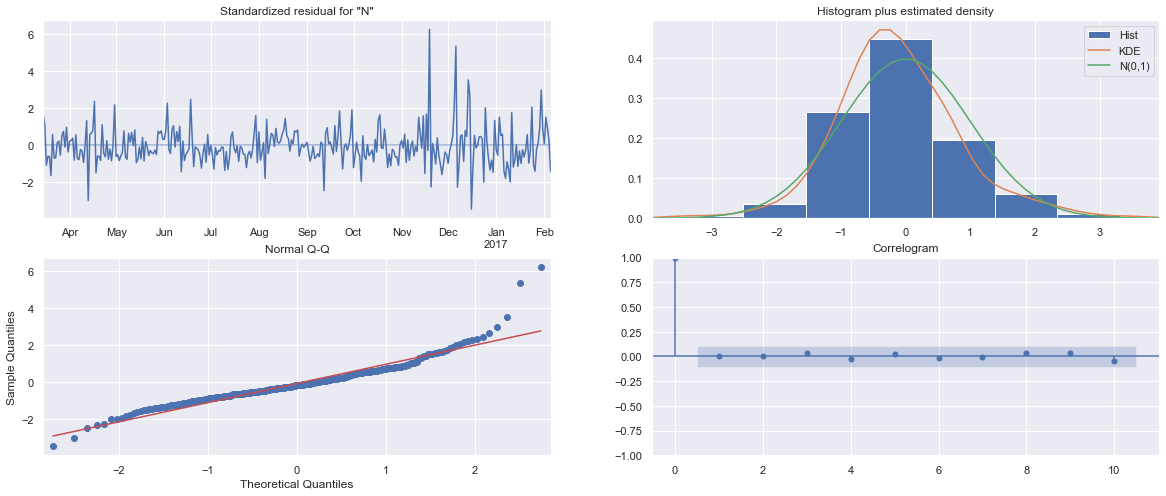

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    NO2   No. Observations:                  328
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 7)   Log Likelihood               -1955.086
Date:                                Fri, 12 Aug 2022   AIC                           3934.173
Time:                                        18:36:49   BIC                           3979.689
Sample:                                    03-15-2016   HQIC                          3952.332
                                         - 02-05-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             19.0132      8.122      2.341      0.019       3.095      34.931
RH             5.1466      2.504      2.056      0.040       0.239      10.054
Dew point    -28.1057      8.402     -3.345      0.001     -44.573     -11.638
Is Weekend    66.1039     31.269      2.114      0.035       4.819     127.389
ar.L1          0.9973      0.003    297.457      0.000       0.991       1.004
ma.L1         -0.3665      0.039     -9.426      0.000      -0.443      -0.290
ma.L2         -0.3130      0.054     -5.849      0.000      -0.418      -0.208
ma.L3         -0.2418      0.059     -4.072      0.000      -0.358      -0.125
ar.S.L7        0.9990      0.006    175.064      0.000       0.988       1.010
ma.S.L7       -0.9807      0.060    -16.302      0.000      -1.099      -0.863
ma.S.L14      -0.0056      0.057     -0.097      0.922      -0.118       0.107
sigma2      7873.6693    436.242     18.049      0.000    7018.652    8728.687
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               651.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

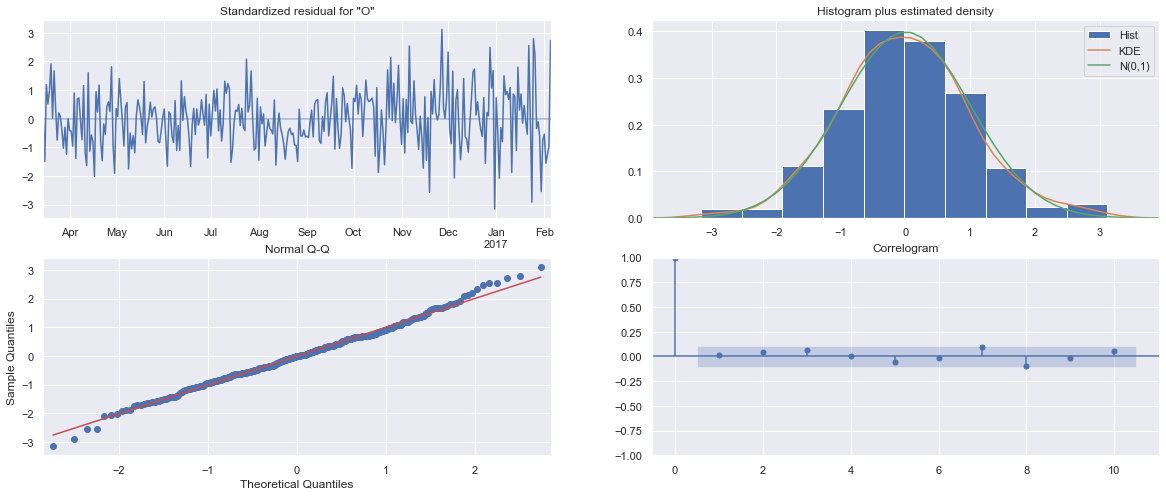

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  328
Model:               SARIMAX(0, 0, 2)   Log Likelihood               -2102.503
Date:                Fri, 12 Aug 2022   AIC                           4219.006
Time:                        18:36:50   BIC                           4245.557
Sample:                    03-15-2016   HQIC                          4229.599
                         - 02-05-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             23.3040      2.044     11.403      0.000      19.299      27.309
RH            12.3634      0.506     24.436      0.000      11.372      13.355
Dew point    -27.0196      3.053     -8.851      0.000     -33.003     -21.037
Is Weekend   -90.9750     21.147     -4.302      0.000    -132.422     -49.528
ma.L1          0.7230      0.053     13.563      0.000       0.619       0.828
ma.L2          0.2704      0.053      5.077      0.000       0.166       0.375
sigma2      2.138e+04   1540.270     13.881      0.000    1.84e+04    2.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.78
Prob(Q):                              0.85   Prob(JB):                         0.25
Heteroskedasticity (H):               2.18   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
for model in sarimax_final:
    sarimax_final[model].plot_diagnostics()
    plt.show()
    display(sarimax_final[model].summary())

Insights for Final SARIMAX model:

- For all the gases, the mean of standardized residuals are relatively close to zero, histogram plus kernel density estimate shows that residuals conform to normal distribution, Q-Q plot shows that residuals fall close to the reference line and the correlograms show no significant lags, indicating a good fit

| Gas | Ljung-Box Probability | Heteroskedasticity Probability |
| ---    | ---   | ---   |
| CO    | 0.97     | 0.06    |
| HC     | 0.69    | 0.00    |
| NO2    | 0.96     | 0.00    |
| O3     | 0.87    | 0.00    |

- Heteroskedascity probability for HC, NO2 and O3 are less than 0.05 which means we have sufficient evidence to reject the null hypothesis and the variance of the residuals are not constant 
- However, the residuals follow a normal distribution as seen from the histogram plus kernel density estimate plot and sometimes, the data fails the heteroskedasticity test because there is too little data
-  Hence, for more reliable analysis, we will follow the visualization from the histogram plus kernel density plot and that the residuals follow a normal distribution and thus have constant variance
- Ljung-Box probability for all the gases are more than 0.05 which means we fail to reject the null hypothesis and that the model does not show a lack of fit for the gases
___

<b>Further preprocessing based on analysis of original data</b>

In [101]:
# Replace rows with missing T and RH with -160
final.loc[missing_index, 'Value'] = -160

# Replacing days before and after days with null values from train set drifted gas values mean 
# Using the most similar drifted values of 'T' and 'RH' shown above
final.loc['2017-02-13','Value'] = pivotUntouched.loc['2016-12-19', gases].mean()
final.loc['2017-02-16','Value'] = pivotUntouched.loc['2016-12-22', gases].mean()

# Separately replace NO2 because the drifted gas value is very different from the other gases
final.iloc[133, 1] = final.iloc[133, 1] - 200

# Copy dataframe for visualising predictions
final_plot = final.copy()

# Drop 'Gas' and create 'id' column for submission
final.drop(columns=['Gas'], inplace=True)
final.insert(0, 'id', np.arange(0, final.shape[0], 1))

<b>Generating csv file for submission</b>

In [102]:
final.to_csv('finalsubmission.csv', index=False)

<b>Visualizing predicted values</b>

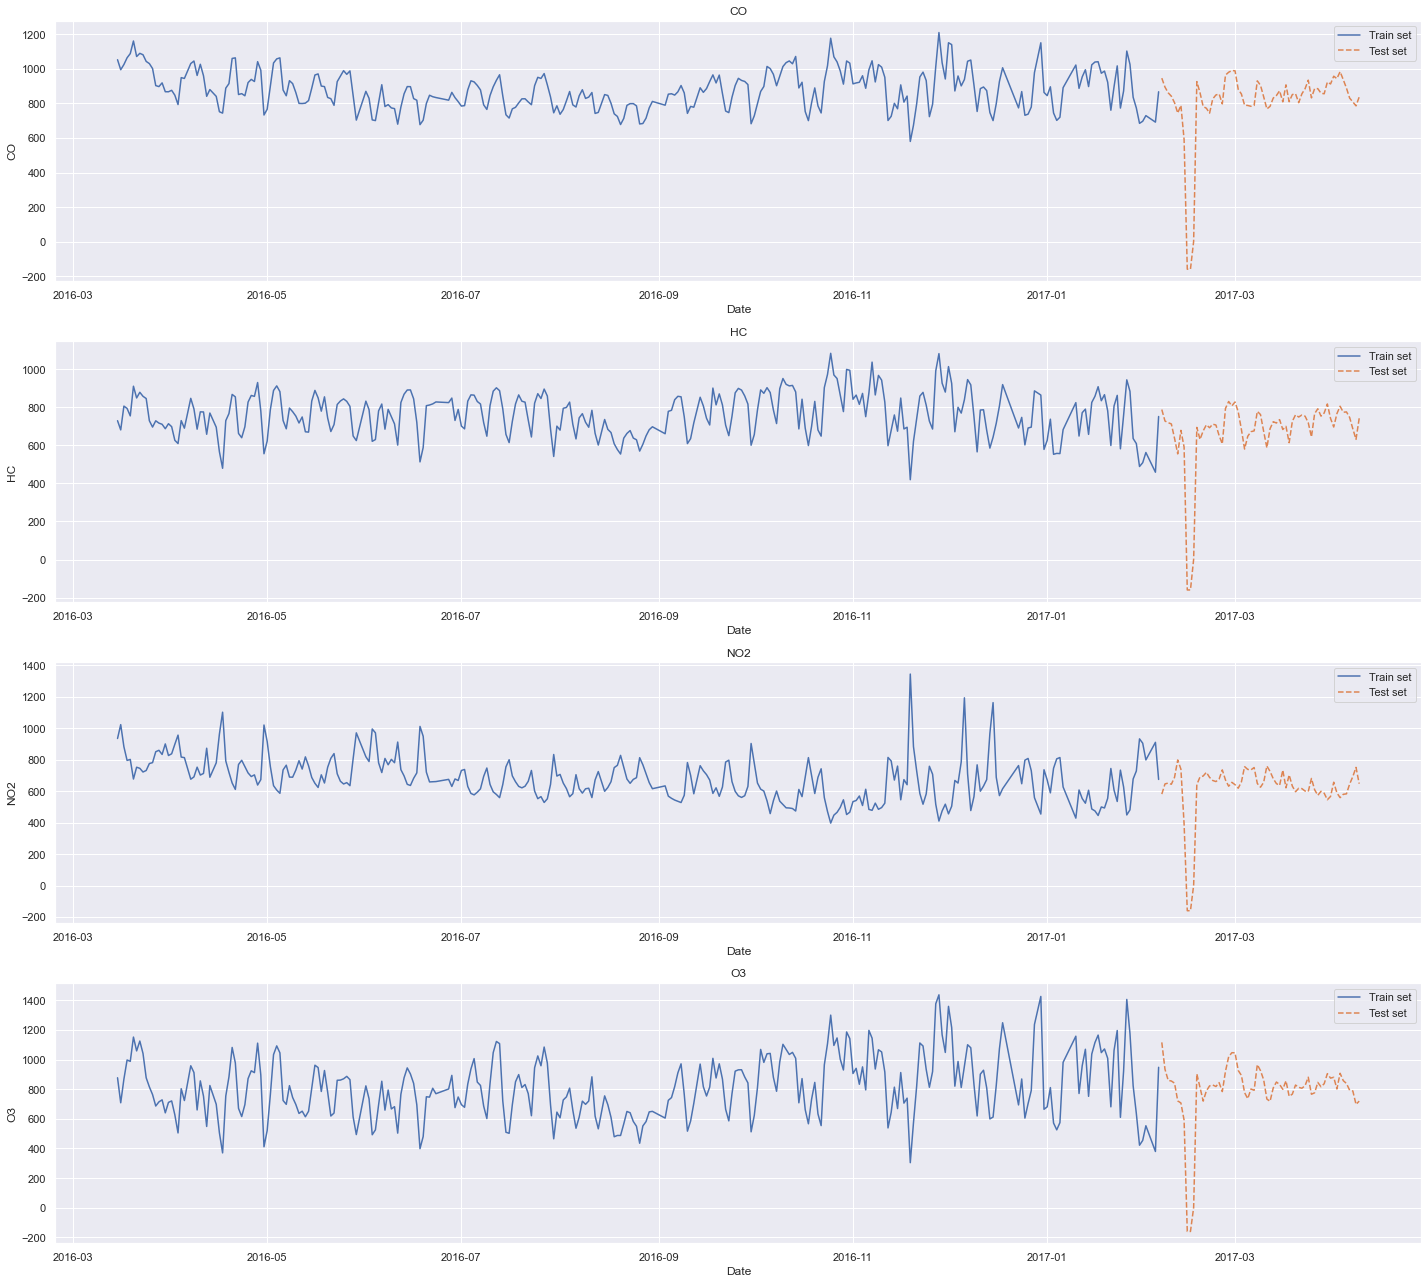

In [103]:
fig, ax = plt.subplots(4,1, figsize=(20, 18), tight_layout=True)
for idx, val in enumerate(gases):
    sns.lineplot(y=val,data=pivotDf, x =pivotDf.index, ax=ax[idx], label='Train set')
    sns.lineplot(y='Value', data=final_plot[final_plot['Gas'] == val], x=final_plot[final_plot['Gas'] == val].index, ax=ax[idx], 
    linestyle='--', label='Test set')
    ax[idx].set_title(val)

# References

<b>Background Research</b>

[1] https://environmentalpollutioncenters.org/air/causes/ 

[2] https://education.nationalgeographic.org/resource/air-pollution 

[3] https://www.tessellationtech.io/3-advantages-to-time-series-analysis-and-forecasting/ 

[4] https://pestleanalysis.com/time-series-analysis/#Benefits_of_Time_Series_Analysis

<b>Additional referencing materials (Methodology)</b>

[5] https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6 

[6] https://otexts.com/fpp2/stl.html 

[7] https://www.statisticshowto.com/ljung-box-test/ 

[8] https://www.statisticshowto.com/white-test/ 

[9] https://otexts.com/fpp2/residuals.html 

[10] https://www.omnicalculator.com/physics/dew-point#:~:text=How%20do%20I%20calculate%20dew,by%20the%20temperature%20plus%20243.04.